# vLoong能源AI挑战赛——异常检测赛
[比赛链接](https://aistudio.baidu.com/aistudio/competition/detail/495/0/introduction)

## 比赛介绍
汽车产业正在经历巨大变革，新能源汽车市场规模持续扩大，电池安全问题日益引发重视。 电池异常检测面临着汽车数据质量差，检出率低，误报率高，大量无效报警无法直接自动化运维等问题。

为了更好的检验电池安全问题，比赛通过募集优秀异常检测方案，使用特征提取、参数优化、异常对比等手段对实车数据进行处理，优化异常检测结果，以便更好的应用于车辆预警、故障模式识别等多种场景。

新能源车辆电池的故障检测对于及时发现车辆问题、排除隐患、保护人的生命财产安全有着重要意义。新能源电池的故障是多种多样的，包括热失控、析锂、漏液等，本次比赛数据中包含了多种故障类型，但在数据中统一标注为故障标签“1”，不做进一步的区分。

一般故障检测都会面临故障标签少的问题，在本次比赛中，我们对数据进行了筛选，正常数据和故障数据的比例不是非常悬殊，即便如此，常规的异常检测算法依然会是一个非常好的选择。

电池的数据是一种时序数据，在数据中的'timestamp'列是该数据的时间戳，理解时序数据的处理方式可能会对异常检测有更好的效果。除此之外，发生异常的数据可能看起来很“正常”，需要提取更多的特征来进行分析。

## 任务重述
上面内容全部是比赛官网复制粘贴的，下面说一下我自己的理解：

给定一个样本对应的属性，判断这个样本是正样本还是负样本。

样本属性的形状为 `8×256` 的向量和 `1`个数值（这一个数值在本项目中未使用）。

## 方案介绍
- 网络结构为 `conv1d+linear+sigmoid`
- 数据增强方法为重采样
- A榜单AUC为0.6824

最后！本方案完全使用Paddle，可以大胆在Aistudio上跑！

# 代码
## 获取数据

In [ ]:
! unzip data/data168245/Train.zip
! unzip data/data168245/Test_A.zip

In [1]:
# 将数据写入txt
import os
with open('train.txt','w') as f:
    for item in os.listdir('Train'):
        if '.pkl' in item:
            f.write('Train/'+item+'\n')
with open('test_A.txt','w') as f:
    for item in os.listdir('Test_A'):
        if '.pkl' in item:
            f.write('Test_A/'+item+'\n')

In [26]:
# 看一下数据展示的内容
import pickle
with open('Train/9998.pkl', 'rb') as f:
    pkl_data = pickle.load(f)
    
pkl_data

(array([[ 1.5330e+02, -4.3000e+00,  3.4300e+01, ...,  1.7400e+02,
          1.6200e+02,  9.9220e+03],
        [ 1.5330e+02, -4.2000e+00,  3.4300e+01, ...,  1.7400e+02,
          1.6200e+02,  9.9320e+03],
        [ 1.5330e+02, -4.2000e+00,  3.4300e+01, ...,  1.7400e+02,
          1.6200e+02,  9.9420e+03],
        ...,
        [ 1.5360e+02, -4.3000e+00,  3.4900e+01, ...,  1.7400e+02,
          1.6200e+02,  1.0706e+04],
        [ 1.5360e+02, -4.3000e+00,  3.4900e+01, ...,  1.7400e+02,
          1.6200e+02,  1.0707e+04],
        [ 1.5360e+02, -4.3000e+00,  3.4900e+01, ...,  1.7400e+02,
          1.6200e+02,  1.0708e+04]]),
 {'label': '00', 'mileage': 1901.2})

In [4]:
index = ["123"]*10
index

['123', '123', '123', '123', '123', '123', '123', '123', '123', '123']

data：形状为（256，8），每列数据对应特征['volt','current','soc','max_single_volt','min_single_volt','max_temp','min_temp','timestamp']
metadata：包含label和mileage信息，label标签中'00'表示正常片段，'10'表示异常片段。

测试集：文件类型为.pkl文件，每个pkl文件内容为元组形式，
data,metadata）；
data：形状为（256，8），每列数据对应特征['volt','current','soc','max_single_volt','min_single_volt','max_temp','min_temp','timestamp']
metadata：仅包含mileage信息。



In [9]:
import pandas as pd

index = ['10034']*256
columns = ['volt','current','soc','max_single_volt','min_single_volt','max_temp','min_temp','timestamp']
df = pd.DataFrame(data=pkl_data[0], index=index, columns=columns) # dtype='float'
df["mileage"] = pkl_data[1]['mileage']
if 1:
    label = pkl_data[1]['label']
    if label == '10':
        df["label"] = 1
    else:
        df["label"]  = 0
print(df)



        volt  current   soc  max_single_volt  min_single_volt  max_temp  \
10034  156.7     -5.0  62.2            1.742            1.730     150.0   
10034  156.7     -5.0  62.2            1.742            1.730     150.0   
10034  156.7     -5.0  62.2            1.742            1.730     150.0   
10034  156.7     -5.0  62.2            1.742            1.730     150.0   
10034  156.7     -5.0  62.2            1.743            1.730     150.0   
...      ...      ...   ...              ...              ...       ...   
10034  157.1     -5.0  62.2            1.747            1.734     150.0   
10034  157.1     -5.0  62.2            1.748            1.734     150.0   
10034  157.1     -5.0  62.2            1.748            1.734     150.0   
10034  157.1     -5.0  62.2            1.747            1.734     150.0   
10034  157.1     -5.0  62.2            1.748            1.734     150.0   

       min_temp  timestamp  mileage  label  
10034     132.0    35185.0   9245.6      1  
10034    

In [ ]:
##训练集
import os
import pandas as pd
# from modin import pandas as pd   ##### 加速！！ 并没有卵用。。。
import pickle
#n = int(input()) #set 
def create_df(label = 1,n=100,mode = True):
    if label == 1:
      fp = open("train_positive.txt","r")
    elif label == 0:
      fp = open("train_negative.txt","r")
    elif label ==2:
      fp = open("train.txt","r")
    elif label ==3:
      fp = open("test_A.txt","r")

    df_final = pd.DataFrame()
    for i in range(n):
        #print(fp.readline().strip())
        file_name = fp.readline().strip()
        with open(file_name, 'rb') as f:
          pkl_data = pickle.load(f)
        index = [str(file_name[6:-4])]* 256
        columns = ['volt','current','soc','max_single_volt','min_single_volt','max_temp','min_temp','time']
        df = pd.DataFrame(data=pkl_data[0], index=index, columns=columns) # dtype='float'
        df["mileage"] = pkl_data[1]['mileage']
        if not mode:
            label = pkl_data[1]['label']
            if label == '10':
                df["label"] = 1
            else:
                df["label"]  = 0
        
        df_final = df_final.append(df)
    return df_final
    

In [9]:
## TEST !!!!!!!!!!!!!!!!
import os
import pandas as pd
# from modin import pandas as pd   ##### 加速！！！！！！！！！！！！！！！！！！！！
import pickle
#n = int(input()) #set 
def create_df(label = 1,n=100,mode = True):
    if label == 1:
      fp = open("train_positive.txt","r")
    elif label == 0:
      fp = open("train_negative.txt","r")
    elif label ==2:
      fp = open("train.txt","r")
    elif label ==3:
      fp = open("test_A.txt","r")

    df_final = pd.DataFrame()
    for i in range(n):
        #print(fp.readline().strip())
        file_name = fp.readline().strip()
        with open(file_name, 'rb') as f:
          pkl_data = pickle.load(f)
        index = [str(file_name[7:-4])]* 256   ## test 的 id从 7 开始
        columns = ['volt','current','soc','max_single_volt','min_single_volt','max_temp','min_temp','time']
        df = pd.DataFrame(data=pkl_data[0], index=index, columns=columns) # dtype='float'
        df["mileage"] = pkl_data[1]['mileage']
        if not mode:
            label = pkl_data[1]['label']
            if label == '10':
                df["label"] = 1
            else:
                df["label"]  = 0
        
        df_final = df_final.append(df)
    return df_final
    

In [10]:
df_test= create_df(label = 3,n= 6234, mode=True)

In [11]:
df_test

,volt,current,soc,max_single_volt,min_single_volt,max_temp,min_temp,time,mileage
0,162.2,-4.6,54.6,1.806,1.794,168.0,156.0,9751.0,3983.8
0,162.2,-4.6,54.6,1.806,1.794,168.0,156.0,9752.0,3983.8
0,162.2,-4.6,54.6,1.806,1.794,168.0,156.0,9753.0,3983.8
0,162.2,-4.6,54.6,1.806,1.794,168.0,156.0,9754.0,3983.8
0,162.2,-4.6,54.6,1.806,1.794,168.0,156.0,9755.0,3983.8
...,...,...,...,...,...,...,...,...,...
9999,158.4,-4.0,45.7,1.762,1.749,126.0,108.0,6750.0,1628.8
9999,158.4,-4.0,45.7,1.762,1.748,126.0,108.0,6751.0,1628.8
9999,158.4,-4.0,45.7,1.762,1.749,126.0,108.0,6753.0,1628.8
9999,158.4,-4.0,45.7,1.762,1.748,126.0,108.0,6754.0,1628.8


In [12]:
df_test['id']=df_test.index

In [13]:
df_test.to_pickle('testdata.pkl')

## 读取数据！！！！！

In [6]:
import pandas as pd
data = pd.read_pickle('data.pkl')

In [4]:

data

,volt,current,soc,max_single_volt,min_single_volt,max_temp,min_temp,time,mileage,label
7233,164.4,-26.2,50.2,1.831,1.824,204.0,198.0,5256.0,6313.0,0
7233,164.4,-26.4,50.2,1.831,1.824,204.0,198.0,5257.0,6313.0,0
7233,164.4,-26.4,50.2,1.831,1.824,204.0,198.0,5258.0,6313.0,0
7233,164.4,-26.4,50.2,1.831,1.823,204.0,198.0,5259.0,6313.0,0
7233,164.3,-26.1,50.2,1.831,1.823,204.0,198.0,5260.0,6313.0,0
...,...,...,...,...,...,...,...,...,...,...
21735,164.9,-5.8,57.8,1.835,1.825,138.0,126.0,3738.0,3366.0,0
21735,164.9,-5.8,57.8,1.835,1.825,138.0,126.0,3739.0,3366.0,0
21735,164.9,-5.8,57.8,1.835,1.826,138.0,126.0,3740.0,3366.0,0
21735,164.9,-5.8,57.8,1.835,1.825,138.0,126.0,3741.0,3366.0,0


In [2]:

data['id']=data.index

In [3]:
data.sort_values(['id'], ascending=True)

,volt,current,soc,max_single_volt,min_single_volt,max_temp,min_temp,time,mileage,label,id
0,160.3,-11.1,40.6,1.784,1.766,96.0,84.0,6539.0,2445.3,0,0
0,160.5,-11.1,41.3,1.786,1.769,96.0,84.0,6719.0,2445.3,0,0
0,160.6,-11.1,41.3,1.786,1.769,96.0,84.0,6720.0,2445.3,0,0
0,160.6,-11.1,41.3,1.787,1.769,96.0,84.0,6721.0,2445.3,0,0
0,160.6,-11.1,41.3,1.787,1.770,96.0,84.0,6722.0,2445.3,0,0
...,...,...,...,...,...,...,...,...,...,...,...
9999,150.6,-5.0,26.0,1.675,1.671,186.0,162.0,3328.0,4953.9,0,9999
9999,150.6,-5.0,26.0,1.675,1.671,186.0,162.0,3338.0,4953.9,0,9999
9999,150.6,-5.0,26.0,1.675,1.671,186.0,162.0,3348.0,4953.9,0,9999
9999,150.7,-5.0,26.7,1.677,1.672,186.0,162.0,3797.0,4953.9,0,9999


In [6]:
a = []
for i in range(0,len(data),256):
    a.append(i)
y  = data.iloc[a]['label']
y.sort_index(inplace=True)
y
y.to_pickle('label.pkl')

0       0
1       0
10      0
100     1
1000    0
       ..
9995    0
9996    0
9997    0
9998    0
9999    0
Name: label, Length: 28388, dtype: int64

In [5]:
data = data.drop(columns="label")

In [ ]:
## 第二种提取特征方法
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import EfficientFCParameters

# settings = EfficientFCParameters()

# 同时执行提取、和过滤：tsfresh.extract_relevant_features()

from tsfresh import extract_relevant_features

features_filtered_direct = extract_relevant_features(df,y, column_id='id', column_sort='time',ml_task='classification')
features_filtered_direct.shape

In [2]:
import pandas as pd
features_filtered_direct=pd.read_pickle('features_filtered_direct.pkl')
features_filtered_direct

,"min_temp__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20)","min_temp__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20)","min_temp__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20)","min_temp__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20)","min_temp__cwt_coefficients__coeff_4__w_2__widths_(2, 5, 10, 20)","min_temp__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20)","min_temp__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20)","mileage__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20)","min_temp__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20)","min_temp__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20)",...,current__longest_strike_below_mean,"volt__fft_coefficient__attr_""angle""__coeff_38",current__index_mass_quantile__q_0.3,"current__fft_coefficient__attr_""angle""__coeff_3","current__fft_coefficient__attr_""angle""__coeff_52",min_single_volt__large_standard_deviation__r_0.30000000000000004,soc__percentage_of_reoccurring_values_to_all_values,"min_temp__fft_coefficient__attr_""imag""__coeff_80","current__fft_coefficient__attr_""angle""__coeff_16","min_temp__fft_coefficient__attr_""angle""__coeff_80"
0,60.442974,63.899196,85.175292,95.014046,27.579351,48.347138,66.159790,2765.926744,82.008032,32.435539,...,28.0,107.487154,0.300781,133.104476,148.932096,1.0,1.0,0.0,36.346520,0.0
1,151.107434,159.747990,212.938229,237.535115,68.948377,120.867845,165.399476,8646.617514,205.020080,81.088847,...,2.0,126.870242,0.300781,-42.794818,106.368007,0.0,1.0,0.0,39.077921,0.0
10,138.155369,146.055306,194.686381,217.174962,63.038516,110.507744,151.222378,1635.712045,187.446930,74.138374,...,61.0,93.048158,0.300781,-69.198907,163.144142,0.0,1.0,0.0,-0.040173,0.0
100,133.838013,141.491077,188.602431,210.388245,61.068562,107.054377,146.496679,9462.267854,181.589214,71.821550,...,2.0,135.586248,0.300781,-133.590781,-61.790571,0.0,1.0,0.0,107.285530,0.0
1000,129.520658,136.926849,182.518482,203.601527,59.098609,103.601010,141.770980,6228.623158,175.731497,69.504726,...,37.0,126.385383,0.304688,-28.804055,25.125887,0.0,1.0,0.0,-172.619508,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,25.904132,27.385370,36.503696,40.720305,11.819722,20.720202,28.354196,3659.171887,35.146299,13.900945,...,0.0,109.430828,0.300781,0.000000,0.000000,0.0,1.0,0.0,0.000000,0.0
9996,151.107434,159.747990,212.938229,237.535115,68.948377,120.867845,165.399476,0.000000,205.020080,81.088847,...,165.0,151.892541,0.296875,-7.054221,-85.738070,0.0,1.0,0.0,-160.219878,0.0
9997,116.568592,123.234164,164.266634,183.241374,53.188748,93.240909,127.593882,11125.805441,158.158348,62.554253,...,218.0,107.163279,0.300781,-44.105657,-123.372356,1.0,1.0,0.0,-46.246196,0.0
9998,116.568592,123.234164,164.266634,183.241374,53.188748,93.240909,127.593882,2150.484573,158.158348,62.554253,...,70.0,85.943486,0.300781,66.084969,52.977872,0.0,1.0,0.0,-42.481697,0.0


### 选择top关联的特征
效果不太好,略

In [9]:
from tsfresh.feature_selection.relevance import calculate_relevance_table
import tsfresh
relevance_table = calculate_relevance_table(features_filtered_direct, y,ml_task="classification",chunksize=1)
relevance_table

In [ ]:
relevance_table[relevance_table.relevant].sort_values('p_value', ascending=True)

In [ ]:
select_feats = relevance_table[relevance_table.relevant].sort_values('p_value', ascending=True).iloc[:59]['feature'].values

In [ ]:
select_feats = relevance_table[relevance_table.relevant].sort_values('p_value', ascending=True).iloc[:59]['feature'].values

## 特征筛选

In [3]:
## 原来4865个特征
features_filtered_direct

,"min_temp__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20)","min_temp__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20)","min_temp__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20)","min_temp__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20)","min_temp__cwt_coefficients__coeff_4__w_2__widths_(2, 5, 10, 20)","min_temp__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20)","min_temp__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20)","mileage__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20)","min_temp__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20)","min_temp__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20)",...,current__longest_strike_below_mean,"volt__fft_coefficient__attr_""angle""__coeff_38",current__index_mass_quantile__q_0.3,"current__fft_coefficient__attr_""angle""__coeff_3","current__fft_coefficient__attr_""angle""__coeff_52",min_single_volt__large_standard_deviation__r_0.30000000000000004,soc__percentage_of_reoccurring_values_to_all_values,"min_temp__fft_coefficient__attr_""imag""__coeff_80","current__fft_coefficient__attr_""angle""__coeff_16","min_temp__fft_coefficient__attr_""angle""__coeff_80"
0,60.442974,63.899196,85.175292,95.014046,27.579351,48.347138,66.159790,2765.926744,82.008032,32.435539,...,28.0,107.487154,0.300781,133.104476,148.932096,1.0,1.0,0.0,36.346520,0.0
1,151.107434,159.747990,212.938229,237.535115,68.948377,120.867845,165.399476,8646.617514,205.020080,81.088847,...,2.0,126.870242,0.300781,-42.794818,106.368007,0.0,1.0,0.0,39.077921,0.0
10,138.155369,146.055306,194.686381,217.174962,63.038516,110.507744,151.222378,1635.712045,187.446930,74.138374,...,61.0,93.048158,0.300781,-69.198907,163.144142,0.0,1.0,0.0,-0.040173,0.0
100,133.838013,141.491077,188.602431,210.388245,61.068562,107.054377,146.496679,9462.267854,181.589214,71.821550,...,2.0,135.586248,0.300781,-133.590781,-61.790571,0.0,1.0,0.0,107.285530,0.0
1000,129.520658,136.926849,182.518482,203.601527,59.098609,103.601010,141.770980,6228.623158,175.731497,69.504726,...,37.0,126.385383,0.304688,-28.804055,25.125887,0.0,1.0,0.0,-172.619508,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,25.904132,27.385370,36.503696,40.720305,11.819722,20.720202,28.354196,3659.171887,35.146299,13.900945,...,0.0,109.430828,0.300781,0.000000,0.000000,0.0,1.0,0.0,0.000000,0.0
9996,151.107434,159.747990,212.938229,237.535115,68.948377,120.867845,165.399476,0.000000,205.020080,81.088847,...,165.0,151.892541,0.296875,-7.054221,-85.738070,0.0,1.0,0.0,-160.219878,0.0
9997,116.568592,123.234164,164.266634,183.241374,53.188748,93.240909,127.593882,11125.805441,158.158348,62.554253,...,218.0,107.163279,0.300781,-44.105657,-123.372356,1.0,1.0,0.0,-46.246196,0.0
9998,116.568592,123.234164,164.266634,183.241374,53.188748,93.240909,127.593882,2150.484573,158.158348,62.554253,...,70.0,85.943486,0.300781,66.084969,52.977872,0.0,1.0,0.0,-42.481697,0.0


### 特征选择

In [15]:
from feature_selector import FeatureSelector
# 创建 feature-selector 实例，并传入features 和labels
fs = FeatureSelector(data=features_filtered_direct, labels=y)

0 features with greater than 0.60 missing values.



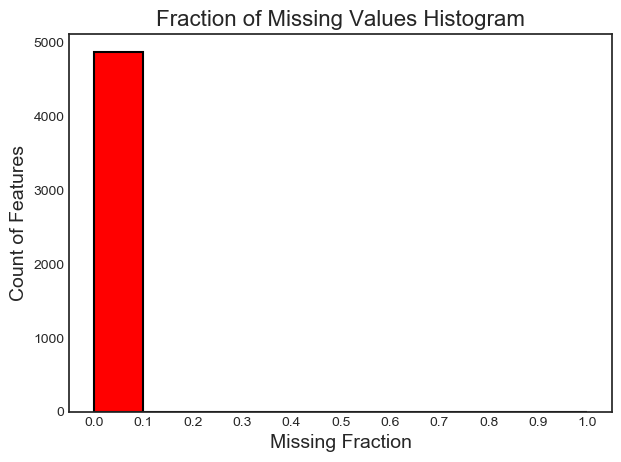

In [8]:
# 选择出missing value 百分比大于60%的特征
fs.identify_missing(missing_threshold=0.6)

# 查看选择出的特征
fs.ops['missing']

# 绘制所有特征missing value百分比的直方图
fs.plot_missing()

In [9]:
# 不对feature进行one-hot encoding（默认为False）, 然后选择出相关性大于98%的feature, 
fs.identify_collinear(correlation_threshold=0.98, one_hot=False)

# 查看选择的feature
fs.ops['collinear']

# 绘制选择的特征的相关性heatmap
fs.plot_collinear()

# 绘制所有特征的相关性heatmap

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[514]	valid_0's auc: 0.999907
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[559]	valid_0's auc: 0.999868
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[510]	valid_0's auc: 0.999848
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[821]	valid_0's auc: 0.999918
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[529]	valid_0's auc: 0.999897
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[765]	valid_0's auc: 0.999884
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[613]	valid_0's auc: 0.999895
Training until validation scores don't improve for 100 rounds.
Early s

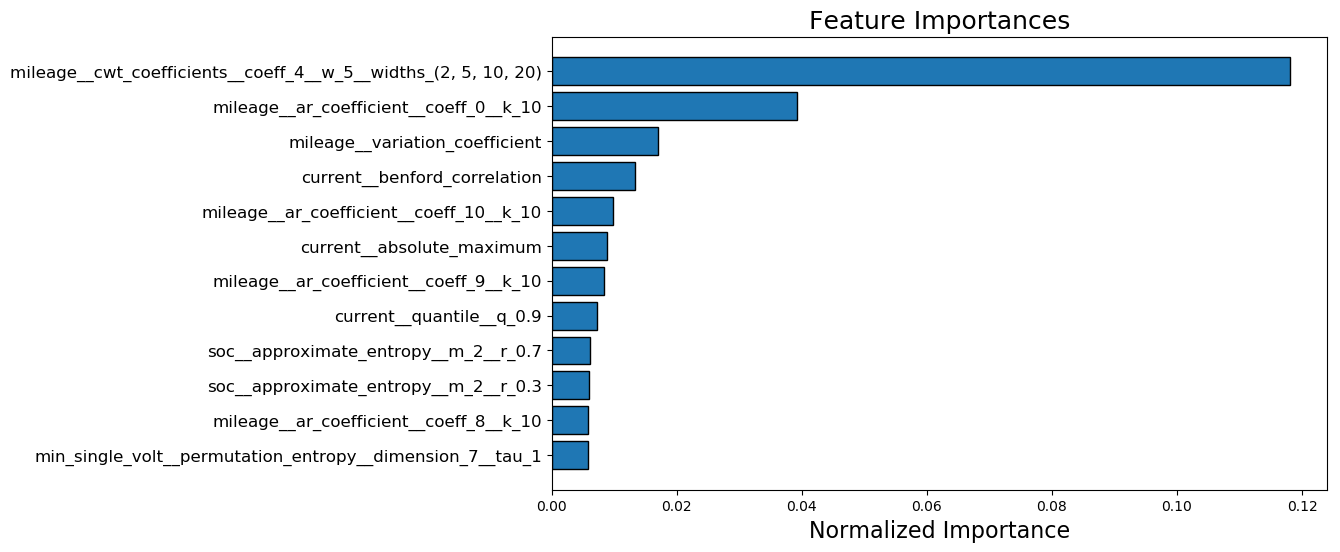

C:\Users\Administrator\AppData\Roaming\Python\Python36\site-packages\matplotlib\cbook\__init__.py:2019: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\Administrator\AppData\Roaming\Python\Python36\site-packages\matplotlib\axes\_base.py:251: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


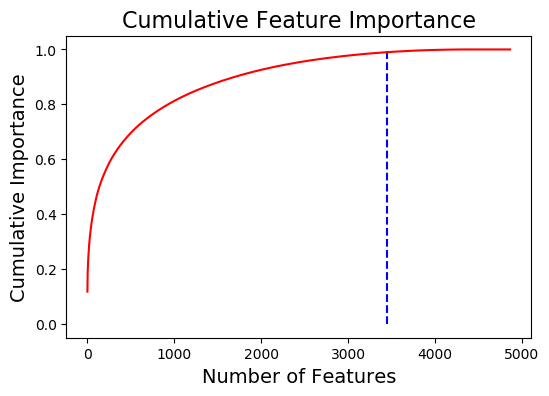

3446 features required for 0.99 of cumulative importance


In [16]:
fs.identify_zero_importance(task='classification',
                                             eval_metric='auc',
                                             n_iterations=20,
                                             early_stopping=True)


# 查看选择出的zero importance feature
fs.ops['zero_importance']

# 绘制feature importance 关系图
# 参数说明：
#          plot_n: 指定绘制前plot_n个最重要的feature的归一化importance条形图，如图4所示
#          threshold: 指定importance分数累积和的阈值，用于指定图4中的蓝色虚线.
#              蓝色虚线指定了importance累积和达到threshold时，所需要的feature个数。
#              注意：在计算importance累积和之前，对feature列表安装feature importance的大小
#                   进行了降序排序
# 
#      
fs.plot_feature_importances(threshold=0.99, plot_n=12)

In [8]:
# 选择出对importance累积和达到99%没有贡献的feature
fs.identify_low_importance(cumulative_importance=0.99)

# 查看选择出的feature
fs.ops['low_importance']

3291 features required for cumulative importance of 0.99 after one hot encoding.
1574 features do not contribute to cumulative importance of 0.99.



['volt__energy_ratio_by_chunks__num_segments_10__segment_focus_7',
 'min_single_volt__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0',
 'soc__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4',
 'max_single_volt__fft_coefficient__attr_"abs"__coeff_17',
 'volt__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4',
 'volt__energy_ratio_by_chunks__num_segments_10__segment_focus_8',
 'soc__linear_trend__attr_"slope"',
 'current__number_peaks__n_10',
 'current__fft_aggregated__aggtype_"centroid"',
 'min_temp__variation_coefficient',
 'volt__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4',
 'min_temp__quantile__q_0.2',
 'max_single_volt__linear_trend__attr_"rvalue"',
 'min_single_volt__first_location_of_minimum',
 'current__fft_coefficient__attr_"abs"__coeff_57',
 'current__fft_coefficient__attr_"abs"__coeff_80',
 'max_temp__benford_correlation',
 'current__fft_coefficient__attr_"abs"__coeff_54',
 'max_single_volt__fft_coefficient__attr_"imag"__coeff_

0 features with a single unique value.



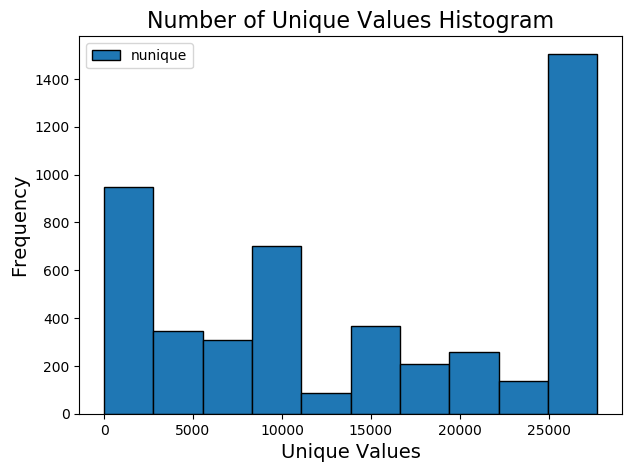

In [9]:
# 选择出只有单个值的feature
fs.identify_single_unique()

# 查看选择出的feature
fs.ops['single_unique']

#绘制所有feature unique value的直方图
fs.plot_unique()

In [10]:
# 去除所有类型的特征
#    参数说明：
#       methods: 
#               desc:  需要去除哪些类型的特征
#               type:  string / list-like object
#             values:  'all' 或者是 ['missing', 'single_unique', 'collinear', 'zero_importance', 'low_importance']
#                      中多个方法名的组合
#      keep_one_hot: 
#              desc: 是否需要保留one-hot encoding的特征
#              type: boolean
#              values: True/False
#              default: True
train_removed = fs.remove(methods = 'all', keep_one_hot=False)

['zero_importance', 'low_importance', 'single_unique'] methods have been run

Removed 1574 features including one-hot features.


In [28]:
train_removed.to_pickle('train_removed.pkl')

In [30]:
train_removed.iloc[:3,:].to_pickle('train_removed.pkl')

In [23]:
train_removed

,"mileage__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20)","min_temp__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20)","min_temp__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20)","min_temp__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20)","min_temp__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20)",min_temp__c3__lag_2,min_temp__absolute_maximum,"min_temp__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)","min_temp__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)","min_temp__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)",...,"min_temp__fft_coefficient__attr_""imag""__coeff_71","min_temp__fft_coefficient__attr_""angle""__coeff_71","max_temp__fft_coefficient__attr_""imag""__coeff_98",current__longest_strike_below_mean,"volt__fft_coefficient__attr_""angle""__coeff_38","current__fft_coefficient__attr_""angle""__coeff_3","current__fft_coefficient__attr_""angle""__coeff_52","min_temp__fft_coefficient__attr_""imag""__coeff_80","current__fft_coefficient__attr_""angle""__coeff_16","min_temp__fft_coefficient__attr_""angle""__coeff_80"
0,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
10,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
100,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
1000,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
9996,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
9997,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
9998,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


In [ ]:
### 存储缩减特征配置，最后剩下3291个特征。
import tsfresh
import numpy as np
removed_parameters_setting = tsfresh.feature_extraction.settings.from_columns(train_removed.columns) 
# np.save('./removed_parameters.npy', removed_parameters)
# removed_parameters 

<!-- ### 获取预准备好的特征生成配置
import tsfresh
import numpy as np
saved_kind_to_fc_parameters = np.load('./removed_parameters_setting.npy', allow_pickle='TRUE').item()
saved_kind_to_fc_parameters -->

In [ ]:
## 提取特征
from tsfresh import extract_features, extract_relevant_features, select_features
extracted_train_features = extract_features(data,  column_id='id', column_sort='time', disable_progressbar=True,kind_to_fc_parameters=removed_parameters_setting ,chunksize=1)
extracted_train_features

In [ ]:
extracted_test_features = extract_features(testdata,  column_id='id', column_sort='time', disable_progressbar=True,
 kind_to_fc_parameters=removed_parameters_setting ,chunksize=1)
extracted_test_features

In [9]:

import pandas as pd
extracted_train_features=pd.read_pickle('extracted_train_features.pkl')
extracted_train_features
y = pd.read_pickle('label.pkl')
y

In [19]:
# 最后测试
# 在训练集上训练LightGBM模型
classifier_RF.fit(X_full_train, y_train)
train_predict = classifier_RF.predict(X_full_train)
test_predict = classifier_RF.predict(X_full_test)
from sklearn import metrics

print('\n\n 评估模型效果:\n')
print('The train-set accuracy is:',metrics.f1_score(y_train,train_predict))
print('The test-set accuracy is:',metrics.f1_score(y_test,test_predict))
## 查看混淆矩阵 (预测值和真实值的各类情况统计矩阵)
confusion_matrix_result_train = metrics.confusion_matrix(train_predict,y_train)
confusion_matrix_result_test = metrics.confusion_matrix(test_predict,y_test)
print('The trainset confusion matrix result:\n',confusion_matrix_result_train)
print('\n The trainset confusion matrix result:\n',confusion_matrix_result_test)
print('\n The trainset classification_report:\n',classification_report(test_predict,y_test))
print('\n The testset classification_report:\n',classification_report(test_predict,y_test))



 评估模型效果:

The train-set accuracy is: 1.0
The test-set accuracy is: 0.8774038461538463
The trainset confusion matrix result:
 [[18978     0]
 [    0  3732]]

 The trainset confusion matrix result:
 [[4744  192]
 [  12  730]]

 The trainset classification_report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98      4936
           1       0.79      0.98      0.88       742

    accuracy                           0.96      5678
   macro avg       0.89      0.97      0.93      5678
weighted avg       0.97      0.96      0.97      5678


 The testset classification_report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98      4936
           1       0.79      0.98      0.88       742

    accuracy                           0.96      5678
   macro avg       0.89      0.97      0.93      5678
weighted avg       0.97      0.96      0.97      5678



## 数据增强，最后证明RandomOverSampler方法最好！

In [2]:
## 均衡下！！！
from typing import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, ADASYN
#rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = SMOTE().fit_resample(features_filtered_direct, y)
print(sorted(Counter(y_resampled).items()))

X_resampled.shape, y_resampled.shape

KeyboardInterrupt: 

In [3]:
from imblearn.over_sampling import ADASYN
X_resampled2, y_resampled2 = ADASYN().fit_resample(features_filtered_direct, y)
print(sorted(Counter(y_resampled2).items()))

X_resampled2.shape, y_resampled2.shape

[(0, 23734), (1, 23394)]


((47128, 3291), (47128,))

In [ ]:
X_resampled2.to_pickle('X_resampled2.pkl')
y_resampled2.to_pickle('y_resampled2.pkl')

In [5]:
X_resampled.to_pickle('X_resampled.pkl')
y_resampled.to_pickle('y_resampled.pkl')

In [1]:
import pandas as pd
X_resampled=pd.read_pickle('X_resampled.pkl')
y_resampled=pd.read_pickle('y_resampled.pkl')

In [30]:
# 使用K-fold的简写方式
from sklearn.model_selection import cross_validate
cv_cross = cross_validate(classifier_RF, X_full_train, y_train, cv=kfold, scoring=('accuracy', 'f1','roc_auc'))
cv_cross

{'fit_time': array([135.02399778, 133.08853817, 134.7310133 , 134.08099413,
        128.42499948]),
 'score_time': array([0.77898979, 0.79699898, 0.80499148, 0.73800468, 0.76800132]),
 'test_accuracy': array([0.98959842, 0.98657011, 0.98828176, 0.98959842, 0.99117725]),
 'test_f1': array([0.98971756, 0.98671183, 0.98778647, 0.9897946 , 0.99104876]),
 'test_roc_auc': array([0.99885346, 0.99895572, 0.99893073, 0.99938613, 0.99939342])}

In [21]:
X_full_train, X_full_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=.2)
# 最后测试

classifier_RF.fit(X_full_train, y_train)
train_predict = classifier_RF.predict(X_full_train)
test_predict = classifier_RF.predict(X_full_test)
from sklearn import metrics

print('\n\n 评估模型效果:\n')
print('The train-set accuracy is:',metrics.f1_score(y_train,train_predict))
print('The test-set accuracy is:',metrics.f1_score(y_test,test_predict))
## 查看混淆矩阵 (预测值和真实值的各类情况统计矩阵)
confusion_matrix_result_train = metrics.confusion_matrix(train_predict,y_train)
confusion_matrix_result_test = metrics.confusion_matrix(test_predict,y_test)
print('The trainset confusion matrix result:\n',confusion_matrix_result_train)
print('\n The trainset confusion matrix result:\n',confusion_matrix_result_test)
print('\n The trainset classification_report:\n',classification_report(test_predict,y_test))
print('\n The testset classification_report:\n',classification_report(test_predict,y_test))



 评估模型效果:

The train-set accuracy is: 1.0
The test-set accuracy is: 0.9927828486520909
The trainset confusion matrix result:
 [[18969     0]
 [    0 19005]]

 The trainset confusion matrix result:
 [[4749   52]
 [  16 4677]]

 The trainset classification_report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      4801
           1       0.99      1.00      0.99      4693

    accuracy                           0.99      9494
   macro avg       0.99      0.99      0.99      9494
weighted avg       0.99      0.99      0.99      9494


 The testset classification_report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      4801
           1       0.99      1.00      0.99      4693

    accuracy                           0.99      9494
   macro avg       0.99      0.99      0.99      9494
weighted avg       0.99      0.99      0.99      9494



In [ ]:
testdata = pd.read_pickle('extracted_test_features.pkl')
testdata

,"min_temp__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20)","min_temp__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20)","min_temp__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20)","min_temp__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20)","min_temp__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)","min_temp__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)","min_temp__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)","min_temp__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)","min_temp__cwt_coefficients__coeff_10__w_2__widths_(2, 5, 10, 20)","min_temp__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20)",...,current__partial_autocorrelation__lag_1,current__partial_autocorrelation__lag_9,current__partial_autocorrelation__lag_6,current__partial_autocorrelation__lag_5,current__partial_autocorrelation__lag_2,current__partial_autocorrelation__lag_3,current__partial_autocorrelation__lag_8,current__partial_autocorrelation__lag_7,current__partial_autocorrelation__lag_4,current__longest_strike_below_mean
0,60.237429,1.331507,5.984637,30.237499,0.011249,0.007900,0.005435,0.002845,0.005691,107.733118,...,0.778826,-0.109876,-0.063959,0.074779,0.356574,0.182475,0.142746,-0.051169,-0.005029,71.0
1,20.851418,0.460906,2.071605,10.466826,0.003894,0.002735,0.001881,0.000985,0.001970,37.292233,...,0.923448,0.042001,-0.034045,-0.032112,0.137298,-0.001054,0.153169,-0.035414,-0.026645,37.0
10,60.237429,1.331507,5.984637,30.237499,0.011249,0.007900,0.005435,0.002845,0.005691,107.733118,...,0.828580,0.070565,0.127968,0.092518,0.238113,0.101794,0.085683,0.093250,-0.111057,27.0
10001,55.603781,1.229083,5.524280,27.911537,0.010384,0.007292,0.005017,0.002627,0.005253,99.445955,...,-0.015998,-0.019518,-0.018072,-0.017626,-0.016383,-0.016782,-0.019016,-0.018535,-0.017196,1.0
10002,78.772022,1.741201,7.826064,39.541344,0.014710,0.010331,0.007107,0.003721,0.007442,140.881769,...,-0.028333,-0.038988,-0.034298,-0.032945,-0.029382,-0.030495,-0.037306,-0.035747,-0.031681,51.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,106.573913,2.355742,10.588204,53.497113,0.019902,0.013977,0.009616,0.005034,0.010068,190.604746,...,0.679132,0.008755,0.028377,0.152659,0.228818,0.212332,0.074055,0.239131,0.179926,116.0
9995,31.915087,1.274917,4.412830,15.914968,-0.207792,0.055820,-1.849390,-1.213677,0.561016,60.410570,...,0.941508,-0.041501,-0.106493,-0.264966,0.356769,0.601220,0.115021,-0.334717,0.138343,56.0
9996,60.237429,1.331507,5.984637,30.237499,0.011249,0.007900,0.005435,0.002845,0.005691,107.733118,...,0.963371,-0.047714,-0.031041,-0.030952,-0.140295,-0.047587,-0.024204,0.277707,-0.026313,100.0
9998,16.217769,0.358483,1.611248,8.140865,0.003029,0.002127,0.001463,0.000766,0.001532,29.005070,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [27]:
result = classifier_RF.predict_proba(testdata)
result

array([[0.67, 0.33],
       [0.7 , 0.3 ],
       [0.58, 0.42],
       ...,
       [0.67, 0.33],
       [0.74, 0.26],
       [0.72, 0.28]])

In [31]:
result[:,-1]

array([0.33, 0.3 , 0.42, ..., 0.33, 0.26, 0.28])

In [33]:

##id 要对上！！！！！
result_csv = pd.read_csv('result.csv')
result_csv['file_name']=testdata.index+'.pkl'
result_csv['score']= result[:,-1]
result_csv.to_csv('result_RF.csv',index=None)
result_csv

,file_name,score
0,0.pkl,0.33
1,1.pkl,0.30
2,10.pkl,0.42
3,10001.pkl,0.33
4,10002.pkl,0.33
...,...,...
6229,9994.pkl,0.49
6230,9995.pkl,0.42
6231,9996.pkl,0.33
6232,9998.pkl,0.26


## 2. lightgbm

In [4]:
## 完整数据集
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X_full_train, X_full_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=.2)

## 导入LightGBM模型
from lightgbm.sklearn import LGBMClassifier
import re
## 定义 LightGBM 模型 
X_full_train.columns = [re.sub('[^A-Za-z0-9]+', '', col) for col in X_full_train.columns] 
X_full_test.columns = [re.sub('[^A-Za-z0-9]+', '', col) for col in X_full_test.columns] 

clf = LGBMClassifier()
# 在训练集上训练LightGBM模型
clf.fit(X_full_train, y_train)
train_predict = clf.predict(X_full_train)
test_predict = clf.predict(X_full_test)
from sklearn import metrics

## 利用accuracy（准确度）【预测正确的样本数目占总预测样本数目的比例】评估模型效果
print('The train-set accuracy is:',metrics.f1_score(y_train,train_predict))
print('The test-set accuracy is:',metrics.f1_score(y_test,test_predict))
## 查看混淆矩阵 (预测值和真实值的各类情况统计矩阵)
confusion_matrix_result_train = metrics.confusion_matrix(train_predict,y_train)
confusion_matrix_result_test = metrics.confusion_matrix(test_predict,y_test)
print('The trainset confusion matrix result:\n',confusion_matrix_result_train)
print('\n The testset confusion matrix result:\n',confusion_matrix_result_test)
print('\n The trainset classification_report:\n',classification_report(train_predict,y_train))
print('\n The testset classification_report:\n',classification_report(test_predict,y_test))

The train-set accuracy is: 1.0
The test-set accuracy is: 0.9968354430379747
The trainset confusion matrix result:
 [[18979     0]
 [    0 18995]]

 The trainset confusion matrix result:
 [[4739   14]
 [  16 4725]]

 The trainset classification_report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4753
           1       1.00      1.00      1.00      4741

    accuracy                           1.00      9494
   macro avg       1.00      1.00      1.00      9494
weighted avg       1.00      1.00      1.00      9494


 The testset classification_report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4753
           1       1.00      1.00      1.00      4741

    accuracy                           1.00      9494
   macro avg       1.00      1.00      1.00      9494
weighted avg       1.00      1.00      1.00      9494



### 出结果

In [36]:
result = clf.predict_proba(testdata)
result[:,-1]

array([2.10669910e-04, 1.91553876e-04, 9.39148908e-05, ...,
       1.01220271e-04, 1.19007035e-04, 9.67947455e-05])

In [37]:

##id 要对上！！！！！
result_csv = pd.read_csv('result.csv')
result_csv['file_name']=testdata.index+'.pkl'
result_csv['score']= result[:,-1]
result_csv.to_csv('result_lgb.csv',index=None)
result_csv

,file_name,score
0,0.pkl,0.000211
1,1.pkl,0.000192
2,10.pkl,0.000094
3,10001.pkl,0.003662
4,10002.pkl,0.003660
...,...,...
6229,9994.pkl,0.140848
6230,9995.pkl,0.000141
6231,9996.pkl,0.000101
6232,9998.pkl,0.000119


LGBMClassifier()

In [34]:
## 在训练集和测试集上分布利用训练好的模型进行预测

import matplotlib.pyplot as plt
import seaborn as sns
train_predict = clf.predict(X_full_train)
test_predict = clf.predict(X_full_test)
from sklearn import metrics

## 利用accuracy（准确度）【预测正确的样本数目占总预测样本数目的比例】评估模型效果
print('The accuracy is:',metrics.accuracy_score(y_train,train_predict))
print('The accuracy is:',metrics.accuracy_score(y_test,test_predict))

## 查看混淆矩阵 (预测值和真实值的各类情况统计矩阵)
confusion_matrix_result = metrics.confusion_matrix(test_predict,y_test)
print('The confusion matrix result:\n',confusion_matrix_result)

print(classification_report(test_predict,y_test))

d:\learn\Anaconda3\envs\paddet\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


The accuracy is: 0.8572435050638485
The accuracy is: 0.8414934836209933
The confusion matrix result:
 [[4777  900]
 [   0    1]]
             precision    recall  f1-score   support

          0       1.00      0.84      0.91      5677
          1       0.00      1.00      0.00         1

avg / total       1.00      0.84      0.91      5678



d:\learn\Anaconda3\envs\paddet\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [55]:
# is_unbalace
clf = LGBMClassifier()  #is_unbalace=True
# 在训练集上训练LightGBM模型
clf.fit(X_full_train, y_train)
train_predict = clf.predict(X_full_train)
test_predict = clf.predict(X_full_test)
from sklearn import metrics

## 利用accuracy（准确度）【预测正确的样本数目占总预测样本数目的比例】评估模型效果
print('The accuracy is:',metrics.accuracy_score(y_train,train_predict))
print('The accuracy is:',metrics.accuracy_score(y_test,test_predict))

## 查看混淆矩阵 (预测值和真实值的各类情况统计矩阵)
confusion_matrix_result = metrics.confusion_matrix(test_predict,y_test)
print('The confusion matrix result:\n',confusion_matrix_result)

print(classification_report(test_predict,y_test))

The accuracy is: 1.0
The accuracy is: 0.9973667579523909
The confusion matrix result:
 [[4771   15]
 [  10 4698]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4786
           1       1.00      1.00      1.00      4708

    accuracy                           1.00      9494
   macro avg       1.00      1.00      1.00      9494
weighted avg       1.00      1.00      1.00      9494



### rfe 特征在筛选

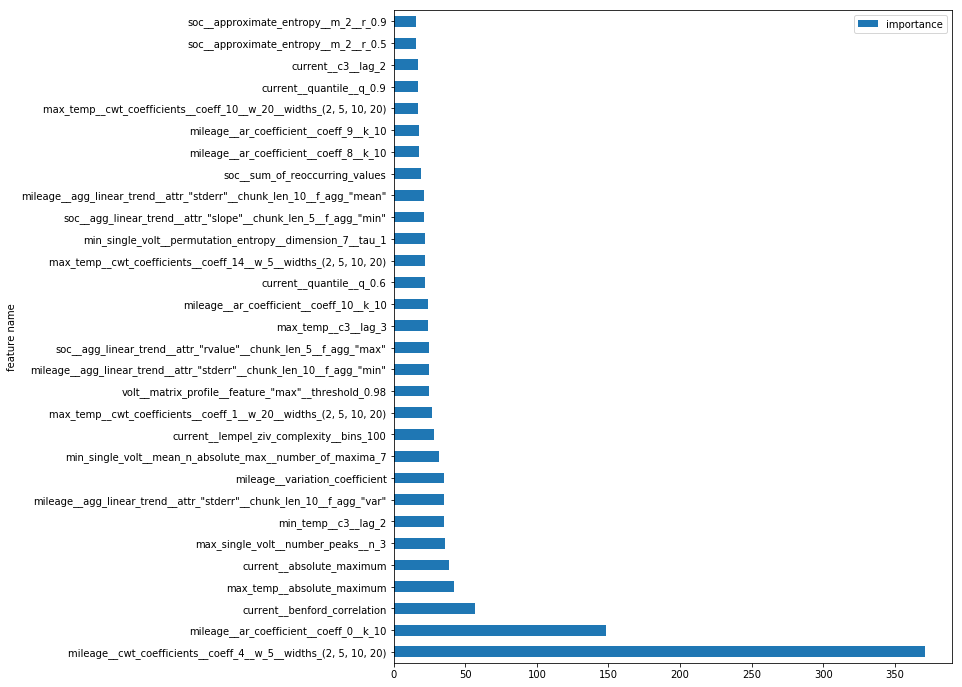

In [7]:
%matplotlib inline
df = pd.DataFrame()
#df['feature name'] = X_full_train.columns  #data_df为特征数据集
df['feature name'] = X_resampled.columns
df['importance'] = clf.feature_importances_
df.sort_values(by='importance',inplace=True, ascending=False)
 
df2 = df.head(30)
df2.plot.barh(x = 'feature name',figsize=(10,12))

### SelectFromModel

In [5]:
## 导入LightGBM模型
from lightgbm.sklearn import LGBMClassifier
import re
## 定义 LightGBM 模型 
clf = LGBMClassifier()
# 在训练集上训练LightGBM模型
features_filtered_direct.columns = [re.sub('[^A-Za-z0-9]+', '', col) for col in features_filtered_direct.columns] 

clf.fit(features_filtered_direct, y)

LGBMClassifier()

In [179]:
X_full_train, X_full_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=.2)

## 导入LightGBM模型
from lightgbm.sklearn import LGBMClassifier
import re
## 定义 LightGBM 模型 
X_full_train.columns = [re.sub('[^A-Za-z0-9]+', '', col) for col in X_full_train.columns] 
X_full_test.columns = [re.sub('[^A-Za-z0-9]+', '', col) for col in X_full_test.columns] 


In [7]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
# X, y = load_iris(return_X_y=True)
# X.shape

# clf = ExtraTreesClassifier(n_estimators=50)
# clf = clf.fit(X, y)
# clf.feature_importances_  

model_select = SelectFromModel(clf, prefit=True,max_features=20)
X_new_train = model_select.transform(features_filtered_direct)
X_new_train.shape

(28388, 20)

In [11]:
X_new_train_df= pd.DataFrame(X_new_train,
index=features_filtered_direct.index,columns=features_filtered_direct.columns[model_select.get_support()])
X_new_train_df

,mintempcwtcoefficientscoeff2w20widths251020,mintempagglineartrendattrinterceptchunklen50faggmax,mileagecwtcoefficientscoeff4w5widths251020,mileagearcoefficientcoeff0k10,mileagearcoefficientcoeff10k10,mileagearcoefficientcoeff9k10,mileageagglineartrendattrslopechunklen10faggmean,mileagevariationcoefficient,minsinglevoltmeannabsolutemaxnumberofmaxima7,minsinglevoltpermutationentropydimension7tau1,maxtempc3lag3,maxtempabsolutemaximum,socagglineartrendattrslopechunklen5faggmin,socfftcoefficientattrabscoeff1,currentagglineartrendattrinterceptchunklen10faggmin,currentlempelzivcomplexitybins100,currentbenfordcorrelation,currentabsolutemaximum,currentquantileq09,currentsumofreoccurringdatapoints
0,32.435539,84.0,2765.926744,0.000041,0.100000,0.100000,-3.886729e-15,0.000000e+00,1.773000,3.435925,8.847360e+05,96.0,0.032464,80.991265,-11.147863,0.207031,0.864123,11.3,-11.1,-2840.9
1,81.088847,210.0,8646.617514,0.000013,0.100000,0.100000,0.000000e+00,2.379537e-16,1.804143,3.197540,1.185235e+07,228.0,0.053441,114.591521,-5.657265,0.113281,-0.145280,5.7,-5.6,-1429.2
10,74.138374,192.0,1635.712045,0.000069,0.100000,0.100000,1.943365e-15,1.572323e-16,1.717143,2.540832,8.489664e+06,204.0,0.025088,61.482702,-11.206838,0.292969,0.864123,11.4,-10.8,-2839.0
100,71.821550,186.0,9462.267854,0.000013,0.262207,0.261246,1.554692e-14,2.174420e-16,1.730000,1.479484,8.489664e+06,204.0,0.013805,12.316404,-5.082051,0.113281,-0.145280,5.2,-5.1,-1301.3
1000,69.504726,180.0,6228.623158,0.000018,0.100000,0.100000,-7.773459e-15,1.651645e-16,1.854857,2.305072,8.526330e+06,210.0,0.041317,81.641938,-4.222222,0.226562,-0.064614,4.3,-4.1,-1068.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,13.900945,36.0,3659.171887,0.000031,0.100000,0.100000,0.000000e+00,0.000000e+00,1.723000,2.535797,1.105920e+05,48.0,0.027149,65.103166,-6.200000,0.085938,-0.200946,6.2,-6.2,-1587.2
9996,81.088847,210.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,1.804000,2.824774,1.094105e+07,222.0,0.017314,48.893626,-11.212821,0.109375,0.862448,11.3,-11.2,-2816.8
9997,62.554253,162.0,11125.805441,0.000010,0.100000,0.100000,-1.554692e-14,1.849299e-16,1.645000,2.708282,5.268024e+06,174.0,0.043097,92.783265,-4.500000,0.113281,-0.064614,4.5,-4.5,-1150.9
9998,62.554253,162.0,2150.484573,0.000053,0.100000,0.100000,0.000000e+00,2.391896e-16,1.705000,0.913893,5.268024e+06,174.0,0.014215,38.545115,-4.542735,0.218750,-0.064614,4.5,-4.3,-1131.6


In [1]:
str(0)

'0'

In [15]:
X_new_train_df.loc['0'].shape

(20,)

In [16]:
X_new_train_df.to_pickle('X_new_train_df.pkl')

In [ ]:
## 接下来测试集！！！！！

In [11]:
import numpy as np

np.save("X_new_train.npy",X_new_train)

In [16]:
testdata_new = np.load('testdata_new.npy')
extracted_test_features = pd.read_pickle('extracted_test_features.pkl')
testdata_new_df = pd.DataFrame(testdata_new, index = extracted_test_features.index,columns=X_new_train_df.columns)
testdata_new_df.to_pickle('testdata_new_df.pkl')
testdata_new_df

,mintempcwtcoefficientscoeff2w20widths251020,mintempagglineartrendattrinterceptchunklen50faggmax,mileagecwtcoefficientscoeff4w5widths251020,mileagearcoefficientcoeff0k10,mileagearcoefficientcoeff10k10,mileagearcoefficientcoeff9k10,mileageagglineartrendattrslopechunklen10faggmean,mileagevariationcoefficient,minsinglevoltmeannabsolutemaxnumberofmaxima7,minsinglevoltpermutationentropydimension7tau1,maxtempc3lag3,maxtempabsolutemaximum,socagglineartrendattrslopechunklen5faggmin,socfftcoefficientattrabscoeff1,currentagglineartrendattrinterceptchunklen10faggmin,currentlempelzivcomplexitybins100,currentbenfordcorrelation,currentabsolutemaximum,currentquantileq09,currentsumofreoccurringdatapoints
0,60.237429,156.0,4506.154240,0.000025,0.100000,0.100000,-7.773459e-15,2.282983e-16,0.007931,0.005243,0.003601,0.008845,0.000000,0.960110,-4.564103,0.160156,-0.064614,4.6,-4.5,-1166.1
1,20.851418,54.0,4318.388387,0.000026,0.100000,0.100000,-7.773459e-15,2.382248e-16,0.008258,0.004095,0.008953,0.006392,0.019531,0.977792,-4.099145,0.117188,-0.064614,4.2,-4.1,-1049.9
10,60.237429,156.0,1871.776705,0.000094,-0.181000,-0.197601,0.000000e+00,2.748050e-16,0.028323,0.037014,0.014006,0.016509,0.000000,0.981417,-17.153846,0.144531,0.864123,17.2,-17.1,-4384.5
10001,55.603781,144.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.005049,0.008183,0.000802,0.003973,0.054688,0.921032,-4.523077,0.097656,-0.064614,4.6,-4.5,-1152.4
10002,78.772022,204.0,4878.292586,0.000017,0.094162,0.112717,-7.773459e-15,2.108827e-16,0.005824,0.003459,0.006109,0.003444,0.000000,0.956060,-4.800000,0.097656,-0.064614,4.8,-4.8,-1228.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,106.573913,276.0,8588.930415,0.000011,0.012100,-0.002548,0.000000e+00,2.395519e-16,0.051149,0.061049,0.036839,0.032059,0.000000,0.985426,-38.545299,0.187500,0.062915,38.6,-38.4,-9850.6
9995,31.915087,84.0,2472.966769,0.000046,0.100000,0.100000,-3.886729e-15,2.079986e-16,0.019722,0.012087,0.012584,0.007736,0.000000,0.983488,-17.083761,0.125000,0.864123,17.1,-17.0,-4357.9
9996,60.237429,156.0,2411.999423,0.000047,0.100000,0.100000,-3.886729e-15,2.132561e-16,0.026318,0.035699,0.004140,0.016598,0.050781,0.503302,-12.426496,0.179688,0.831175,11.8,-5.8,-2665.1
9998,16.217769,42.0,1196.724531,0.000089,0.104416,0.123093,0.000000e+00,0.000000e+00,0.017446,0.010973,0.008072,0.006769,0.000000,0.971964,-3.700000,0.085938,0.062915,3.7,-3.7,-947.2


In [45]:
# 查看选择的特征
select_columns = X_full_train.columns[model_select.get_support()]

In [46]:
select_columns

Index(['mintempcwtcoefficientscoeff2w20widths251020',
       'mintempcwtcoefficientscoeff1w20widths251020',
       'mintempcwtcoefficientscoeff9w5widths251020', 'mintempc3lag2',
       'mintempabsolutemaximum', 'mintempmeannabsolutemaxnumberofmaxima7',
       'mintempagglineartrendattrinterceptchunklen50faggmax',
       'mintemparcoefficientcoeff10k10', 'mintemparcoefficientcoeff1k10',
       'mintempsumofreoccurringvalues',
       'mintempsymmetrylookingr015000000000000002',
       'mileagecwtcoefficientscoeff4w5widths251020',
       'mileagearcoefficientcoeff0k10', 'mileagearcoefficientcoeff10k10',
       'mileagearcoefficientcoeff9k10', 'mileagearcoefficientcoeff8k10',
       'mileagearcoefficientcoeff2k10', 'mileagearcoefficientcoeff6k10',
       'mileagearcoefficientcoeff1k10',
       'mileageagglineartrendattrstderrchunklen10faggmean',
       'mileageagglineartrendattrstderrchunklen10faggmin',
       'mileageagglineartrendattrstderrchunklen10faggvar',
       'mileageagglineartren

In [43]:
len(model_select.get_support())

3291

In [12]:
# 测试集
testdata= pd.read_pickle('extracted_test_features.pkl')
testdata2 = testdata
testdata2.columns = [re.sub('[^A-Za-z0-9]+', '', col) for col in testdata2.columns] 
testdata2.columns

Index(['mintempcwtcoefficientscoeff2w20widths251020',
       'mintempcwtcoefficientscoeff7w2widths251020',
       'mintempcwtcoefficientscoeff6w2widths251020',
       'mintempcwtcoefficientscoeff1w20widths251020',
       'mintempcwtcoefficientscoeff0w20widths251020',
       'mintempcwtcoefficientscoeff0w10widths251020',
       'mintempcwtcoefficientscoeff0w5widths251020',
       'mintempcwtcoefficientscoeff0w2widths251020',
       'mintempcwtcoefficientscoeff10w2widths251020',
       'mintempcwtcoefficientscoeff9w5widths251020',
       ...
       'currentpartialautocorrelationlag1',
       'currentpartialautocorrelationlag9',
       'currentpartialautocorrelationlag6',
       'currentpartialautocorrelationlag5',
       'currentpartialautocorrelationlag2',
       'currentpartialautocorrelationlag3',
       'currentpartialautocorrelationlag8',
       'currentpartialautocorrelationlag7',
       'currentpartialautocorrelationlag4', 'currentlongeststrikebelowmean'],
      dtype='object', le

In [14]:
X_new_test = model_select.transform(X_full_test)
testdata_new = model_select.transform(testdata2)
testdata_new.shape

(6234, 20)

In [15]:
np.save("testdata_new.npy",testdata_new)

In [49]:

# 在筛选后训练集上训练LightGBM模型
#X_new_test = model_select.transform(X_full_test)
clf.fit(X_new_train, y_train)
train_predict = clf.predict(X_new_train)
test_predict = clf.predict(X_new_test)
from sklearn import metrics

## 利用accuracy（准确度）【预测正确的样本数目占总预测样本数目的比例】评估模型效果
print('The train-set accuracy is:',metrics.f1_score(y_train,train_predict))
print('The test-set accuracy is:',metrics.f1_score(y_test,test_predict))
## 查看混淆矩阵 (预测值和真实值的各类情况统计矩阵)
confusion_matrix_result_train = metrics.confusion_matrix(train_predict,y_train)
confusion_matrix_result_test = metrics.confusion_matrix(test_predict,y_test)
print('The trainset confusion matrix result:\n',confusion_matrix_result_train)
print('\n The trainset confusion matrix result:\n',confusion_matrix_result_test)
print('\n The trainset classification_report:\n',classification_report(test_predict,y_test))
print('\n The testset classification_report:\n',classification_report(test_predict,y_test))

The train-set accuracy is: 1.0
The test-set accuracy is: 0.9973474801061009
The trainset confusion matrix result:
 [[18953     0]
 [    0 19021]]

 The trainset confusion matrix result:
 [[4769   13]
 [  12 4700]]

 The trainset classification_report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4782
           1       1.00      1.00      1.00      4712

    accuracy                           1.00      9494
   macro avg       1.00      1.00      1.00      9494
weighted avg       1.00      1.00      1.00      9494


 The testset classification_report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4782
           1       1.00      1.00      1.00      4712

    accuracy                           1.00      9494
   macro avg       1.00      1.00      1.00      9494
weighted avg       1.00      1.00      1.00      9494



In [58]:
## 结果 0.8341
# 在筛选后50 个特征 训练集上训练LightGBM模型
#X_new_test = model_select.transform(X_full_test)
clf_selcet = LGBMClassifier()
clf_selcet.fit(X_new_train, y_train)
train_predict = clf_selcet.predict(X_new_train)
test_predict = clf_selcet.predict(X_new_test)
from sklearn import metrics

## 利用accuracy（准确度）【预测正确的样本数目占总预测样本数目的比例】评估模型效果
print('The train-set accuracy is:',metrics.f1_score(y_train,train_predict))
print('The test-set accuracy is:',metrics.f1_score(y_test,test_predict))
## 查看混淆矩阵 (预测值和真实值的各类情况统计矩阵)
confusion_matrix_result_train = metrics.confusion_matrix(train_predict,y_train)
confusion_matrix_result_test = metrics.confusion_matrix(test_predict,y_test)
print('The trainset confusion matrix result:\n',confusion_matrix_result_train)
print('\n The trainset confusion matrix result:\n',confusion_matrix_result_test)
print('\n The trainset classification_report:\n',classification_report(test_predict,y_test))
print('\n The testset classification_report:\n',classification_report(test_predict,y_test))

The train-set accuracy is: 1.0
The test-set accuracy is: 0.9976645435244161
The trainset confusion matrix result:
 [[18953     0]
 [    0 19021]]

 The trainset confusion matrix result:
 [[4773   14]
 [   8 4699]]

 The trainset classification_report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4787
           1       1.00      1.00      1.00      4707

    accuracy                           1.00      9494
   macro avg       1.00      1.00      1.00      9494
weighted avg       1.00      1.00      1.00      9494


 The testset classification_report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4787
           1       1.00      1.00      1.00      4707

    accuracy                           1.00      9494
   macro avg       1.00      1.00      1.00      9494
weighted avg       1.00      1.00      1.00      9494



In [62]:
## 结果 0.8341
# 在筛选后20 个特征 训练集上训练LightGBM模型
#X_new_test = model_select.transform(X_full_test)
clf_selcet = LGBMClassifier()
clf_selcet.fit(X_new_train, y_train)
train_predict = clf_selcet.predict(X_new_train)
test_predict = clf_selcet.predict(X_new_test)
from sklearn import metrics

## 利用accuracy（准确度）【预测正确的样本数目占总预测样本数目的比例】评估模型效果
print('The train-set accuracy is:',metrics.f1_score(y_train,train_predict))
print('The test-set accuracy is:',metrics.f1_score(y_test,test_predict))
## 查看混淆矩阵 (预测值和真实值的各类情况统计矩阵)
confusion_matrix_result_train = metrics.confusion_matrix(train_predict,y_train)
confusion_matrix_result_test = metrics.confusion_matrix(test_predict,y_test)
print('The trainset confusion matrix result:\n',confusion_matrix_result_train)
print('\n The trainset confusion matrix result:\n',confusion_matrix_result_test)
print('\n The trainset classification_report:\n',classification_report(test_predict,y_test))
print('\n The testset classification_report:\n',classification_report(test_predict,y_test))

The train-set accuracy is: 0.9995794564474582
The test-set accuracy is: 0.9970294928920008
The trainset confusion matrix result:
 [[18943     6]
 [   10 19015]]

 The trainset confusion matrix result:
 [[4767   14]
 [  14 4699]]

 The trainset classification_report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4781
           1       1.00      1.00      1.00      4713

    accuracy                           1.00      9494
   macro avg       1.00      1.00      1.00      9494
weighted avg       1.00      1.00      1.00      9494


 The testset classification_report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4781
           1       1.00      1.00      1.00      4713

    accuracy                           1.00      9494
   macro avg       1.00      1.00      1.00      9494
weighted avg       1.00      1.00      1.00      9494



In [66]:
## 结果 0.817
# 在筛选后5 个特征 训练集上训练LightGBM模型
#X_new_test = model_select.transform(X_full_test)
clf_selcet = LGBMClassifier()
clf_selcet.fit(X_new_train, y_train)
train_predict = clf_selcet.predict(X_new_train)
test_predict = clf_selcet.predict(X_new_test)
from sklearn import metrics

## 利用accuracy（准确度）【预测正确的样本数目占总预测样本数目的比例】评估模型效果
print('The train-set accuracy is:',metrics.f1_score(y_train,train_predict))
print('The test-set accuracy is:',metrics.f1_score(y_test,test_predict))
## 查看混淆矩阵 (预测值和真实值的各类情况统计矩阵)
confusion_matrix_result_train = metrics.confusion_matrix(train_predict,y_train)
confusion_matrix_result_test = metrics.confusion_matrix(test_predict,y_test)
print('The trainset confusion matrix result:\n',confusion_matrix_result_train)
print('\n The trainset confusion matrix result:\n',confusion_matrix_result_test)
print('\n The trainset classification_report:\n',classification_report(test_predict,y_test))
print('\n The testset classification_report:\n',classification_report(test_predict,y_test))

The train-set accuracy is: 0.9876297826712348
The test-set accuracy is: 0.9839730071699706
The trainset confusion matrix result:
 [[18619   139]
 [  334 18882]]

 The trainset confusion matrix result:
 [[4676   47]
 [ 105 4666]]

 The trainset classification_report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      4723
           1       0.99      0.98      0.98      4771

    accuracy                           0.98      9494
   macro avg       0.98      0.98      0.98      9494
weighted avg       0.98      0.98      0.98      9494


 The testset classification_report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      4723
           1       0.99      0.98      0.98      4771

    accuracy                           0.98      9494
   macro avg       0.98      0.98      0.98      9494
weighted avg       0.98      0.98      0.98      9494



In [52]:
testdata2.index

Index(['0', '1', '10', '10001', '10002', '10004', '10008', '10014', '10018',
       '10019',
       ...
       '9987', '9989', '999', '9990', '9992', '9994', '9995', '9996', '9998',
       '9999'],
      dtype='object', length=6234)

In [67]:
result = clf_selcet.predict_proba(testdata_new)
result[:,-1]
##id 要对上！！！！！
result_csv = pd.read_csv('result.csv')
result_csv['file_name']=testdata2.index+'.pkl'
result_csv['score']= result[:,-1]
result_csv.to_csv('result_lgb_5.csv',index=None)
result_csv

,file_name,score
0,0.pkl,0.001151
1,1.pkl,0.000177
2,10.pkl,0.000115
3,10001.pkl,0.011618
4,10002.pkl,0.004403
...,...,...
6229,9994.pkl,0.014650
6230,9995.pkl,0.000079
6231,9996.pkl,0.000092
6232,9998.pkl,0.000057


In [ ]:
## RFECV
from sklearn.feature_selection import RFECV
RFE_MODEL = RFECV(clf, step=1, cv=5)
RFE_selector = RFE_MODEL.fit(X_full_train, y_train)
X_new_train_rfe = RFE_selector.transform(X_full_train)
X_new_train_rfe.shape

In [ ]:
## 画图
df = pd.DataFrame()
df['feature name'] = X_full_train.columns  #data_df为特征数据集
df['importance'] = clf.feature_importance()
df.sort_values(by='importance',inplace=True, ascending=False)
 
df2 = df.head(50)
df2.plot.barh(x = 'feature name',figsize=(10,12))

In [11]:
import optuna
import numpy as np
from optuna.integration import LightGBMPruningCallback
from sklearn.model_selection import KFold 
from sklearn.metrics import roc_auc_score
import gc
## 导入LightGBM模型
from lightgbm.sklearn import LGBMClassifier

def objective(trial, X, y):
    folds_ = KFold(n_splits=5, shuffle=True, random_state=2022)
    param_grid = {
        "n_estimators": trial.suggest_int("n_estimators", 5000,10000,step=1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3,step=0.05),
        "num_leaves": trial.suggest_int("num_leaves", 2**2, 2**5, step=4),
        "max_depth": trial.suggest_int("max_depth", 3, 12,step=2),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.2, 0.95, step=0.1),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 0.95, step=0.1),
        "colsample_bytree":trial.suggest_float("colsample_bytree", 0.2, 0.9, step=0.1),
        "subsample":trial.suggest_float("subsample", 0.2, 1, step=0.1),
        "reg_alpha":trial.suggest_float("reg_alpha", 0.2, 1, step=0.1),
        
    }
   # 5折交叉验证
    cv = KFold(n_splits=5, shuffle=True, random_state=2022)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]  
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # dataframe!!
        #X_df = pd.DataFrame(X)
        #y_df = pd.DataFrame(y)
        #X_train, X_test = X[train_idx], X[test_idx] 
        #y_train, y_test = y.ravel()[train_idx], y.ravel()[test_idx]
        #y_train, y_test = y[train_idx].ravel(), y[test_idx].ravel()

        # LGBM建模
        model = LGBMClassifier( **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="auc",
            early_stopping_rounds= 30,
            callbacks=[
                LightGBMPruningCallback(trial, "auc")
            ],
        )
        # 模型预测
        preds = model.predict_proba(X_test)[:,1]
        # 优化指标logloss最小
        cv_scores[idx] = roc_auc_score(y_test, preds)

    return np.mean(cv_scores)


In [ ]:
X_new_train_df = pd.DataFrame(X_new_train)
X_new_train_df.iloc[[0,1]]

In [ ]:
## all 特徵
import re
## 定义 LightGBM 模型 
X_resampled.columns = [re.sub('[^A-Za-z0-9]+', '', col) for col in X_resampled.columns] 

print(X_resampled.shape)
study_all = optuna.create_study(direction="maximize", study_name="LGBM Classifier all")
func = lambda trial: objective(trial, X_resampled, y_resampled)
study_all.optimize(func, n_trials=20)

In [ ]:
## 744 特徵
print(X_new_train.shape)
study_804 = optuna.create_study(direction="maximize", study_name="LGBM Classifier 744")
func = lambda trial: objective(trial, X_new_train, y_train)
study_804.optimize(func, n_trials=20)

## 804

In [13]:
# 744 特征
print(f"\tBest value (rmse): {study_804.best_value:.5f}")
print(f"\tBest params:")

for key, value in study_804.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (rmse): 0.99909
	Best params:
		n_estimators: 6000
		learning_rate: 0.16000000000000003
		num_leaves: 12
		max_depth: 9
		min_data_in_leaf: 200
		lambda_l1: 0
		lambda_l2: 75
		min_gain_to_split: 11.692867950017302
		bagging_fraction: 0.9
		bagging_freq: 1
		feature_fraction: 0.8
		colsample_bytree: 0.6000000000000001
		subsample: 0.8
		reg_alpha: 0.4


In [132]:
# 5个特征 X_new_train
study = optuna.create_study(direction="maximize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, X_new_train, y_train)
study.optimize(func, n_trials=20)

[I 2022-10-01 19:24:21,220] A new study created in memory with name: LGBM Classifier
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.01, 0.3] and q=0.05, but the range is not divisible by `q`. It will be replaced by [0.01, 0.26].
  low=low, old_high=old_high, high=high, step=q
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\distributions.py:563: UserWarning: The distribution is specified by [3, 12] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 11].
  low=low, old_high=old_high, high=high, step=step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q


[1]	valid_0's auc: 0.880794
Training until validation scores don't improve for 40 rounds.
[2]	valid_0's auc: 0.896664
[3]	valid_0's auc: 0.902474
[4]	valid_0's auc: 0.908177
[5]	valid_0's auc: 0.910445
[6]	valid_0's auc: 0.909463
[7]	valid_0's auc: 0.909548
[8]	valid_0's auc: 0.917688
[9]	valid_0's auc: 0.915381
[10]	valid_0's auc: 0.914842
[11]	valid_0's auc: 0.916006
[12]	valid_0's auc: 0.917005
[13]	valid_0's auc: 0.918234
[14]	valid_0's auc: 0.918933
[15]	valid_0's auc: 0.920158
[16]	valid_0's auc: 0.91983
[17]	valid_0's auc: 0.920276
[18]	valid_0's auc: 0.919856
[19]	valid_0's auc: 0.921312
[20]	valid_0's auc: 0.920384
[21]	valid_0's auc: 0.920154
[22]	valid_0's auc: 0.920628
[23]	valid_0's auc: 0.921909
[24]	valid_0's auc: 0.921583
[25]	valid_0's auc: 0.921937
[26]	valid_0's auc: 0.922688
[27]	valid_0's auc: 0.925258
[28]	valid_0's auc: 0.92518
[29]	valid_0's auc: 0.922802
[30]	valid_0's auc: 0.925464
[31]	valid_0's auc: 0.922498
[32]	valid_0's auc: 0.925229
[33]	valid_0's auc: 0

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 5 is alrea

[56]	valid_0's auc: 0.934928
[57]	valid_0's auc: 0.935209
[58]	valid_0's auc: 0.935653
[59]	valid_0's auc: 0.935344
[60]	valid_0's auc: 0.935658
[61]	valid_0's auc: 0.935134
[62]	valid_0's auc: 0.935333
[63]	valid_0's auc: 0.935248
[64]	valid_0's auc: 0.93549
[65]	valid_0's auc: 0.935517
[66]	valid_0's auc: 0.935641
[67]	valid_0's auc: 0.936016
[68]	valid_0's auc: 0.93638
[69]	valid_0's auc: 0.936265
[70]	valid_0's auc: 0.936758
[71]	valid_0's auc: 0.936632
[72]	valid_0's auc: 0.936126
[73]	valid_0's auc: 0.936354
[74]	valid_0's auc: 0.936871
[75]	valid_0's auc: 0.936773
[76]	valid_0's auc: 0.936908
[77]	valid_0's auc: 0.936609
[78]	valid_0's auc: 0.936725
[79]	valid_0's auc: 0.936523
[80]	valid_0's auc: 0.936945
[81]	valid_0's auc: 0.937065
[82]	valid_0's auc: 0.937375
[83]	valid_0's auc: 0.93757
[84]	valid_0's auc: 0.937444
[85]	valid_0's auc: 0.937273
[86]	valid_0's auc: 0.937259
[87]	valid_0's auc: 0.937668
[88]	valid_0's auc: 0.937697
[89]	valid_0's auc: 0.937954
[90]	valid_0's au

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 

[178]	valid_0's auc: 0.941171
[179]	valid_0's auc: 0.941098
[180]	valid_0's auc: 0.941334
[181]	valid_0's auc: 0.941364
[182]	valid_0's auc: 0.94138
[183]	valid_0's auc: 0.941362
[184]	valid_0's auc: 0.941369
[185]	valid_0's auc: 0.941542
[186]	valid_0's auc: 0.94157
[187]	valid_0's auc: 0.941588
[188]	valid_0's auc: 0.941589
[189]	valid_0's auc: 0.941634
[190]	valid_0's auc: 0.941597
[191]	valid_0's auc: 0.9415
[192]	valid_0's auc: 0.941719
[193]	valid_0's auc: 0.941827
[194]	valid_0's auc: 0.941647
[195]	valid_0's auc: 0.941544
[196]	valid_0's auc: 0.941509
[197]	valid_0's auc: 0.941479
[198]	valid_0's auc: 0.941535
[199]	valid_0's auc: 0.941543
[200]	valid_0's auc: 0.941584
[201]	valid_0's auc: 0.941543
[202]	valid_0's auc: 0.941506
[203]	valid_0's auc: 0.941597
[204]	valid_0's auc: 0.941568
[205]	valid_0's auc: 0.941468
[206]	valid_0's auc: 0.941241
[207]	valid_0's auc: 0.941228
[208]	valid_0's auc: 0.941361
[209]	valid_0's auc: 0.941153
[210]	valid_0's auc: 0.941345
[211]	valid_0'

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 5 is alrea

[29]	valid_0's auc: 0.919862
[30]	valid_0's auc: 0.920286
[31]	valid_0's auc: 0.919746
[32]	valid_0's auc: 0.919683
[33]	valid_0's auc: 0.919213
[34]	valid_0's auc: 0.919126
[35]	valid_0's auc: 0.91961
[36]	valid_0's auc: 0.920002
[37]	valid_0's auc: 0.922348
[38]	valid_0's auc: 0.924297
[39]	valid_0's auc: 0.925036
[40]	valid_0's auc: 0.924605
[41]	valid_0's auc: 0.925303
[42]	valid_0's auc: 0.926118
[43]	valid_0's auc: 0.928749
[44]	valid_0's auc: 0.929752
[45]	valid_0's auc: 0.929687
[46]	valid_0's auc: 0.929993
[47]	valid_0's auc: 0.930274
[48]	valid_0's auc: 0.930959
[49]	valid_0's auc: 0.931507
[50]	valid_0's auc: 0.930726
[51]	valid_0's auc: 0.931635
[52]	valid_0's auc: 0.932037
[53]	valid_0's auc: 0.932487
[54]	valid_0's auc: 0.932309
[55]	valid_0's auc: 0.932361
[56]	valid_0's auc: 0.933035
[57]	valid_0's auc: 0.933174
[58]	valid_0's auc: 0.933616
[59]	valid_0's auc: 0.933631
[60]	valid_0's auc: 0.933321
[61]	valid_0's auc: 0.933339
[62]	valid_0's auc: 0.933279
[63]	valid_0's 

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 86 is

[111]	valid_0's auc: 0.935619
[112]	valid_0's auc: 0.935491
[113]	valid_0's auc: 0.935644
[114]	valid_0's auc: 0.935479
[115]	valid_0's auc: 0.935506
[116]	valid_0's auc: 0.935635
[117]	valid_0's auc: 0.935774
[118]	valid_0's auc: 0.935766
[119]	valid_0's auc: 0.935591
[120]	valid_0's auc: 0.935607
[121]	valid_0's auc: 0.935399
[122]	valid_0's auc: 0.935499
[123]	valid_0's auc: 0.935378
[124]	valid_0's auc: 0.935299
[125]	valid_0's auc: 0.935717
[126]	valid_0's auc: 0.935658
[127]	valid_0's auc: 0.935714
[128]	valid_0's auc: 0.935599
[129]	valid_0's auc: 0.93609
[130]	valid_0's auc: 0.935917
[131]	valid_0's auc: 0.93581
[132]	valid_0's auc: 0.935752
[133]	valid_0's auc: 0.935579
Early stopping, best iteration is:
[93]	valid_0's auc: 0.936172
[1]	valid_0's auc: 0.881297
Training until validation scores don't improve for 40 rounds.
[2]	valid_0's auc: 0.892929
[3]	valid_0's auc: 0.901302
[4]	valid_0's auc: 0.908419
[5]	valid_0's auc: 0.909761
[6]	valid_0's auc: 0.906931
[7]	valid_0's auc:

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 40 is

[63]	valid_0's auc: 0.933964
[64]	valid_0's auc: 0.934404
[65]	valid_0's auc: 0.934487
[66]	valid_0's auc: 0.934615
[67]	valid_0's auc: 0.934475
[68]	valid_0's auc: 0.934836
[69]	valid_0's auc: 0.935076
[70]	valid_0's auc: 0.935355
[71]	valid_0's auc: 0.935396
[72]	valid_0's auc: 0.934875
[73]	valid_0's auc: 0.934868
[74]	valid_0's auc: 0.93504
[75]	valid_0's auc: 0.934967
[76]	valid_0's auc: 0.935386
[77]	valid_0's auc: 0.934735
[78]	valid_0's auc: 0.93487
[79]	valid_0's auc: 0.934935
[80]	valid_0's auc: 0.93491
[81]	valid_0's auc: 0.934851
[82]	valid_0's auc: 0.934656
[83]	valid_0's auc: 0.934967
[84]	valid_0's auc: 0.93504
[85]	valid_0's auc: 0.934913
[86]	valid_0's auc: 0.93482
[87]	valid_0's auc: 0.93479
[88]	valid_0's auc: 0.935105
[89]	valid_0's auc: 0.934946
[90]	valid_0's auc: 0.935114
[91]	valid_0's auc: 0.93573
[92]	valid_0's auc: 0.935364
[93]	valid_0's auc: 0.935529
[94]	valid_0's auc: 0.935215
[95]	valid_0's auc: 0.935557
[96]	valid_0's auc: 0.935109
[97]	valid_0's auc: 0

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 

[121]	valid_0's auc: 0.937138
[122]	valid_0's auc: 0.9372
[123]	valid_0's auc: 0.937066
[124]	valid_0's auc: 0.937232
[125]	valid_0's auc: 0.937265
[126]	valid_0's auc: 0.937207
[127]	valid_0's auc: 0.937219
[128]	valid_0's auc: 0.937048
[129]	valid_0's auc: 0.937217
[130]	valid_0's auc: 0.937315
[131]	valid_0's auc: 0.9371
[132]	valid_0's auc: 0.937079
[133]	valid_0's auc: 0.937098
[134]	valid_0's auc: 0.937214
[135]	valid_0's auc: 0.93732
[136]	valid_0's auc: 0.937369
[137]	valid_0's auc: 0.937394
[138]	valid_0's auc: 0.937332
[139]	valid_0's auc: 0.937274
[140]	valid_0's auc: 0.93744
[141]	valid_0's auc: 0.93735
[142]	valid_0's auc: 0.937301
[143]	valid_0's auc: 0.937283
[144]	valid_0's auc: 0.937453
[145]	valid_0's auc: 0.937421
[146]	valid_0's auc: 0.937323
[147]	valid_0's auc: 0.937254
[148]	valid_0's auc: 0.937195
[149]	valid_0's auc: 0.937226
[150]	valid_0's auc: 0.936838
[151]	valid_0's auc: 0.937147
[152]	valid_0's auc: 0.937128
[153]	valid_0's auc: 0.937089
[154]	valid_0's a

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 190 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 191 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 192 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 193 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 194 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 

[1]	valid_0's auc: 0.895712
Training until validation scores don't improve for 40 rounds.
[2]	valid_0's auc: 0.905729
[3]	valid_0's auc: 0.910757
[4]	valid_0's auc: 0.914481
[5]	valid_0's auc: 0.915074
[6]	valid_0's auc: 0.913396
[7]	valid_0's auc: 0.912198
[8]	valid_0's auc: 0.912679
[9]	valid_0's auc: 0.910522
[10]	valid_0's auc: 0.913225
[11]	valid_0's auc: 0.914695
[12]	valid_0's auc: 0.916975
[13]	valid_0's auc: 0.916041
[14]	valid_0's auc: 0.917479
[15]	valid_0's auc: 0.919224
[16]	valid_0's auc: 0.918755
[17]	valid_0's auc: 0.921084
[18]	valid_0's auc: 0.919702
[19]	valid_0's auc: 0.921093
[20]	valid_0's auc: 0.920103
[21]	valid_0's auc: 0.920308
[22]	valid_0's auc: 0.921217
[23]	valid_0's auc: 0.923148
[24]	valid_0's auc: 0.92109
[25]	valid_0's auc: 0.921215
[26]	valid_0's auc: 0.922219
[27]	valid_0's auc: 0.924872
[28]	valid_0's auc: 0.925564
[29]	valid_0's auc: 0.923617
[30]	valid_0's auc: 0.92479
[31]	valid_0's auc: 0.923293
[32]	valid_0's auc: 0.922972
[33]	valid_0's auc: 0

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 74 is

[105]	valid_0's auc: 0.937852
[106]	valid_0's auc: 0.938091
[107]	valid_0's auc: 0.938042
[108]	valid_0's auc: 0.938342
[109]	valid_0's auc: 0.938435
[110]	valid_0's auc: 0.938025
[111]	valid_0's auc: 0.937804
[112]	valid_0's auc: 0.937835
[113]	valid_0's auc: 0.937719
[114]	valid_0's auc: 0.938072
[115]	valid_0's auc: 0.937399
[116]	valid_0's auc: 0.938073
[117]	valid_0's auc: 0.938158
[118]	valid_0's auc: 0.93826
[119]	valid_0's auc: 0.938121
[120]	valid_0's auc: 0.938184
[121]	valid_0's auc: 0.938429
[122]	valid_0's auc: 0.938548
[123]	valid_0's auc: 0.938456
[124]	valid_0's auc: 0.938437
[125]	valid_0's auc: 0.938706
[126]	valid_0's auc: 0.938704
[127]	valid_0's auc: 0.938822
[128]	valid_0's auc: 0.938616
[129]	valid_0's auc: 0.938851
[130]	valid_0's auc: 0.938975
[131]	valid_0's auc: 0.939218
[132]	valid_0's auc: 0.938773
[133]	valid_0's auc: 0.938674
[134]	valid_0's auc: 0.938558
[135]	valid_0's auc: 0.938556
[136]	valid_0's auc: 0.938582
[137]	valid_0's auc: 0.938676
[138]	valid

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 176 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 177 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 178 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 179 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 180 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 


[201]	valid_0's auc: 0.941198
[202]	valid_0's auc: 0.941178
[203]	valid_0's auc: 0.941235
[204]	valid_0's auc: 0.941335
[205]	valid_0's auc: 0.941243
[206]	valid_0's auc: 0.941119
[207]	valid_0's auc: 0.941214
[208]	valid_0's auc: 0.941253
[209]	valid_0's auc: 0.941217
[210]	valid_0's auc: 0.941226
[211]	valid_0's auc: 0.941189
[212]	valid_0's auc: 0.941105
[213]	valid_0's auc: 0.941097
[214]	valid_0's auc: 0.941149
[215]	valid_0's auc: 0.941068
[216]	valid_0's auc: 0.941124
[217]	valid_0's auc: 0.941015
[218]	valid_0's auc: 0.941011
[219]	valid_0's auc: 0.94094
[220]	valid_0's auc: 0.9409
[221]	valid_0's auc: 0.940804
[222]	valid_0's auc: 0.941172
[223]	valid_0's auc: 0.941205
[224]	valid_0's auc: 0.941362
[225]	valid_0's auc: 0.941322
[226]	valid_0's auc: 0.941386
[227]	valid_0's auc: 0.941339
[228]	valid_0's auc: 0.94124
[229]	valid_0's auc: 0.941254
[230]	valid_0's auc: 0.94102
[231]	valid_0's auc: 0.940992
[232]	valid_0's auc: 0.940926
[233]	valid_0's auc: 0.940995
[234]	valid_0'

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.01, 0.3] and q=0.05, but the range is not divisible by `q`. It will be replaced by [0.01, 0.26].
  low=low, old_high=old_high, high=high, step=q
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\distributions.py:563: UserWarning: The distribution is specified by [3, 12] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 11].
  low=low, old_high=old_high, high=high, step=step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step
d:\learn\Anaconda3\e

[2]	valid_0's auc: 0.89649
[3]	valid_0's auc: 0.895488
[4]	valid_0's auc: 0.895488
[5]	valid_0's auc: 0.896589
[6]	valid_0's auc: 0.896589
[7]	valid_0's auc: 0.900727
[8]	valid_0's auc: 0.900727
[9]	valid_0's auc: 0.898178
[10]	valid_0's auc: 0.897644
[11]	valid_0's auc: 0.897644
[12]	valid_0's auc: 0.897728
[13]	valid_0's auc: 0.893959
[14]	valid_0's auc: 0.894704
[15]	valid_0's auc: 0.897821
[16]	valid_0's auc: 0.894692
[17]	valid_0's auc: 0.894692
[18]	valid_0's auc: 0.893946
[19]	valid_0's auc: 0.900581
[20]	valid_0's auc: 0.905613
[21]	valid_0's auc: 0.90651
[22]	valid_0's auc: 0.90651
[23]	valid_0's auc: 0.906817
[24]	valid_0's auc: 0.911483
[25]	valid_0's auc: 0.911483
[26]	valid_0's auc: 0.912336
[27]	valid_0's auc: 0.916354
[28]	valid_0's auc: 0.916354
[29]	valid_0's auc: 0.916144
[30]	valid_0's auc: 0.916698
[31]	valid_0's auc: 0.916698
[32]	valid_0's auc: 0.916623
[33]	valid_0's auc: 0.91645
[34]	valid_0's auc: 0.916737
[35]	valid_0's auc: 0.916737
[36]	valid_0's auc: 0.9157

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 47 is

[59]	valid_0's auc: 0.914339
[60]	valid_0's auc: 0.914339
[61]	valid_0's auc: 0.914339
[62]	valid_0's auc: 0.914339
[63]	valid_0's auc: 0.914339
[64]	valid_0's auc: 0.914339
[65]	valid_0's auc: 0.914339
[66]	valid_0's auc: 0.914339
[67]	valid_0's auc: 0.914339
[68]	valid_0's auc: 0.914339
[69]	valid_0's auc: 0.914339
[70]	valid_0's auc: 0.914339
[71]	valid_0's auc: 0.914339
[72]	valid_0's auc: 0.914339
[73]	valid_0's auc: 0.914339
[74]	valid_0's auc: 0.914339
[75]	valid_0's auc: 0.914339
[76]	valid_0's auc: 0.914339
Early stopping, best iteration is:
[36]	valid_0's auc: 0.914598
[1]	valid_0's auc: 0.877789
Training until validation scores don't improve for 40 rounds.
[2]	valid_0's auc: 0.893216
[3]	valid_0's auc: 0.891675
[4]	valid_0's auc: 0.891675
[5]	valid_0's auc: 0.891807
[6]	valid_0's auc: 0.891807
[7]	valid_0's auc: 0.897617
[8]	valid_0's auc: 0.897617
[9]	valid_0's auc: 0.895552
[10]	valid_0's auc: 0.894324
[11]	valid_0's auc: 0.894324
[12]	valid_0's auc: 0.894324
[13]	valid_0'

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 1 is a

[2]	valid_0's auc: 0.890098
[3]	valid_0's auc: 0.890098
[4]	valid_0's auc: 0.890098
[5]	valid_0's auc: 0.901556
[6]	valid_0's auc: 0.901556
[7]	valid_0's auc: 0.89903
[8]	valid_0's auc: 0.89903
[9]	valid_0's auc: 0.898039
[10]	valid_0's auc: 0.894234
[11]	valid_0's auc: 0.894234
[12]	valid_0's auc: 0.894234
[13]	valid_0's auc: 0.891234
[14]	valid_0's auc: 0.892014
[15]	valid_0's auc: 0.894538
[16]	valid_0's auc: 0.894538
[17]	valid_0's auc: 0.894538
[18]	valid_0's auc: 0.894421
[19]	valid_0's auc: 0.893969
[20]	valid_0's auc: 0.891163
[21]	valid_0's auc: 0.890806
[22]	valid_0's auc: 0.890806
[23]	valid_0's auc: 0.900546
[24]	valid_0's auc: 0.900165
[25]	valid_0's auc: 0.900165
[26]	valid_0's auc: 0.905406
[27]	valid_0's auc: 0.909909
[28]	valid_0's auc: 0.909909
[29]	valid_0's auc: 0.90966
[30]	valid_0's auc: 0.910908
[31]	valid_0's auc: 0.910783
[32]	valid_0's auc: 0.910815
[33]	valid_0's auc: 0.910645
[34]	valid_0's auc: 0.910954
[35]	valid_0's auc: 0.910954
[36]	valid_0's auc: 0.911

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 29 is

[59]	valid_0's auc: 0.91619
[60]	valid_0's auc: 0.91619
[61]	valid_0's auc: 0.91619
[62]	valid_0's auc: 0.91619
[63]	valid_0's auc: 0.91619
[64]	valid_0's auc: 0.91619
[65]	valid_0's auc: 0.91619
[66]	valid_0's auc: 0.91619
[67]	valid_0's auc: 0.91619
[68]	valid_0's auc: 0.91619
[69]	valid_0's auc: 0.91619
[70]	valid_0's auc: 0.91619
[71]	valid_0's auc: 0.91619
[72]	valid_0's auc: 0.91619
[73]	valid_0's auc: 0.91619
[74]	valid_0's auc: 0.91619
[75]	valid_0's auc: 0.91619
[76]	valid_0's auc: 0.91619
[77]	valid_0's auc: 0.91619
[78]	valid_0's auc: 0.91619
[79]	valid_0's auc: 0.91619
[80]	valid_0's auc: 0.91619
[81]	valid_0's auc: 0.91619
[82]	valid_0's auc: 0.91619
[83]	valid_0's auc: 0.91619
[84]	valid_0's auc: 0.91619
Early stopping, best iteration is:
[44]	valid_0's auc: 0.91619
[1]	valid_0's auc: 0.877562
Training until validation scores don't improve for 40 rounds.
[2]	valid_0's auc: 0.874806
[3]	valid_0's auc: 0.875993
[4]	valid_0's auc: 0.874806
[5]	valid_0's auc: 0.875779
[6]	val

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 5 is alrea

[2]	valid_0's auc: 0.868613
[3]	valid_0's auc: 0.870102
[4]	valid_0's auc: 0.868613
[5]	valid_0's auc: 0.867969
[6]	valid_0's auc: 0.867436
[7]	valid_0's auc: 0.876641
[8]	valid_0's auc: 0.895015
[9]	valid_0's auc: 0.890449
[10]	valid_0's auc: 0.890449
[11]	valid_0's auc: 0.896425
[12]	valid_0's auc: 0.892543
[13]	valid_0's auc: 0.892497
[14]	valid_0's auc: 0.89228
[15]	valid_0's auc: 0.892671
[16]	valid_0's auc: 0.891931
[17]	valid_0's auc: 0.891814
[18]	valid_0's auc: 0.891532
[19]	valid_0's auc: 0.891493
[20]	valid_0's auc: 0.891416
[21]	valid_0's auc: 0.89079
[22]	valid_0's auc: 0.892823
[23]	valid_0's auc: 0.894347
[24]	valid_0's auc: 0.894095
[25]	valid_0's auc: 0.895955
[26]	valid_0's auc: 0.896016
[27]	valid_0's auc: 0.896206
[28]	valid_0's auc: 0.895954
[29]	valid_0's auc: 0.896542
[30]	valid_0's auc: 0.896643
[31]	valid_0's auc: 0.897785
[32]	valid_0's auc: 0.89756
[33]	valid_0's auc: 0.898876
[34]	valid_0's auc: 0.898809
[35]	valid_0's auc: 0.899183
[36]	valid_0's auc: 0.899

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 

[137]	valid_0's auc: 0.923406
[138]	valid_0's auc: 0.923406
[139]	valid_0's auc: 0.923406
[140]	valid_0's auc: 0.923353
[141]	valid_0's auc: 0.923589
[142]	valid_0's auc: 0.9235
[143]	valid_0's auc: 0.923497
[144]	valid_0's auc: 0.923505
[145]	valid_0's auc: 0.923505
[146]	valid_0's auc: 0.923233
[147]	valid_0's auc: 0.923208
[148]	valid_0's auc: 0.923266
[149]	valid_0's auc: 0.923242
[150]	valid_0's auc: 0.923448
[151]	valid_0's auc: 0.923448
[152]	valid_0's auc: 0.923448
[153]	valid_0's auc: 0.923449
[154]	valid_0's auc: 0.923363
[155]	valid_0's auc: 0.924102
[156]	valid_0's auc: 0.924102
[157]	valid_0's auc: 0.924024
[158]	valid_0's auc: 0.924239
[159]	valid_0's auc: 0.924153
[160]	valid_0's auc: 0.924153
[161]	valid_0's auc: 0.924153
[162]	valid_0's auc: 0.923464
[163]	valid_0's auc: 0.924304
[164]	valid_0's auc: 0.924209
[165]	valid_0's auc: 0.923539
[166]	valid_0's auc: 0.923484
[167]	valid_0's auc: 0.92343
[168]	valid_0's auc: 0.924208
[169]	valid_0's auc: 0.924208
[170]	valid_0

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 9 is alrea

[5]	valid_0's auc: 0.89026
[6]	valid_0's auc: 0.890264
[7]	valid_0's auc: 0.894578
[8]	valid_0's auc: 0.891699
[9]	valid_0's auc: 0.888622
[10]	valid_0's auc: 0.888625
[11]	valid_0's auc: 0.892771
[12]	valid_0's auc: 0.889949
[13]	valid_0's auc: 0.889839
[14]	valid_0's auc: 0.889808
[15]	valid_0's auc: 0.890975
[16]	valid_0's auc: 0.891075
[17]	valid_0's auc: 0.891395
[18]	valid_0's auc: 0.890999
[19]	valid_0's auc: 0.890999
[20]	valid_0's auc: 0.890899
[21]	valid_0's auc: 0.890619
[22]	valid_0's auc: 0.891271
[23]	valid_0's auc: 0.892565
[24]	valid_0's auc: 0.893001
[25]	valid_0's auc: 0.892792
[26]	valid_0's auc: 0.892932
[27]	valid_0's auc: 0.892929
[28]	valid_0's auc: 0.892723
[29]	valid_0's auc: 0.89423
[30]	valid_0's auc: 0.894089
[31]	valid_0's auc: 0.894811
[32]	valid_0's auc: 0.894801
[33]	valid_0's auc: 0.895648
[34]	valid_0's auc: 0.89709
[35]	valid_0's auc: 0.897992
[36]	valid_0's auc: 0.8979
[37]	valid_0's auc: 0.897757
[38]	valid_0's auc: 0.89776
[39]	valid_0's auc: 0.899

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 159 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 161 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 162 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 

[159]	valid_0's auc: 0.920608
[160]	valid_0's auc: 0.920608
[161]	valid_0's auc: 0.920756
[162]	valid_0's auc: 0.920901
[163]	valid_0's auc: 0.920818
[164]	valid_0's auc: 0.920812
[165]	valid_0's auc: 0.920812
[166]	valid_0's auc: 0.920812
[167]	valid_0's auc: 0.920867
[168]	valid_0's auc: 0.92221
[169]	valid_0's auc: 0.921274
[170]	valid_0's auc: 0.922407
[171]	valid_0's auc: 0.922389
[172]	valid_0's auc: 0.921602
[173]	valid_0's auc: 0.921539
[174]	valid_0's auc: 0.921537
[175]	valid_0's auc: 0.921536
[176]	valid_0's auc: 0.921536
[177]	valid_0's auc: 0.921548
[178]	valid_0's auc: 0.921503
[179]	valid_0's auc: 0.921489
[180]	valid_0's auc: 0.921459
[181]	valid_0's auc: 0.921828
[182]	valid_0's auc: 0.921812
[183]	valid_0's auc: 0.921788
[184]	valid_0's auc: 0.921788
[185]	valid_0's auc: 0.921794
[186]	valid_0's auc: 0.921794
[187]	valid_0's auc: 0.921794
[188]	valid_0's auc: 0.921794
[189]	valid_0's auc: 0.921794
[190]	valid_0's auc: 0.921794
[191]	valid_0's auc: 0.921794
[192]	valid

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 285 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 286 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 287 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 288 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 289 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 

[286]	valid_0's auc: 0.924703
[287]	valid_0's auc: 0.924703
[288]	valid_0's auc: 0.924703
[289]	valid_0's auc: 0.924703
[290]	valid_0's auc: 0.924703
Early stopping, best iteration is:
[250]	valid_0's auc: 0.924703
[1]	valid_0's auc: 0.874138
Training until validation scores don't improve for 40 rounds.
[2]	valid_0's auc: 0.864562
[3]	valid_0's auc: 0.866138
[4]	valid_0's auc: 0.864562
[5]	valid_0's auc: 0.865587
[6]	valid_0's auc: 0.864968
[7]	valid_0's auc: 0.871348
[8]	valid_0's auc: 0.889749
[9]	valid_0's auc: 0.886668
[10]	valid_0's auc: 0.88618
[11]	valid_0's auc: 0.89189
[12]	valid_0's auc: 0.88853
[13]	valid_0's auc: 0.888442
[14]	valid_0's auc: 0.888489
[15]	valid_0's auc: 0.890013
[16]	valid_0's auc: 0.887871
[17]	valid_0's auc: 0.888145
[18]	valid_0's auc: 0.887821
[19]	valid_0's auc: 0.887823
[20]	valid_0's auc: 0.88777
[21]	valid_0's auc: 0.887375
[22]	valid_0's auc: 0.889793
[23]	valid_0's auc: 0.890507
[24]	valid_0's auc: 0.891404
[25]	valid_0's auc: 0.891301
[26]	valid_

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 

[119]	valid_0's auc: 0.917837
[120]	valid_0's auc: 0.917967
[121]	valid_0's auc: 0.917907
[122]	valid_0's auc: 0.918053
[123]	valid_0's auc: 0.918051
[124]	valid_0's auc: 0.918051
[125]	valid_0's auc: 0.917947
[126]	valid_0's auc: 0.918239
[127]	valid_0's auc: 0.918448
[128]	valid_0's auc: 0.918488
[129]	valid_0's auc: 0.918338
[130]	valid_0's auc: 0.918387
[131]	valid_0's auc: 0.918315
[132]	valid_0's auc: 0.918397
[133]	valid_0's auc: 0.919421
[134]	valid_0's auc: 0.918416
[135]	valid_0's auc: 0.918418
[136]	valid_0's auc: 0.918435
[137]	valid_0's auc: 0.918435
[138]	valid_0's auc: 0.918435
[139]	valid_0's auc: 0.918435
[140]	valid_0's auc: 0.919498
[141]	valid_0's auc: 0.919454
[142]	valid_0's auc: 0.919805
[143]	valid_0's auc: 0.919735
[144]	valid_0's auc: 0.920243
[145]	valid_0's auc: 0.92111
[146]	valid_0's auc: 0.921112
[147]	valid_0's auc: 0.921653
[148]	valid_0's auc: 0.92171
[149]	valid_0's auc: 0.92171
[150]	valid_0's auc: 0.92171
[151]	valid_0's auc: 0.92171
[152]	valid_0's

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 245 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 246 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 247 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 248 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 249 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 

[246]	valid_0's auc: 0.925091
[247]	valid_0's auc: 0.925091
[248]	valid_0's auc: 0.925091
[249]	valid_0's auc: 0.925091
[250]	valid_0's auc: 0.925091
[251]	valid_0's auc: 0.925091
[252]	valid_0's auc: 0.925091
[253]	valid_0's auc: 0.925091
[254]	valid_0's auc: 0.925091
[255]	valid_0's auc: 0.925091
[256]	valid_0's auc: 0.925091
[257]	valid_0's auc: 0.925091
[258]	valid_0's auc: 0.925091
[259]	valid_0's auc: 0.925091
[260]	valid_0's auc: 0.925091
[261]	valid_0's auc: 0.925091
[262]	valid_0's auc: 0.925091
Early stopping, best iteration is:
[222]	valid_0's auc: 0.925091
[1]	valid_0's auc: 0.879945
Training until validation scores don't improve for 40 rounds.
[2]	valid_0's auc: 0.871191
[3]	valid_0's auc: 0.872723
[4]	valid_0's auc: 0.871191
[5]	valid_0's auc: 0.870911
[6]	valid_0's auc: 0.870415
[7]	valid_0's auc: 0.879573
[8]	valid_0's auc: 0.896935
[9]	valid_0's auc: 0.892924
[10]	valid_0's auc: 0.892547
[11]	valid_0's auc: 0.897366
[12]	valid_0's auc: 0.893742
[13]	valid_0's auc: 0.89

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 100 i

[95]	valid_0's auc: 0.919259
[96]	valid_0's auc: 0.919274
[97]	valid_0's auc: 0.919272
[98]	valid_0's auc: 0.919272
[99]	valid_0's auc: 0.919206
[100]	valid_0's auc: 0.919209
[101]	valid_0's auc: 0.919841
[102]	valid_0's auc: 0.919688
[103]	valid_0's auc: 0.919688
[104]	valid_0's auc: 0.918144
[105]	valid_0's auc: 0.918308
[106]	valid_0's auc: 0.920297
[107]	valid_0's auc: 0.920695
[108]	valid_0's auc: 0.921613
[109]	valid_0's auc: 0.921217
[110]	valid_0's auc: 0.922187
[111]	valid_0's auc: 0.922178
[112]	valid_0's auc: 0.923335
[113]	valid_0's auc: 0.923335
[114]	valid_0's auc: 0.923428
[115]	valid_0's auc: 0.923802
[116]	valid_0's auc: 0.9238
[117]	valid_0's auc: 0.923688
[118]	valid_0's auc: 0.923717
[119]	valid_0's auc: 0.9239
[120]	valid_0's auc: 0.923902
[121]	valid_0's auc: 0.924075
[122]	valid_0's auc: 0.92412
[123]	valid_0's auc: 0.924114
[124]	valid_0's auc: 0.924114
[125]	valid_0's auc: 0.924101
[126]	valid_0's auc: 0.924247
[127]	valid_0's auc: 0.924241
[128]	valid_0's auc:

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 227 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 228 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 229 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 230 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 231 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 

[228]	valid_0's auc: 0.927443
[229]	valid_0's auc: 0.927626
[230]	valid_0's auc: 0.927626
[231]	valid_0's auc: 0.927626
[232]	valid_0's auc: 0.927626
[233]	valid_0's auc: 0.927626
[234]	valid_0's auc: 0.927358
[235]	valid_0's auc: 0.927376
[236]	valid_0's auc: 0.927376
[237]	valid_0's auc: 0.927303
[238]	valid_0's auc: 0.927303
[239]	valid_0's auc: 0.927303
[240]	valid_0's auc: 0.927303
[241]	valid_0's auc: 0.927303
[242]	valid_0's auc: 0.927303
[243]	valid_0's auc: 0.927545
[244]	valid_0's auc: 0.927614
[245]	valid_0's auc: 0.927554
[246]	valid_0's auc: 0.927791
[247]	valid_0's auc: 0.927534
[248]	valid_0's auc: 0.927905
[249]	valid_0's auc: 0.927916
[250]	valid_0's auc: 0.92754
[251]	valid_0's auc: 0.928334
[252]	valid_0's auc: 0.928334
[253]	valid_0's auc: 0.928334
[254]	valid_0's auc: 0.928334
[255]	valid_0's auc: 0.928334
[256]	valid_0's auc: 0.928334
[257]	valid_0's auc: 0.928334
[258]	valid_0's auc: 0.928334
[259]	valid_0's auc: 0.928334
[260]	valid_0's auc: 0.928334
[261]	valid

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 6 is alrea

[2]	valid_0's auc: 0.5
[3]	valid_0's auc: 0.5
[4]	valid_0's auc: 0.5
[5]	valid_0's auc: 0.5
[6]	valid_0's auc: 0.5
[7]	valid_0's auc: 0.5
[8]	valid_0's auc: 0.5
[9]	valid_0's auc: 0.5
[10]	valid_0's auc: 0.5
[11]	valid_0's auc: 0.5
[12]	valid_0's auc: 0.5
[13]	valid_0's auc: 0.5
[14]	valid_0's auc: 0.5
[15]	valid_0's auc: 0.5
[16]	valid_0's auc: 0.5
[17]	valid_0's auc: 0.5
[18]	valid_0's auc: 0.5
[19]	valid_0's auc: 0.5
[20]	valid_0's auc: 0.5
[21]	valid_0's auc: 0.5
[22]	valid_0's auc: 0.5
[23]	valid_0's auc: 0.5
[24]	valid_0's auc: 0.5
[25]	valid_0's auc: 0.5
[26]	valid_0's auc: 0.5
[27]	valid_0's auc: 0.5
[28]	valid_0's auc: 0.5
[29]	valid_0's auc: 0.5
[30]	valid_0's auc: 0.5
[31]	valid_0's auc: 0.5
[32]	valid_0's auc: 0.5
[33]	valid_0's auc: 0.5
[34]	valid_0's auc: 0.5
[35]	valid_0's auc: 0.5
[36]	valid_0's auc: 0.5
[37]	valid_0's auc: 0.5
[38]	valid_0's auc: 0.5
[39]	valid_0's auc: 0.5
[40]	valid_0's auc: 0.5
[41]	valid_0's auc: 0.5
Early stopping, best iteration is:
[1]	valid_0's

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 29 is

[25]	valid_0's auc: 0.5
[26]	valid_0's auc: 0.5
[27]	valid_0's auc: 0.5
[28]	valid_0's auc: 0.5
[29]	valid_0's auc: 0.5
[30]	valid_0's auc: 0.5
[31]	valid_0's auc: 0.5
[32]	valid_0's auc: 0.5
[33]	valid_0's auc: 0.5
[34]	valid_0's auc: 0.5
[35]	valid_0's auc: 0.5
[36]	valid_0's auc: 0.5
[37]	valid_0's auc: 0.5
[38]	valid_0's auc: 0.5
[39]	valid_0's auc: 0.5
[40]	valid_0's auc: 0.5
[41]	valid_0's auc: 0.5
Early stopping, best iteration is:
[1]	valid_0's auc: 0.5
[1]	valid_0's auc: 0.5
Training until validation scores don't improve for 40 rounds.
[2]	valid_0's auc: 0.5
[3]	valid_0's auc: 0.5
[4]	valid_0's auc: 0.5
[5]	valid_0's auc: 0.5
[6]	valid_0's auc: 0.5
[7]	valid_0's auc: 0.5
[8]	valid_0's auc: 0.5
[9]	valid_0's auc: 0.5
[10]	valid_0's auc: 0.5
[11]	valid_0's auc: 0.5
[12]	valid_0's auc: 0.5
[13]	valid_0's auc: 0.5
[14]	valid_0's auc: 0.5
[15]	valid_0's auc: 0.5
[16]	valid_0's auc: 0.5
[17]	valid_0's auc: 0.5
[18]	valid_0's auc: 0.5
[19]	valid_0's auc: 0.5
[20]	valid_0's auc: 0.5
[

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 5 is alrea

[65]	valid_0's auc: 0.954228
[66]	valid_0's auc: 0.954228
[67]	valid_0's auc: 0.954477
[68]	valid_0's auc: 0.954619
[69]	valid_0's auc: 0.955215
[70]	valid_0's auc: 0.955729
[71]	valid_0's auc: 0.955734
[72]	valid_0's auc: 0.955746
[73]	valid_0's auc: 0.955746
[74]	valid_0's auc: 0.955659
[75]	valid_0's auc: 0.956137
[76]	valid_0's auc: 0.955998
[77]	valid_0's auc: 0.955998
[78]	valid_0's auc: 0.956287
[79]	valid_0's auc: 0.956287
[80]	valid_0's auc: 0.956287
[81]	valid_0's auc: 0.956287
[82]	valid_0's auc: 0.956287
[83]	valid_0's auc: 0.956106
[84]	valid_0's auc: 0.956133
[85]	valid_0's auc: 0.956251
[86]	valid_0's auc: 0.956146
[87]	valid_0's auc: 0.956203
[88]	valid_0's auc: 0.956203
[89]	valid_0's auc: 0.956203
[90]	valid_0's auc: 0.956197
[91]	valid_0's auc: 0.956177
[92]	valid_0's auc: 0.956177
[93]	valid_0's auc: 0.956177
[94]	valid_0's auc: 0.956359
[95]	valid_0's auc: 0.956712
[96]	valid_0's auc: 0.956712
[97]	valid_0's auc: 0.956657
[98]	valid_0's auc: 0.956701
[99]	valid_0's

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 

[2]	valid_0's auc: 0.911458
[3]	valid_0's auc: 0.905322
[4]	valid_0's auc: 0.907785
[5]	valid_0's auc: 0.902705
[6]	valid_0's auc: 0.90559
[7]	valid_0's auc: 0.909468
[8]	valid_0's auc: 0.919232
[9]	valid_0's auc: 0.926397
[10]	valid_0's auc: 0.926444
[11]	valid_0's auc: 0.925229
[12]	valid_0's auc: 0.921804
[13]	valid_0's auc: 0.921941
[14]	valid_0's auc: 0.92517
[15]	valid_0's auc: 0.927109
[16]	valid_0's auc: 0.927489
[17]	valid_0's auc: 0.92641
[18]	valid_0's auc: 0.930987
[19]	valid_0's auc: 0.93009
[20]	valid_0's auc: 0.931029
[21]	valid_0's auc: 0.933886
[22]	valid_0's auc: 0.934567
[23]	valid_0's auc: 0.936252
[24]	valid_0's auc: 0.936562
[25]	valid_0's auc: 0.938186
[26]	valid_0's auc: 0.939812
[27]	valid_0's auc: 0.940271
[28]	valid_0's auc: 0.941113
[29]	valid_0's auc: 0.942542
[30]	valid_0's auc: 0.942778
[31]	valid_0's auc: 0.942778
[32]	valid_0's auc: 0.943348
[33]	valid_0's auc: 0.943348
[34]	valid_0's auc: 0.943363
[35]	valid_0's auc: 0.944771
[36]	valid_0's auc: 0.9445

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 63 is

[111]	valid_0's auc: 0.953959
[112]	valid_0's auc: 0.953959
[113]	valid_0's auc: 0.954301
[114]	valid_0's auc: 0.954203
[115]	valid_0's auc: 0.954203
[116]	valid_0's auc: 0.954203
[117]	valid_0's auc: 0.954203
[118]	valid_0's auc: 0.954276
[119]	valid_0's auc: 0.954276
[120]	valid_0's auc: 0.954276
[121]	valid_0's auc: 0.954276
[122]	valid_0's auc: 0.954276
[123]	valid_0's auc: 0.954276
[124]	valid_0's auc: 0.954276
[125]	valid_0's auc: 0.954239
[126]	valid_0's auc: 0.954239
[127]	valid_0's auc: 0.954239
[128]	valid_0's auc: 0.954215
[129]	valid_0's auc: 0.954215
[130]	valid_0's auc: 0.954216
[131]	valid_0's auc: 0.954216
[132]	valid_0's auc: 0.954216
[133]	valid_0's auc: 0.954216
[134]	valid_0's auc: 0.954324
[135]	valid_0's auc: 0.954324
[136]	valid_0's auc: 0.954324
[137]	valid_0's auc: 0.954324
[138]	valid_0's auc: 0.954537
[139]	valid_0's auc: 0.954684
[140]	valid_0's auc: 0.954684
[141]	valid_0's auc: 0.954684
[142]	valid_0's auc: 0.954752
[143]	valid_0's auc: 0.954752
[144]	vali

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 

[153]	valid_0's auc: 0.955133
[154]	valid_0's auc: 0.955133
[155]	valid_0's auc: 0.955209
[156]	valid_0's auc: 0.955209
[157]	valid_0's auc: 0.955364
[158]	valid_0's auc: 0.955364
[159]	valid_0's auc: 0.955322
[160]	valid_0's auc: 0.955322
[161]	valid_0's auc: 0.955322
[162]	valid_0's auc: 0.955322
[163]	valid_0's auc: 0.955322
[164]	valid_0's auc: 0.955322
[165]	valid_0's auc: 0.955322
[166]	valid_0's auc: 0.955299
[167]	valid_0's auc: 0.955299
[168]	valid_0's auc: 0.955299
[169]	valid_0's auc: 0.955299
[170]	valid_0's auc: 0.955439
[171]	valid_0's auc: 0.955439
[172]	valid_0's auc: 0.955395
[173]	valid_0's auc: 0.955395
[174]	valid_0's auc: 0.955395
[175]	valid_0's auc: 0.955395
[176]	valid_0's auc: 0.955537
[177]	valid_0's auc: 0.955537
[178]	valid_0's auc: 0.955537
[179]	valid_0's auc: 0.955537
[180]	valid_0's auc: 0.955537
[181]	valid_0's auc: 0.955537
[182]	valid_0's auc: 0.955537
[183]	valid_0's auc: 0.955537
[184]	valid_0's auc: 0.955537
[185]	valid_0's auc: 0.955537
[186]	vali

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 6 is alrea

[42]	valid_0's auc: 0.947634
[43]	valid_0's auc: 0.947421
[44]	valid_0's auc: 0.94828
[45]	valid_0's auc: 0.949048
[46]	valid_0's auc: 0.94993
[47]	valid_0's auc: 0.950103
[48]	valid_0's auc: 0.950298
[49]	valid_0's auc: 0.950415
[50]	valid_0's auc: 0.950687
[51]	valid_0's auc: 0.950652
[52]	valid_0's auc: 0.951238
[53]	valid_0's auc: 0.950955
[54]	valid_0's auc: 0.950935
[55]	valid_0's auc: 0.95102
[56]	valid_0's auc: 0.95111
[57]	valid_0's auc: 0.95158
[58]	valid_0's auc: 0.951679
[59]	valid_0's auc: 0.951708
[60]	valid_0's auc: 0.95183
[61]	valid_0's auc: 0.95183
[62]	valid_0's auc: 0.95183
[63]	valid_0's auc: 0.951856
[64]	valid_0's auc: 0.951897
[65]	valid_0's auc: 0.951897
[66]	valid_0's auc: 0.951897
[67]	valid_0's auc: 0.951897
[68]	valid_0's auc: 0.95197
[69]	valid_0's auc: 0.952632
[70]	valid_0's auc: 0.953081
[71]	valid_0's auc: 0.953241
[72]	valid_0's auc: 0.953125
[73]	valid_0's auc: 0.953125
[74]	valid_0's auc: 0.953048
[75]	valid_0's auc: 0.953448
[76]	valid_0's auc: 0.9

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 

[2]	valid_0's auc: 0.917776
[3]	valid_0's auc: 0.91312
[4]	valid_0's auc: 0.917657
[5]	valid_0's auc: 0.910509
[6]	valid_0's auc: 0.911795
[7]	valid_0's auc: 0.920702
[8]	valid_0's auc: 0.928218
[9]	valid_0's auc: 0.93059
[10]	valid_0's auc: 0.930897
[11]	valid_0's auc: 0.930271
[12]	valid_0's auc: 0.927143
[13]	valid_0's auc: 0.928311
[14]	valid_0's auc: 0.933223
[15]	valid_0's auc: 0.934955
[16]	valid_0's auc: 0.935317
[17]	valid_0's auc: 0.934009
[18]	valid_0's auc: 0.936792
[19]	valid_0's auc: 0.936173
[20]	valid_0's auc: 0.936939
[21]	valid_0's auc: 0.936595
[22]	valid_0's auc: 0.936896
[23]	valid_0's auc: 0.938375
[24]	valid_0's auc: 0.938802
[25]	valid_0's auc: 0.940424
[26]	valid_0's auc: 0.941911
[27]	valid_0's auc: 0.943055
[28]	valid_0's auc: 0.943341
[29]	valid_0's auc: 0.944586
[30]	valid_0's auc: 0.945209
[31]	valid_0's auc: 0.945209
[32]	valid_0's auc: 0.94541
[33]	valid_0's auc: 0.946418
[34]	valid_0's auc: 0.946703
[35]	valid_0's auc: 0.947654
[36]	valid_0's auc: 0.947

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 75 is


[133]	valid_0's auc: 0.957145
[134]	valid_0's auc: 0.957145
[135]	valid_0's auc: 0.957145
[136]	valid_0's auc: 0.957145
[137]	valid_0's auc: 0.957145
[138]	valid_0's auc: 0.957145
[139]	valid_0's auc: 0.957145
[140]	valid_0's auc: 0.957145
[141]	valid_0's auc: 0.957145
[142]	valid_0's auc: 0.957145
[143]	valid_0's auc: 0.957145
[144]	valid_0's auc: 0.957145
[145]	valid_0's auc: 0.957145
[146]	valid_0's auc: 0.957145
[147]	valid_0's auc: 0.957145
[148]	valid_0's auc: 0.957145
[149]	valid_0's auc: 0.957145
[150]	valid_0's auc: 0.957145
[151]	valid_0's auc: 0.957145
[152]	valid_0's auc: 0.957145
[153]	valid_0's auc: 0.957145
[154]	valid_0's auc: 0.957145
[155]	valid_0's auc: 0.957145
Early stopping, best iteration is:
[115]	valid_0's auc: 0.957199
[1]	valid_0's auc: 0.889421
Training until validation scores don't improve for 40 rounds.
[2]	valid_0's auc: 0.902802
[3]	valid_0's auc: 0.907782
[4]	valid_0's auc: 0.906407
[5]	valid_0's auc: 0.907036
[6]	valid_0's auc: 0.912469
[7]	valid_0's 

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 5 is alrea


[9]	valid_0's auc: 0.932862
[10]	valid_0's auc: 0.937704
[11]	valid_0's auc: 0.939494
[12]	valid_0's auc: 0.939438
[13]	valid_0's auc: 0.940439
[14]	valid_0's auc: 0.941222
[15]	valid_0's auc: 0.94166
[16]	valid_0's auc: 0.941801
[17]	valid_0's auc: 0.942085
[18]	valid_0's auc: 0.941081
[19]	valid_0's auc: 0.941029
[20]	valid_0's auc: 0.940878
[21]	valid_0's auc: 0.941388
[22]	valid_0's auc: 0.947747
[23]	valid_0's auc: 0.946912
[24]	valid_0's auc: 0.950695
[25]	valid_0's auc: 0.951119
[26]	valid_0's auc: 0.952875
[27]	valid_0's auc: 0.955194
[28]	valid_0's auc: 0.955585
[29]	valid_0's auc: 0.956973
[30]	valid_0's auc: 0.956688
[31]	valid_0's auc: 0.957051
[32]	valid_0's auc: 0.957183
[33]	valid_0's auc: 0.958219
[34]	valid_0's auc: 0.959375
[35]	valid_0's auc: 0.959516
[36]	valid_0's auc: 0.960514
[37]	valid_0's auc: 0.960873
[38]	valid_0's auc: 0.960435
[39]	valid_0's auc: 0.960658
[40]	valid_0's auc: 0.961691
[41]	valid_0's auc: 0.961854
[42]	valid_0's auc: 0.962357
[43]	valid_0's 

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 94 is


[105]	valid_0's auc: 0.972124
[106]	valid_0's auc: 0.972124
[107]	valid_0's auc: 0.972124
[108]	valid_0's auc: 0.972124
[109]	valid_0's auc: 0.972124
[110]	valid_0's auc: 0.972124
[111]	valid_0's auc: 0.972124
[112]	valid_0's auc: 0.972124
[113]	valid_0's auc: 0.972124
Early stopping, best iteration is:
[73]	valid_0's auc: 0.972187
[1]	valid_0's auc: 0.891129
Training until validation scores don't improve for 40 rounds.
[2]	valid_0's auc: 0.903095
[3]	valid_0's auc: 0.913657
[4]	valid_0's auc: 0.922287
[5]	valid_0's auc: 0.919646
[6]	valid_0's auc: 0.925522
[7]	valid_0's auc: 0.926339
[8]	valid_0's auc: 0.928308
[9]	valid_0's auc: 0.935089
[10]	valid_0's auc: 0.935413
[11]	valid_0's auc: 0.937087
[12]	valid_0's auc: 0.936916
[13]	valid_0's auc: 0.93717
[14]	valid_0's auc: 0.937617
[15]	valid_0's auc: 0.937725
[16]	valid_0's auc: 0.938857
[17]	valid_0's auc: 0.93799
[18]	valid_0's auc: 0.937619
[19]	valid_0's auc: 0.938688
[20]	valid_0's auc: 0.940561
[21]	valid_0's auc: 0.940804
[22]	

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 62 is

[64]	valid_0's auc: 0.967614
[65]	valid_0's auc: 0.967712
[66]	valid_0's auc: 0.968333
[67]	valid_0's auc: 0.968441
[68]	valid_0's auc: 0.968432
[69]	valid_0's auc: 0.968505
[70]	valid_0's auc: 0.968645
[71]	valid_0's auc: 0.969119
[72]	valid_0's auc: 0.969157
[73]	valid_0's auc: 0.969316
[74]	valid_0's auc: 0.969231
[75]	valid_0's auc: 0.96936
[76]	valid_0's auc: 0.96934
[77]	valid_0's auc: 0.96931
[78]	valid_0's auc: 0.969539
[79]	valid_0's auc: 0.969539
[80]	valid_0's auc: 0.969539
[81]	valid_0's auc: 0.969539
[82]	valid_0's auc: 0.969539
[83]	valid_0's auc: 0.969539
[84]	valid_0's auc: 0.969539
[85]	valid_0's auc: 0.969539
[86]	valid_0's auc: 0.969539
[87]	valid_0's auc: 0.969539
[88]	valid_0's auc: 0.969539
[89]	valid_0's auc: 0.969539
[90]	valid_0's auc: 0.969539
[91]	valid_0's auc: 0.969539
[92]	valid_0's auc: 0.969539
[93]	valid_0's auc: 0.969539
[94]	valid_0's auc: 0.969539
[95]	valid_0's auc: 0.969539
[96]	valid_0's auc: 0.969539
[97]	valid_0's auc: 0.969539
[98]	valid_0's au

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 92 is


[112]	valid_0's auc: 0.969539
[113]	valid_0's auc: 0.969539
[114]	valid_0's auc: 0.969539
[115]	valid_0's auc: 0.969539
[116]	valid_0's auc: 0.969539
[117]	valid_0's auc: 0.969539
[118]	valid_0's auc: 0.969539
Early stopping, best iteration is:
[78]	valid_0's auc: 0.969539
[1]	valid_0's auc: 0.891321
Training until validation scores don't improve for 40 rounds.
[2]	valid_0's auc: 0.902162
[3]	valid_0's auc: 0.906578
[4]	valid_0's auc: 0.905997
[5]	valid_0's auc: 0.911166
[6]	valid_0's auc: 0.918398
[7]	valid_0's auc: 0.922747
[8]	valid_0's auc: 0.923872
[9]	valid_0's auc: 0.932049
[10]	valid_0's auc: 0.933142
[11]	valid_0's auc: 0.934992
[12]	valid_0's auc: 0.935057
[13]	valid_0's auc: 0.935644
[14]	valid_0's auc: 0.936044
[15]	valid_0's auc: 0.936216
[16]	valid_0's auc: 0.936412
[17]	valid_0's auc: 0.937269
[18]	valid_0's auc: 0.937006
[19]	valid_0's auc: 0.936993
[20]	valid_0's auc: 0.937394
[21]	valid_0's auc: 0.938077
[22]	valid_0's auc: 0.938704
[23]	valid_0's auc: 0.942049
[24]	

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 41 is

[63]	valid_0's auc: 0.967601
[64]	valid_0's auc: 0.967654
[65]	valid_0's auc: 0.968002
[66]	valid_0's auc: 0.968554
[67]	valid_0's auc: 0.968878
[68]	valid_0's auc: 0.969164
[69]	valid_0's auc: 0.969581
[70]	valid_0's auc: 0.969698
[71]	valid_0's auc: 0.969772
[72]	valid_0's auc: 0.969764
[73]	valid_0's auc: 0.969799
[74]	valid_0's auc: 0.969929
[75]	valid_0's auc: 0.970037
[76]	valid_0's auc: 0.969987
[77]	valid_0's auc: 0.969928
[78]	valid_0's auc: 0.969928
[79]	valid_0's auc: 0.969928
[80]	valid_0's auc: 0.969928
[81]	valid_0's auc: 0.969928
[82]	valid_0's auc: 0.969928
[83]	valid_0's auc: 0.969928
[84]	valid_0's auc: 0.969928
[85]	valid_0's auc: 0.969928
[86]	valid_0's auc: 0.969928
[87]	valid_0's auc: 0.969928
[88]	valid_0's auc: 0.969928
[89]	valid_0's auc: 0.969928
[90]	valid_0's auc: 0.969928
[91]	valid_0's auc: 0.969928
[92]	valid_0's auc: 0.969928
[93]	valid_0's auc: 0.969928
[94]	valid_0's auc: 0.969928
[95]	valid_0's auc: 0.969928
[96]	valid_0's auc: 0.969928
[97]	valid_0's

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 6 is alrea

[22]	valid_0's auc: 0.947481
[23]	valid_0's auc: 0.948139
[24]	valid_0's auc: 0.948395
[25]	valid_0's auc: 0.949593
[26]	valid_0's auc: 0.950741
[27]	valid_0's auc: 0.951247
[28]	valid_0's auc: 0.952537
[29]	valid_0's auc: 0.952539
[30]	valid_0's auc: 0.952777
[31]	valid_0's auc: 0.954086
[32]	valid_0's auc: 0.955318
[33]	valid_0's auc: 0.955562
[34]	valid_0's auc: 0.956161
[35]	valid_0's auc: 0.956681
[36]	valid_0's auc: 0.95806
[37]	valid_0's auc: 0.95877
[38]	valid_0's auc: 0.958836
[39]	valid_0's auc: 0.959817
[40]	valid_0's auc: 0.960681
[41]	valid_0's auc: 0.960836
[42]	valid_0's auc: 0.961153
[43]	valid_0's auc: 0.961762
[44]	valid_0's auc: 0.96224
[45]	valid_0's auc: 0.963163
[46]	valid_0's auc: 0.963752
[47]	valid_0's auc: 0.963934
[48]	valid_0's auc: 0.964213
[49]	valid_0's auc: 0.964499
[50]	valid_0's auc: 0.964828
[51]	valid_0's auc: 0.964972
[52]	valid_0's auc: 0.965335
[53]	valid_0's auc: 0.965275
[54]	valid_0's auc: 0.965736
[55]	valid_0's auc: 0.966089
[56]	valid_0's au

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 93 is

[108]	valid_0's auc: 0.971856
[109]	valid_0's auc: 0.971856
[110]	valid_0's auc: 0.971856
[111]	valid_0's auc: 0.971856
[112]	valid_0's auc: 0.971856
[113]	valid_0's auc: 0.971856
[114]	valid_0's auc: 0.971856
[115]	valid_0's auc: 0.971856
Early stopping, best iteration is:
[75]	valid_0's auc: 0.971863
[1]	valid_0's auc: 0.880794
Training until validation scores don't improve for 40 rounds.
[2]	valid_0's auc: 0.898751
[3]	valid_0's auc: 0.906069
[4]	valid_0's auc: 0.911548
[5]	valid_0's auc: 0.911927
[6]	valid_0's auc: 0.911267
[7]	valid_0's auc: 0.909259
[8]	valid_0's auc: 0.911379
[9]	valid_0's auc: 0.911615
[10]	valid_0's auc: 0.911828
[11]	valid_0's auc: 0.913875
[12]	valid_0's auc: 0.917951
[13]	valid_0's auc: 0.916185
[14]	valid_0's auc: 0.917712
[15]	valid_0's auc: 0.919921
[16]	valid_0's auc: 0.92577
[17]	valid_0's auc: 0.92799
[18]	valid_0's auc: 0.92621
[19]	valid_0's auc: 0.928724
[20]	valid_0's auc: 0.929727
[21]	valid_0's auc: 0.934424
[22]	valid_0's auc: 0.934979
[23]	val

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 5 is alrea


Training until validation scores don't improve for 40 rounds.
[2]	valid_0's auc: 0.901735
[3]	valid_0's auc: 0.907216
[4]	valid_0's auc: 0.911245
[5]	valid_0's auc: 0.91135
[6]	valid_0's auc: 0.911702
[7]	valid_0's auc: 0.908112
[8]	valid_0's auc: 0.910257
[9]	valid_0's auc: 0.9094
[10]	valid_0's auc: 0.912105
[11]	valid_0's auc: 0.914168
[12]	valid_0's auc: 0.918078
[13]	valid_0's auc: 0.916845
[14]	valid_0's auc: 0.919394
[15]	valid_0's auc: 0.922778
[16]	valid_0's auc: 0.928857
[17]	valid_0's auc: 0.92937
[18]	valid_0's auc: 0.928662
[19]	valid_0's auc: 0.930555
[20]	valid_0's auc: 0.929775
[21]	valid_0's auc: 0.933785
[22]	valid_0's auc: 0.934399
[23]	valid_0's auc: 0.935099
[24]	valid_0's auc: 0.934944
[25]	valid_0's auc: 0.937697
[26]	valid_0's auc: 0.937084
[27]	valid_0's auc: 0.93776
[28]	valid_0's auc: 0.938613
[29]	valid_0's auc: 0.938446
[30]	valid_0's auc: 0.939502
[31]	valid_0's auc: 0.938286
[32]	valid_0's auc: 0.938324
[33]	valid_0's auc: 0.936368
[34]	valid_0's auc: 0.

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 75 is

[146]	valid_0's auc: 0.962333
[147]	valid_0's auc: 0.962274
[148]	valid_0's auc: 0.962494
[149]	valid_0's auc: 0.962497
[150]	valid_0's auc: 0.962512
[151]	valid_0's auc: 0.962638
[152]	valid_0's auc: 0.962654
[153]	valid_0's auc: 0.962901
[154]	valid_0's auc: 0.962964
[155]	valid_0's auc: 0.962965
[156]	valid_0's auc: 0.962995
[157]	valid_0's auc: 0.963142
[158]	valid_0's auc: 0.963104
[159]	valid_0's auc: 0.963275
[160]	valid_0's auc: 0.963541
[161]	valid_0's auc: 0.963686
[162]	valid_0's auc: 0.963774
[163]	valid_0's auc: 0.96378
[164]	valid_0's auc: 0.963919
[165]	valid_0's auc: 0.963835
[166]	valid_0's auc: 0.963898
[167]	valid_0's auc: 0.963959
[168]	valid_0's auc: 0.964088
[169]	valid_0's auc: 0.964145
[170]	valid_0's auc: 0.964095
[171]	valid_0's auc: 0.964106
[172]	valid_0's auc: 0.964216
[173]	valid_0's auc: 0.964223
[174]	valid_0's auc: 0.964233
[175]	valid_0's auc: 0.964233
[176]	valid_0's auc: 0.964258
[177]	valid_0's auc: 0.964242
[178]	valid_0's auc: 0.964333
[179]	valid

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 

[222]	valid_0's auc: 0.965885
[223]	valid_0's auc: 0.965885
[224]	valid_0's auc: 0.965885
[225]	valid_0's auc: 0.965885
[226]	valid_0's auc: 0.965885
[227]	valid_0's auc: 0.965885
[228]	valid_0's auc: 0.965885
[229]	valid_0's auc: 0.965885
[230]	valid_0's auc: 0.965885
[231]	valid_0's auc: 0.965885
[232]	valid_0's auc: 0.965885
[233]	valid_0's auc: 0.965885
[234]	valid_0's auc: 0.965885
[235]	valid_0's auc: 0.965885
[236]	valid_0's auc: 0.965885
[237]	valid_0's auc: 0.965885
[238]	valid_0's auc: 0.965885
[239]	valid_0's auc: 0.965885
[240]	valid_0's auc: 0.965885
[241]	valid_0's auc: 0.965885
[242]	valid_0's auc: 0.965885
[243]	valid_0's auc: 0.965885
[244]	valid_0's auc: 0.965885
[245]	valid_0's auc: 0.965885
[246]	valid_0's auc: 0.965885
[247]	valid_0's auc: 0.965885
[248]	valid_0's auc: 0.965885
[249]	valid_0's auc: 0.965885
[250]	valid_0's auc: 0.965885
[251]	valid_0's auc: 0.965885
[252]	valid_0's auc: 0.965885
[253]	valid_0's auc: 0.965885
[254]	valid_0's auc: 0.965885
[255]	vali

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 222 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 223 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 224 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 225 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 226 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 

[39]	valid_0's auc: 0.933415
[40]	valid_0's auc: 0.933013
[41]	valid_0's auc: 0.932219
[42]	valid_0's auc: 0.932031
[43]	valid_0's auc: 0.932028
[44]	valid_0's auc: 0.933753
[45]	valid_0's auc: 0.935545
[46]	valid_0's auc: 0.935189
[47]	valid_0's auc: 0.934452
[48]	valid_0's auc: 0.935119
[49]	valid_0's auc: 0.934887
[50]	valid_0's auc: 0.934454
[51]	valid_0's auc: 0.936118
[52]	valid_0's auc: 0.936058
[53]	valid_0's auc: 0.937078
[54]	valid_0's auc: 0.937483
[55]	valid_0's auc: 0.937725
[56]	valid_0's auc: 0.937808
[57]	valid_0's auc: 0.937744
[58]	valid_0's auc: 0.937747
[59]	valid_0's auc: 0.93797
[60]	valid_0's auc: 0.939102
[61]	valid_0's auc: 0.939177
[62]	valid_0's auc: 0.939333
[63]	valid_0's auc: 0.93933
[64]	valid_0's auc: 0.93933
[65]	valid_0's auc: 0.939864
[66]	valid_0's auc: 0.940603
[67]	valid_0's auc: 0.940803
[68]	valid_0's auc: 0.940755
[69]	valid_0's auc: 0.940899
[70]	valid_0's auc: 0.941215
[71]	valid_0's auc: 0.941344
[72]	valid_0's auc: 0.941326
[73]	valid_0's au

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 44 is

[106]	valid_0's auc: 0.951371
[107]	valid_0's auc: 0.951623
[108]	valid_0's auc: 0.951644
[109]	valid_0's auc: 0.951858
[110]	valid_0's auc: 0.952037
[111]	valid_0's auc: 0.952298
[112]	valid_0's auc: 0.952248
[113]	valid_0's auc: 0.952654
[114]	valid_0's auc: 0.952759
[115]	valid_0's auc: 0.953027
[116]	valid_0's auc: 0.953186
[117]	valid_0's auc: 0.953263
[118]	valid_0's auc: 0.953152
[119]	valid_0's auc: 0.953278
[120]	valid_0's auc: 0.953329
[121]	valid_0's auc: 0.953437
[122]	valid_0's auc: 0.953686
[123]	valid_0's auc: 0.953738
[124]	valid_0's auc: 0.953749
[125]	valid_0's auc: 0.954089
[126]	valid_0's auc: 0.954105
[127]	valid_0's auc: 0.954485
[128]	valid_0's auc: 0.9546
[129]	valid_0's auc: 0.954629
[130]	valid_0's auc: 0.954689
[131]	valid_0's auc: 0.954691
[132]	valid_0's auc: 0.954878
[133]	valid_0's auc: 0.954982
[134]	valid_0's auc: 0.955244
[135]	valid_0's auc: 0.955464
[136]	valid_0's auc: 0.955653
[137]	valid_0's auc: 0.95589
[138]	valid_0's auc: 0.955976
[139]	valid_0

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 


[164]	valid_0's auc: 0.958427
[165]	valid_0's auc: 0.958534
[166]	valid_0's auc: 0.958579
[167]	valid_0's auc: 0.958565
[168]	valid_0's auc: 0.958546
[169]	valid_0's auc: 0.958589
[170]	valid_0's auc: 0.958588
[171]	valid_0's auc: 0.958592
[172]	valid_0's auc: 0.958629
[173]	valid_0's auc: 0.958576
[174]	valid_0's auc: 0.958584
[175]	valid_0's auc: 0.958602
[176]	valid_0's auc: 0.958591
[177]	valid_0's auc: 0.958607
[178]	valid_0's auc: 0.958621
[179]	valid_0's auc: 0.958644
[180]	valid_0's auc: 0.958697
[181]	valid_0's auc: 0.958702
[182]	valid_0's auc: 0.959003
[183]	valid_0's auc: 0.958975
[184]	valid_0's auc: 0.958996
[185]	valid_0's auc: 0.959083
[186]	valid_0's auc: 0.959148
[187]	valid_0's auc: 0.959139
[188]	valid_0's auc: 0.959164
[189]	valid_0's auc: 0.959071
[190]	valid_0's auc: 0.959244
[191]	valid_0's auc: 0.959243
[192]	valid_0's auc: 0.959294
[193]	valid_0's auc: 0.959294
[194]	valid_0's auc: 0.959372
[195]	valid_0's auc: 0.959488
[196]	valid_0's auc: 0.959509
[197]	val

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 163 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 164 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 165 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 166 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 167 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 


[253]	valid_0's auc: 0.960066
[254]	valid_0's auc: 0.960066
[255]	valid_0's auc: 0.960066
[256]	valid_0's auc: 0.960066
[257]	valid_0's auc: 0.960066
[258]	valid_0's auc: 0.960066
[259]	valid_0's auc: 0.960066
[260]	valid_0's auc: 0.960066
[261]	valid_0's auc: 0.960066
[262]	valid_0's auc: 0.960066
[263]	valid_0's auc: 0.960066
[264]	valid_0's auc: 0.960066
[265]	valid_0's auc: 0.960066
[266]	valid_0's auc: 0.960066
[267]	valid_0's auc: 0.960066
[268]	valid_0's auc: 0.960066
[269]	valid_0's auc: 0.960066
[270]	valid_0's auc: 0.960066
Early stopping, best iteration is:
[230]	valid_0's auc: 0.960079
[1]	valid_0's auc: 0.881297
Training until validation scores don't improve for 40 rounds.
[2]	valid_0's auc: 0.897043
[3]	valid_0's auc: 0.903729
[4]	valid_0's auc: 0.910174
[5]	valid_0's auc: 0.91026
[6]	valid_0's auc: 0.913679
[7]	valid_0's auc: 0.906531
[8]	valid_0's auc: 0.910543
[9]	valid_0's auc: 0.908307
[10]	valid_0's auc: 0.911098
[11]	valid_0's auc: 0.912544
[12]	valid_0's auc: 0.9

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 252 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 253 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 254 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 2 is


[40]	valid_0's auc: 0.932236
[41]	valid_0's auc: 0.931438
[42]	valid_0's auc: 0.93215
[43]	valid_0's auc: 0.931789
[44]	valid_0's auc: 0.932305
[45]	valid_0's auc: 0.932205
[46]	valid_0's auc: 0.932142
[47]	valid_0's auc: 0.931954
[48]	valid_0's auc: 0.932485
[49]	valid_0's auc: 0.932438
[50]	valid_0's auc: 0.9323
[51]	valid_0's auc: 0.932621
[52]	valid_0's auc: 0.932934
[53]	valid_0's auc: 0.934898
[54]	valid_0's auc: 0.935178
[55]	valid_0's auc: 0.935578
[56]	valid_0's auc: 0.935293
[57]	valid_0's auc: 0.934831
[58]	valid_0's auc: 0.934857
[59]	valid_0's auc: 0.93471
[60]	valid_0's auc: 0.93591
[61]	valid_0's auc: 0.936387
[62]	valid_0's auc: 0.936204
[63]	valid_0's auc: 0.936299
[64]	valid_0's auc: 0.936727
[65]	valid_0's auc: 0.937322
[66]	valid_0's auc: 0.938244
[67]	valid_0's auc: 0.938576
[68]	valid_0's auc: 0.939469
[69]	valid_0's auc: 0.94001
[70]	valid_0's auc: 0.940294
[71]	valid_0's auc: 0.940585
[72]	valid_0's auc: 0.940897
[73]	valid_0's auc: 0.941065
[74]	valid_0's auc:

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 44 is


[125]	valid_0's auc: 0.954752
[126]	valid_0's auc: 0.954807
[127]	valid_0's auc: 0.955076
[128]	valid_0's auc: 0.955355
[129]	valid_0's auc: 0.955366
[130]	valid_0's auc: 0.955694
[131]	valid_0's auc: 0.955752
[132]	valid_0's auc: 0.955898
[133]	valid_0's auc: 0.95599
[134]	valid_0's auc: 0.956387
[135]	valid_0's auc: 0.956567
[136]	valid_0's auc: 0.956746
[137]	valid_0's auc: 0.956761
[138]	valid_0's auc: 0.956752
[139]	valid_0's auc: 0.956828
[140]	valid_0's auc: 0.956807
[141]	valid_0's auc: 0.956966
[142]	valid_0's auc: 0.957344
[143]	valid_0's auc: 0.957375
[144]	valid_0's auc: 0.957353
[145]	valid_0's auc: 0.957413
[146]	valid_0's auc: 0.957458
[147]	valid_0's auc: 0.957646
[148]	valid_0's auc: 0.957773
[149]	valid_0's auc: 0.957773
[150]	valid_0's auc: 0.957787
[151]	valid_0's auc: 0.957974
[152]	valid_0's auc: 0.957916
[153]	valid_0's auc: 0.957997

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 


[154]	valid_0's auc: 0.958028
[155]	valid_0's auc: 0.958272
[156]	valid_0's auc: 0.958258
[157]	valid_0's auc: 0.958409
[158]	valid_0's auc: 0.958407
[159]	valid_0's auc: 0.958377
[160]	valid_0's auc: 0.958397
[161]	valid_0's auc: 0.958647
[162]	valid_0's auc: 0.958626
[163]	valid_0's auc: 0.958796
[164]	valid_0's auc: 0.95891
[165]	valid_0's auc: 0.958968
[166]	valid_0's auc: 0.959053
[167]	valid_0's auc: 0.959158
[168]	valid_0's auc: 0.95924
[169]	valid_0's auc: 0.959206
[170]	valid_0's auc: 0.959274
[171]	valid_0's auc: 0.959254
[172]	valid_0's auc: 0.959275
[173]	valid_0's auc: 0.959489
[174]	valid_0's auc: 0.95971
[175]	valid_0's auc: 0.95972
[176]	valid_0's auc: 0.959849
[177]	valid_0's auc: 0.959902
[178]	valid_0's auc: 0.959975
[179]	valid_0's auc: 0.960026
[180]	valid_0's auc: 0.960155
[181]	valid_0's auc: 0.960216
[182]	valid_0's auc: 0.96024
[183]	valid_0's auc: 0.960203
[184]	valid_0's auc: 0.960206
[185]	valid_0's auc: 0.960226
[186]	valid_0's auc: 0.960291
[187]	valid_0'

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 154 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 

[239]	valid_0's auc: 0.961182
[240]	valid_0's auc: 0.961182
[241]	valid_0's auc: 0.961182
[242]	valid_0's auc: 0.961182
[243]	valid_0's auc: 0.961182
[244]	valid_0's auc: 0.961182
[245]	valid_0's auc: 0.961182
[246]	valid_0's auc: 0.961182
[247]	valid_0's auc: 0.961182
[248]	valid_0's auc: 0.961182
[249]	valid_0's auc: 0.961182
[250]	valid_0's auc: 0.961182
[251]	valid_0's auc: 0.961182
[252]	valid_0's auc: 0.961182
[253]	valid_0's auc: 0.961182
[254]	valid_0's auc: 0.961182
[255]	valid_0's auc: 0.961182
[256]	valid_0's auc: 0.961182
[257]	valid_0's auc: 0.961182
[258]	valid_0's auc: 0.961182
[259]	valid_0's auc: 0.961182
Early stopping, best iteration is:
[219]	valid_0's auc: 0.961182
[1]	valid_0's auc: 0.886466
Training until validation scores don't improve for 40 rounds.
[2]	valid_0's auc: 0.903153
[3]	valid_0's auc: 0.90827
[4]	valid_0's auc: 0.912605
[5]	valid_0's auc: 0.912964
[6]	valid_0's auc: 0.916221
[7]	valid_0's auc: 0.910608
[8]	valid_0's auc: 0.913536
[9]	valid_0's auc: 0

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 47 is


[124]	valid_0's auc: 0.958815
[125]	valid_0's auc: 0.959158
[126]	valid_0's auc: 0.95913
[127]	valid_0's auc: 0.959262
[128]	valid_0's auc: 0.959349
[129]	valid_0's auc: 0.959631
[130]	valid_0's auc: 0.959613
[131]	valid_0's auc: 0.959606
[132]	valid_0's auc: 0.959688
[133]	valid_0's auc: 0.959756
[134]	valid_0's auc: 0.959997
[135]	valid_0's auc: 0.96014
[136]	valid_0's auc: 0.960169
[137]	valid_0's auc: 0.960098
[138]	valid_0's auc: 0.960068
[139]	valid_0's auc: 0.960235
[140]	valid_0's auc: 0.960536
[141]	valid_0's auc: 0.960543
[142]	valid_0's auc: 0.9606
[143]	valid_0's auc: 0.960623
[144]	valid_0's auc: 0.960835
[145]	valid_0's auc: 0.960805
[146]	valid_0's auc: 0.960778
[147]	valid_0's auc: 0.960778
[148]	valid_0's auc: 0.960937
[149]	valid_0's auc: 0.96108
[150]	valid_0's auc: 0.961133
[151]	valid_0's auc: 0.96135
[152]	valid_0's auc: 0.961302
[153]	valid_0's auc: 0.961534
[154]	valid_0's auc: 0.961644
[155]	valid_0's auc: 0.961636
[156]	valid_0's auc: 0.961598
[157]	valid_0's

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 196 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 197 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 198 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 199 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 200 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 


[197]	valid_0's auc: 0.964104
[198]	valid_0's auc: 0.964092
[199]	valid_0's auc: 0.9641
[200]	valid_0's auc: 0.964161
[201]	valid_0's auc: 0.964262
[202]	valid_0's auc: 0.964337
[203]	valid_0's auc: 0.964351
[204]	valid_0's auc: 0.964362
[205]	valid_0's auc: 0.96436
[206]	valid_0's auc: 0.96436
[207]	valid_0's auc: 0.964377
[208]	valid_0's auc: 0.964399
[209]	valid_0's auc: 0.964399
[210]	valid_0's auc: 0.964399
[211]	valid_0's auc: 0.964399
[212]	valid_0's auc: 0.964399
[213]	valid_0's auc: 0.964399
[214]	valid_0's auc: 0.964399
[215]	valid_0's auc: 0.964399
[216]	valid_0's auc: 0.964399
[217]	valid_0's auc: 0.964399
[218]	valid_0's auc: 0.964399
[219]	valid_0's auc: 0.964399
[220]	valid_0's auc: 0.964399
[221]	valid_0's auc: 0.964399
[222]	valid_0's auc: 0.964399
[223]	valid_0's auc: 0.964399
[224]	valid_0's auc: 0.964399
[225]	valid_0's auc: 0.964399
[226]	valid_0's auc: 0.964399
[227]	valid_0's auc: 0.964399
[228]	valid_0's auc: 0.964399
[229]	valid_0's auc: 0.964399
[230]	valid_0

[I 2022-10-01 19:24:33,381] Trial 10 pruned. Trial was pruned at iteration 0.
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.01, 0.3] and q=0.05, but the range is not divisible by `q`. It will be replaced by [0.01, 0.26].
  low=low, old_high=old_high, high=high, step=q
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\distributions.py:563: UserWarning: The distribution is specified by [3, 12] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 11].
  low=low, old_high=old_high, high=high, step=step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q
[I 2022-10-01 19:24:33,516] Trial 11 pruned. Trial was pruned at iteration 1.
d:\learn\Anaconda3\envs\paddet\lib

[1]	valid_0's auc: 0.880794
Training until validation scores don't improve for 40 rounds.
[1]	valid_0's auc: 0.920288
Training until validation scores don't improve for 40 rounds.
[2]	valid_0's auc: 0.93436
[3]	valid_0's auc: 0.953347
[4]	valid_0's auc: 0.957311
[5]	valid_0's auc: 0.959752
[6]	valid_0's auc: 0.9591
[7]	valid_0's auc: 0.961317
[8]	valid_0's auc: 0.965117
[9]	valid_0's auc: 0.964256
[10]	valid_0's auc: 0.967941
[11]	valid_0's auc: 0.968452
[12]	valid_0's auc: 0.969621
[13]	valid_0's auc: 0.970906
[14]	valid_0's auc: 0.973003
[15]	valid_0's auc: 0.973391
[16]	valid_0's auc: 0.974501
[17]	valid_0's auc: 0.974783
[18]	valid_0's auc: 0.975484
[19]	valid_0's auc: 0.976139
[20]	valid_0's auc: 0.977466
[21]	valid_0's auc: 0.978222
[22]	valid_0's auc: 0.978833
[23]	valid_0's auc: 0.978791
[24]	valid_0's auc: 0.978868
[25]	valid_0's auc: 0.979279
[26]	valid_0's auc: 0.979525
[27]	valid_0's auc: 0.979486
[28]	valid_0's auc: 0.979362
[29]	valid_0's auc: 0.979483
[30]	valid_0's auc:

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 5 is alrea


[35]	valid_0's auc: 0.979074
[36]	valid_0's auc: 0.979223
[37]	valid_0's auc: 0.979599
[38]	valid_0's auc: 0.979626
[39]	valid_0's auc: 0.979589
[40]	valid_0's auc: 0.979563
[41]	valid_0's auc: 0.979562
[42]	valid_0's auc: 0.979918
[43]	valid_0's auc: 0.979918
[44]	valid_0's auc: 0.97995
[45]	valid_0's auc: 0.97995
[46]	valid_0's auc: 0.97995
[47]	valid_0's auc: 0.97995
[48]	valid_0's auc: 0.97995
[49]	valid_0's auc: 0.97995
[50]	valid_0's auc: 0.97995
[51]	valid_0's auc: 0.97995
[52]	valid_0's auc: 0.97995
[53]	valid_0's auc: 0.97995
[54]	valid_0's auc: 0.97995
[55]	valid_0's auc: 0.97995
[56]	valid_0's auc: 0.97995
[57]	valid_0's auc: 0.97995
[58]	valid_0's auc: 0.97995
[59]	valid_0's auc: 0.97995
[60]	valid_0's auc: 0.97995
[61]	valid_0's auc: 0.97995
[62]	valid_0's auc: 0.97995
[63]	valid_0's auc: 0.97995
[64]	valid_0's auc: 0.97995
[65]	valid_0's auc: 0.97995
[66]	valid_0's auc: 0.97995
[67]	valid_0's auc: 0.97995
[68]	valid_0's auc: 0.97995
[69]	valid_0's auc: 0.97995
[70]	valid

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 1 is a

[15]	valid_0's auc: 0.970686
[16]	valid_0's auc: 0.971851
[17]	valid_0's auc: 0.972509
[18]	valid_0's auc: 0.973579
[19]	valid_0's auc: 0.974131
[20]	valid_0's auc: 0.975829
[21]	valid_0's auc: 0.976727
[22]	valid_0's auc: 0.977536
[23]	valid_0's auc: 0.977552
[24]	valid_0's auc: 0.977478
[25]	valid_0's auc: 0.978224
[26]	valid_0's auc: 0.978019
[27]	valid_0's auc: 0.97772
[28]	valid_0's auc: 0.978074
[29]	valid_0's auc: 0.978051
[30]	valid_0's auc: 0.978332
[31]	valid_0's auc: 0.978629
[32]	valid_0's auc: 0.978564
[33]	valid_0's auc: 0.978532
[34]	valid_0's auc: 0.978424
[35]	valid_0's auc: 0.978424
[36]	valid_0's auc: 0.978411
[37]	valid_0's auc: 0.978555
[38]	valid_0's auc: 0.978371
[39]	valid_0's auc: 0.978307
[40]	valid_0's auc: 0.978638
[41]	valid_0's auc: 0.97862
[42]	valid_0's auc: 0.97856
[43]	valid_0's auc: 0.978473
[44]	valid_0's auc: 0.978412
[45]	valid_0's auc: 0.978412
[46]	valid_0's auc: 0.978412
[47]	valid_0's auc: 0.978412
[48]	valid_0's auc: 0.978337
[49]	valid_0's au

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 67 is


Training until validation scores don't improve for 40 rounds.
[2]	valid_0's auc: 0.931474
[3]	valid_0's auc: 0.952662
[4]	valid_0's auc: 0.953649
[5]	valid_0's auc: 0.956368
[6]	valid_0's auc: 0.955246
[7]	valid_0's auc: 0.956578
[8]	valid_0's auc: 0.961678
[9]	valid_0's auc: 0.960273
[10]	valid_0's auc: 0.963302
[11]	valid_0's auc: 0.965117
[12]	valid_0's auc: 0.967679
[13]	valid_0's auc: 0.970003
[14]	valid_0's auc: 0.971825
[15]	valid_0's auc: 0.972333
[16]	valid_0's auc: 0.973055
[17]	valid_0's auc: 0.973493
[18]	valid_0's auc: 0.973652
[19]	valid_0's auc: 0.974081
[20]	valid_0's auc: 0.975358
[21]	valid_0's auc: 0.976258
[22]	valid_0's auc: 0.977038
[23]	valid_0's auc: 0.977272
[24]	valid_0's auc: 0.977066
[25]	valid_0's auc: 0.977355
[26]	valid_0's auc: 0.977863
[27]	valid_0's auc: 0.978266
[28]	valid_0's auc: 0.978433
[29]	valid_0's auc: 0.978979
[30]	valid_0's auc: 0.978908
[31]	valid_0's auc: 0.978839
[32]	valid_0's auc: 0.978841
[33]	valid_0's auc: 0.978772
[34]	valid_0's au

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 40 is

[1]	valid_0's auc: 0.920464
Training until validation scores don't improve for 40 rounds.
[2]	valid_0's auc: 0.938202
[3]	valid_0's auc: 0.956328
[4]	valid_0's auc: 0.957606
[5]	valid_0's auc: 0.960794
[6]	valid_0's auc: 0.959469
[7]	valid_0's auc: 0.962029
[8]	valid_0's auc: 0.962576
[9]	valid_0's auc: 0.962254
[10]	valid_0's auc: 0.965045
[11]	valid_0's auc: 0.965716
[12]	valid_0's auc: 0.96717
[13]	valid_0's auc: 0.969187
[14]	valid_0's auc: 0.971644
[15]	valid_0's auc: 0.972652
[16]	valid_0's auc: 0.973161
[17]	valid_0's auc: 0.973831
[18]	valid_0's auc: 0.974883
[19]	valid_0's auc: 0.975186
[20]	valid_0's auc: 0.976044
[21]	valid_0's auc: 0.976981
[22]	valid_0's auc: 0.977778
[23]	valid_0's auc: 0.978143
[24]	valid_0's auc: 0.97865
[25]	valid_0's auc: 0.97903
[26]	valid_0's auc: 0.979256
[27]	valid_0's auc: 0.979314
[28]	valid_0's auc: 0.979802
[29]	valid_0's auc: 0.980005
[30]	valid_0's auc: 0.979836
[31]	valid_0's auc: 0.979774
[32]	valid_0's auc: 0.979775
[33]	valid_0's auc: 0.

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 36 is

[44]	valid_0's auc: 0.979428
[45]	valid_0's auc: 0.979428
[46]	valid_0's auc: 0.979428
[47]	valid_0's auc: 0.979428
[48]	valid_0's auc: 0.979434
[49]	valid_0's auc: 0.979434
[50]	valid_0's auc: 0.979437
[51]	valid_0's auc: 0.979391
[52]	valid_0's auc: 0.979799
[53]	valid_0's auc: 0.979794
[54]	valid_0's auc: 0.979794
[55]	valid_0's auc: 0.979794
[56]	valid_0's auc: 0.979794
[57]	valid_0's auc: 0.979794
[58]	valid_0's auc: 0.979794
[59]	valid_0's auc: 0.979794
[60]	valid_0's auc: 0.979794
[61]	valid_0's auc: 0.979794
[62]	valid_0's auc: 0.979794
[63]	valid_0's auc: 0.979794
[64]	valid_0's auc: 0.979794
[65]	valid_0's auc: 0.979794
[66]	valid_0's auc: 0.979794
[67]	valid_0's auc: 0.979794
[68]	valid_0's auc: 0.979794
[69]	valid_0's auc: 0.979794
Early stopping, best iteration is:
[29]	valid_0's auc: 0.980005
[1]	valid_0's auc: 0.911065
Training until validation scores don't improve for 40 rounds.
[2]	valid_0's auc: 0.930969
[3]	valid_0's auc: 0.947373
[4]	valid_0's auc: 0.952
[5]	valid_0

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.01, 0.3] and q=0.05, but the range is not divisible by `q`. It will be replaced by [0.01, 0.26].
  low=low, old_high=old_high, high=high, step=q
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\distributions.py:563: UserWarning: The distribution is specified by [3, 12] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 11].
  low=low, old_high=old_high, high=high, step=step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q



[6]	valid_0's auc: 0.957404
[7]	valid_0's auc: 0.956785
[8]	valid_0's auc: 0.957806
[9]	valid_0's auc: 0.961302
[10]	valid_0's auc: 0.962738
[11]	valid_0's auc: 0.963802
[12]	valid_0's auc: 0.963794
[13]	valid_0's auc: 0.963974
[14]	valid_0's auc: 0.964094
[15]	valid_0's auc: 0.966816
[16]	valid_0's auc: 0.967514
[17]	valid_0's auc: 0.96812
[18]	valid_0's auc: 0.968911
[19]	valid_0's auc: 0.970302
[20]	valid_0's auc: 0.971515
[21]	valid_0's auc: 0.971707
[22]	valid_0's auc: 0.972128
[23]	valid_0's auc: 0.972394
[24]	valid_0's auc: 0.973083
[25]	valid_0's auc: 0.973374
[26]	valid_0's auc: 0.974075
[27]	valid_0's auc: 0.974649
[28]	valid_0's auc: 0.974688
[29]	valid_0's auc: 0.97514
[30]	valid_0's auc: 0.975066
[31]	valid_0's auc: 0.9752
[32]	valid_0's auc: 0.975958
[33]	valid_0's auc: 0.976351
[34]	valid_0's auc: 0.976431
[35]	valid_0's auc: 0.976431
[36]	valid_0's auc: 0.976431
[37]	valid_0's auc: 0.976431
[38]	valid_0's auc: 0.976431
[39]	valid_0's auc: 0.976431
[40]	valid_0's auc: 0

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 5 is alrea

[11]	valid_0's auc: 0.962606
[12]	valid_0's auc: 0.964405
[13]	valid_0's auc: 0.96457
[14]	valid_0's auc: 0.965218
[15]	valid_0's auc: 0.966229
[16]	valid_0's auc: 0.966529
[17]	valid_0's auc: 0.967548
[18]	valid_0's auc: 0.968115
[19]	valid_0's auc: 0.970374
[20]	valid_0's auc: 0.971686
[21]	valid_0's auc: 0.972563
[22]	valid_0's auc: 0.973028
[23]	valid_0's auc: 0.973572
[24]	valid_0's auc: 0.973782
[25]	valid_0's auc: 0.974321
[26]	valid_0's auc: 0.975038
[27]	valid_0's auc: 0.975818
[28]	valid_0's auc: 0.975753
[29]	valid_0's auc: 0.97564
[30]	valid_0's auc: 0.975646
[31]	valid_0's auc: 0.97562
[32]	valid_0's auc: 0.975529
[33]	valid_0's auc: 0.975529
[34]	valid_0's auc: 0.97544
[35]	valid_0's auc: 0.975646
[36]	valid_0's auc: 0.97567
[37]	valid_0's auc: 0.97567
[38]	valid_0's auc: 0.97567
[39]	valid_0's auc: 0.97567
[40]	valid_0's auc: 0.97567
[41]	valid_0's auc: 0.97567
[42]	valid_0's auc: 0.97567
[43]	valid_0's auc: 0.97567
[44]	valid_0's auc: 0.97567
[45]	valid_0's auc: 0.97567

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 6 is alrea

[4]	valid_0's auc: 0.946495
[5]	valid_0's auc: 0.94512
[6]	valid_0's auc: 0.952505
[7]	valid_0's auc: 0.952553
[8]	valid_0's auc: 0.955908
[9]	valid_0's auc: 0.959274
[10]	valid_0's auc: 0.959294
[11]	valid_0's auc: 0.959709
[12]	valid_0's auc: 0.961718
[13]	valid_0's auc: 0.96137
[14]	valid_0's auc: 0.96114
[15]	valid_0's auc: 0.965079
[16]	valid_0's auc: 0.964725
[17]	valid_0's auc: 0.965873
[18]	valid_0's auc: 0.967099
[19]	valid_0's auc: 0.969111
[20]	valid_0's auc: 0.969962
[21]	valid_0's auc: 0.971473
[22]	valid_0's auc: 0.971829
[23]	valid_0's auc: 0.971876
[24]	valid_0's auc: 0.971956
[25]	valid_0's auc: 0.972386
[26]	valid_0's auc: 0.972601
[27]	valid_0's auc: 0.972793
[28]	valid_0's auc: 0.972928
[29]	valid_0's auc: 0.973561
[30]	valid_0's auc: 0.973903
[31]	valid_0's auc: 0.973898
[32]	valid_0's auc: 0.974134
[33]	valid_0's auc: 0.974143
[34]	valid_0's auc: 0.974576
[35]	valid_0's auc: 0.974576
[36]	valid_0's auc: 0.974576
[37]	valid_0's auc: 0.974576
[38]	valid_0's auc: 0.9

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 7 is alrea

[7]	valid_0's auc: 0.955742
[8]	valid_0's auc: 0.957711
[9]	valid_0's auc: 0.961126
[10]	valid_0's auc: 0.962641
[11]	valid_0's auc: 0.963492
[12]	valid_0's auc: 0.963173
[13]	valid_0's auc: 0.963954
[14]	valid_0's auc: 0.963989
[15]	valid_0's auc: 0.963995
[16]	valid_0's auc: 0.964017
[17]	valid_0's auc: 0.964487
[18]	valid_0's auc: 0.965205
[19]	valid_0's auc: 0.967535
[20]	valid_0's auc: 0.969416
[21]	valid_0's auc: 0.970512
[22]	valid_0's auc: 0.971401
[23]	valid_0's auc: 0.971546
[24]	valid_0's auc: 0.971906
[25]	valid_0's auc: 0.972493
[26]	valid_0's auc: 0.972654
[27]	valid_0's auc: 0.972955
[28]	valid_0's auc: 0.973168
[29]	valid_0's auc: 0.973317
[30]	valid_0's auc: 0.973488
[31]	valid_0's auc: 0.973442
[32]	valid_0's auc: 0.973418
[33]	valid_0's auc: 0.973673
[34]	valid_0's auc: 0.973673


d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 33 is

[35]	valid_0's auc: 0.973673
[36]	valid_0's auc: 0.973673
[37]	valid_0's auc: 0.973673
[38]	valid_0's auc: 0.973673
[39]	valid_0's auc: 0.973673
[40]	valid_0's auc: 0.973673
[41]	valid_0's auc: 0.973673
[42]	valid_0's auc: 0.973673
[43]	valid_0's auc: 0.973673
[44]	valid_0's auc: 0.973673
[45]	valid_0's auc: 0.973673
[46]	valid_0's auc: 0.973673
[47]	valid_0's auc: 0.973673
[48]	valid_0's auc: 0.973673
[49]	valid_0's auc: 0.973673
[50]	valid_0's auc: 0.973673
[51]	valid_0's auc: 0.973673
[52]	valid_0's auc: 0.973673
[53]	valid_0's auc: 0.973673
[54]	valid_0's auc: 0.973673
[55]	valid_0's auc: 0.973673
[56]	valid_0's auc: 0.973673
[57]	valid_0's auc: 0.973673
[58]	valid_0's auc: 0.973673
[59]	valid_0's auc: 0.973673
[60]	valid_0's auc: 0.973673
[61]	valid_0's auc: 0.973673
[62]	valid_0's auc: 0.973673
[63]	valid_0's auc: 0.973673
[64]	valid_0's auc: 0.973673
[65]	valid_0's auc: 0.973673
[66]	valid_0's auc: 0.973673
[67]	valid_0's auc: 0.973673
[68]	valid_0's auc: 0.973673
[69]	valid_0's

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 30 is

[30]	valid_0's auc: 0.973824
[31]	valid_0's auc: 0.974181
[32]	valid_0's auc: 0.974232
[33]	valid_0's auc: 0.974647
[34]	valid_0's auc: 0.975033
[35]	valid_0's auc: 0.974965
[36]	valid_0's auc: 0.974965
[37]	valid_0's auc: 0.974965
[38]	valid_0's auc: 0.974965
[39]	valid_0's auc: 0.974965
[40]	valid_0's auc: 0.974965
[41]	valid_0's auc: 0.974965
[42]	valid_0's auc: 0.974965
[43]	valid_0's auc: 0.974965
[44]	valid_0's auc: 0.974965
[45]	valid_0's auc: 0.974965
[46]	valid_0's auc: 0.974965
[47]	valid_0's auc: 0.974965
[48]	valid_0's auc: 0.974965
[49]	valid_0's auc: 0.974965
[50]	valid_0's auc: 0.974965
[51]	valid_0's auc: 0.974965
[52]	valid_0's auc: 0.974965
[53]	valid_0's auc: 0.974965
[54]	valid_0's auc: 0.974965
[55]	valid_0's auc: 0.974965
[56]	valid_0's auc: 0.974965
[57]	valid_0's auc: 0.974965
[58]	valid_0's auc: 0.974965
[59]	valid_0's auc: 0.974965
[60]	valid_0's auc: 0.974965
[61]	valid_0's auc: 0.974965
[62]	valid_0's auc: 0.974965
[63]	valid_0's auc: 0.974965
[64]	valid_0's

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 5 is alrea

[13]	valid_0's auc: 0.974911
[14]	valid_0's auc: 0.976947
[15]	valid_0's auc: 0.977762
[16]	valid_0's auc: 0.978558
[17]	valid_0's auc: 0.978802
[18]	valid_0's auc: 0.978529
[19]	valid_0's auc: 0.978759
[20]	valid_0's auc: 0.979627
[21]	valid_0's auc: 0.979799
[22]	valid_0's auc: 0.9798
[23]	valid_0's auc: 0.980003
[24]	valid_0's auc: 0.97999
[25]	valid_0's auc: 0.979994
[26]	valid_0's auc: 0.980072
[27]	valid_0's auc: 0.980077
[28]	valid_0's auc: 0.980077
[29]	valid_0's auc: 0.979945
[30]	valid_0's auc: 0.979923
[31]	valid_0's auc: 0.980064
[32]	valid_0's auc: 0.980107
[33]	valid_0's auc: 0.980505
[34]	valid_0's auc: 0.980464
[35]	valid_0's auc: 0.980464
[36]	valid_0's auc: 0.980464
[37]	valid_0's auc: 0.980464
[38]	valid_0's auc: 0.980464
[39]	valid_0's auc: 0.980464
[40]	valid_0's auc: 0.980464
[41]	valid_0's auc: 0.980464
[42]	valid_0's auc: 0.980464
[43]	valid_0's auc: 0.980464
[44]	valid_0's auc: 0.980464
[45]	valid_0's auc: 0.980464
[46]	valid_0's auc: 0.980464
[47]	valid_0's au

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 6 is alrea


[11]	valid_0's auc: 0.972709
[12]	valid_0's auc: 0.974147
[13]	valid_0's auc: 0.975224
[14]	valid_0's auc: 0.976604
[15]	valid_0's auc: 0.976859
[16]	valid_0's auc: 0.977859
[17]	valid_0's auc: 0.978594
[18]	valid_0's auc: 0.979013
[19]	valid_0's auc: 0.978711
[20]	valid_0's auc: 0.979482
[21]	valid_0's auc: 0.979825
[22]	valid_0's auc: 0.980441
[23]	valid_0's auc: 0.980071
[24]	valid_0's auc: 0.980198
[25]	valid_0's auc: 0.980234
[26]	valid_0's auc: 0.980184
[27]	valid_0's auc: 0.980048
[28]	valid_0's auc: 0.980048
[29]	valid_0's auc: 0.980048
[30]	valid_0's auc: 0.979851
[31]	valid_0's auc: 0.979827
[32]	valid_0's auc: 0.979827
[33]	valid_0's auc: 0.980397
[34]	valid_0's auc: 0.980373
[35]	valid_0's auc: 0.980373
[36]	valid_0's auc: 0.980373
[37]	valid_0's auc: 0.980352
[38]	valid_0's auc: 0.980197
[39]	valid_0's auc: 0.980197
[40]	valid_0's auc: 0.980197
[41]	valid_0's auc: 0.980197
[42]	valid_0's auc: 0.980197
[43]	valid_0's auc: 0.980197
[44]	valid_0's auc: 0.980197
[45]	valid_0'

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 41 is

[46]	valid_0's auc: 0.980197
[47]	valid_0's auc: 0.980197
[48]	valid_0's auc: 0.980197
[49]	valid_0's auc: 0.980197
[50]	valid_0's auc: 0.980197
[51]	valid_0's auc: 0.980197
[52]	valid_0's auc: 0.980197
[53]	valid_0's auc: 0.980197
[54]	valid_0's auc: 0.980197
[55]	valid_0's auc: 0.980197
[56]	valid_0's auc: 0.980197
[57]	valid_0's auc: 0.980197
[58]	valid_0's auc: 0.980197
[59]	valid_0's auc: 0.980197
[60]	valid_0's auc: 0.980197
[61]	valid_0's auc: 0.980197
[62]	valid_0's auc: 0.980197
Early stopping, best iteration is:
[22]	valid_0's auc: 0.980441
[1]	valid_0's auc: 0.92149
Training until validation scores don't improve for 40 rounds.
[2]	valid_0's auc: 0.936708
[3]	valid_0's auc: 0.956823
[4]	valid_0's auc: 0.960443
[5]	valid_0's auc: 0.962387
[6]	valid_0's auc: 0.962967
[7]	valid_0's auc: 0.964165
[8]	valid_0's auc: 0.970052
[9]	valid_0's auc: 0.969002
[10]	valid_0's auc: 0.971612
[11]	valid_0's auc: 0.973108
[12]	valid_0's auc: 0.975075
[13]	valid_0's auc: 0.975491
[14]	valid_0's

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 44 is

[54]	valid_0's auc: 0.979688
[55]	valid_0's auc: 0.979688
[56]	valid_0's auc: 0.979688
[57]	valid_0's auc: 0.979688
[58]	valid_0's auc: 0.979688
[59]	valid_0's auc: 0.979688
[60]	valid_0's auc: 0.979688
[61]	valid_0's auc: 0.979688
[62]	valid_0's auc: 0.979688
[63]	valid_0's auc: 0.979688
[64]	valid_0's auc: 0.979688
[65]	valid_0's auc: 0.979688
[66]	valid_0's auc: 0.979688
[67]	valid_0's auc: 0.979688
[68]	valid_0's auc: 0.979688
Early stopping, best iteration is:
[28]	valid_0's auc: 0.980007
[1]	valid_0's auc: 0.922159
Training until validation scores don't improve for 40 rounds.
[2]	valid_0's auc: 0.943275
[3]	valid_0's auc: 0.959053
[4]	valid_0's auc: 0.956226
[5]	valid_0's auc: 0.959305
[6]	valid_0's auc: 0.961529
[7]	valid_0's auc: 0.96397
[8]	valid_0's auc: 0.969864
[9]	valid_0's auc: 0.969384
[10]	valid_0's auc: 0.971832
[11]	valid_0's auc: 0.97354
[12]	valid_0's auc: 0.974584
[13]	valid_0's auc: 0.975249
[14]	valid_0's auc: 0.976691
[15]	valid_0's auc: 0.977256
[16]	valid_0's 

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 28 is

[30]	valid_0's auc: 0.979946
[31]	valid_0's auc: 0.979914
[32]	valid_0's auc: 0.979914
[33]	valid_0's auc: 0.979877
[34]	valid_0's auc: 0.97988
[35]	valid_0's auc: 0.97988
[36]	valid_0's auc: 0.97988
[37]	valid_0's auc: 0.97988
[38]	valid_0's auc: 0.97988
[39]	valid_0's auc: 0.97988
[40]	valid_0's auc: 0.97988
[41]	valid_0's auc: 0.97988
[42]	valid_0's auc: 0.97988
[43]	valid_0's auc: 0.97988
[44]	valid_0's auc: 0.97988
[45]	valid_0's auc: 0.97988
[46]	valid_0's auc: 0.97988
[47]	valid_0's auc: 0.97988
[48]	valid_0's auc: 0.97988
[49]	valid_0's auc: 0.97988
[50]	valid_0's auc: 0.97988
[51]	valid_0's auc: 0.97988
[52]	valid_0's auc: 0.97988
[53]	valid_0's auc: 0.97988
[54]	valid_0's auc: 0.97988
[55]	valid_0's auc: 0.97988
[56]	valid_0's auc: 0.97988
[57]	valid_0's auc: 0.97988
[58]	valid_0's auc: 0.97988
[59]	valid_0's auc: 0.97988
[60]	valid_0's auc: 0.97988
[61]	valid_0's auc: 0.97988
[62]	valid_0's auc: 0.97988
[63]	valid_0's auc: 0.97988
[64]	valid_0's auc: 0.97988
[65]	valid_0's a

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.01, 0.3] and q=0.05, but the range is not divisible by `q`. It will be replaced by [0.01, 0.26].
  low=low, old_high=old_high, high=high, step=q
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\distributions.py:563: UserWarning: The distribution is specified by [3, 12] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 11].
  low=low, old_high=old_high, high=high, step=step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q
[I 2022-10-01 19:24:37,180] Trial 16 pruned. Trial was pruned at iteration 0.
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is s

[1]	valid_0's auc: 0.913625
Training until validation scores don't improve for 40 rounds.
[2]	valid_0's auc: 0.916029
[3]	valid_0's auc: 0.916231
[4]	valid_0's auc: 0.930859
[5]	valid_0's auc: 0.940182
[6]	valid_0's auc: 0.947526
[7]	valid_0's auc: 0.950893
[8]	valid_0's auc: 0.950109
[9]	valid_0's auc: 0.951531
[10]	valid_0's auc: 0.953911
[11]	valid_0's auc: 0.952018
[12]	valid_0's auc: 0.954229
[13]	valid_0's auc: 0.955642
[14]	valid_0's auc: 0.957202
[15]	valid_0's auc: 0.956755
[16]	valid_0's auc: 0.957662
[17]	valid_0's auc: 0.957883
[18]	valid_0's auc: 0.959632
[19]	valid_0's auc: 0.960104
[20]	valid_0's auc: 0.960433
[21]	valid_0's auc: 0.961399
[22]	valid_0's auc: 0.961296
[23]	valid_0's auc: 0.961216
[24]	valid_0's auc: 0.961352
[25]	valid_0's auc: 0.961802
[26]	valid_0's auc: 0.962555
[27]	valid_0's auc: 0.963174
[28]	valid_0's auc: 0.963723
[29]	valid_0's auc: 0.964362
[30]	valid_0's auc: 0.964477
[31]	valid_0's auc: 0.9647
[32]	valid_0's auc: 0.964617
[33]	valid_0's auc: 0

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 5 is alrea

[45]	valid_0's auc: 0.966366
[46]	valid_0's auc: 0.96709
[47]	valid_0's auc: 0.966978
[48]	valid_0's auc: 0.966978
[49]	valid_0's auc: 0.967031
[50]	valid_0's auc: 0.967012
[51]	valid_0's auc: 0.967012
[52]	valid_0's auc: 0.967012
[53]	valid_0's auc: 0.967243
[54]	valid_0's auc: 0.967243
[55]	valid_0's auc: 0.967243
[56]	valid_0's auc: 0.967243
[57]	valid_0's auc: 0.967243
[58]	valid_0's auc: 0.967243
[59]	valid_0's auc: 0.967243
[60]	valid_0's auc: 0.967243
[61]	valid_0's auc: 0.967243
[62]	valid_0's auc: 0.967243
[63]	valid_0's auc: 0.967243
[64]	valid_0's auc: 0.967243
[65]	valid_0's auc: 0.967243
[66]	valid_0's auc: 0.967243
[67]	valid_0's auc: 0.967243
[68]	valid_0's auc: 0.967243
[69]	valid_0's auc: 0.967243
[70]	valid_0's auc: 0.967243
[71]	valid_0's auc: 0.967243
[72]	valid_0's auc: 0.967243
[73]	valid_0's auc: 0.967243
[74]	valid_0's auc: 0.967243
[75]	valid_0's auc: 0.967243
[76]	valid_0's auc: 0.967243
[77]	valid_0's auc: 0.967243
[78]	valid_0's auc: 0.967243
[79]	valid_0's 

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 84 is

[24]	valid_0's auc: 0.958366
[25]	valid_0's auc: 0.958701
[26]	valid_0's auc: 0.959375
[27]	valid_0's auc: 0.960121
[28]	valid_0's auc: 0.960622
[29]	valid_0's auc: 0.960932
[30]	valid_0's auc: 0.961278
[31]	valid_0's auc: 0.961635
[32]	valid_0's auc: 0.961468
[33]	valid_0's auc: 0.961682
[34]	valid_0's auc: 0.961559
[35]	valid_0's auc: 0.96134
[36]	valid_0's auc: 0.96134
[37]	valid_0's auc: 0.961341
[38]	valid_0's auc: 0.961341
[39]	valid_0's auc: 0.961341
[40]	valid_0's auc: 0.961341
[41]	valid_0's auc: 0.962224
[42]	valid_0's auc: 0.962175
[43]	valid_0's auc: 0.962058
[44]	valid_0's auc: 0.962355
[45]	valid_0's auc: 0.962366
[46]	valid_0's auc: 0.963013
[47]	valid_0's auc: 0.962806
[48]	valid_0's auc: 0.962834
[49]	valid_0's auc: 0.96285
[50]	valid_0's auc: 0.962676
[51]	valid_0's auc: 0.962735
[52]	valid_0's auc: 0.963333
[53]	valid_0's auc: 0.963333
[54]	valid_0's auc: 0.963333
[55]	valid_0's auc: 0.963333
[56]	valid_0's auc: 0.963333
[57]	valid_0's auc: 0.963333
[58]	valid_0's au

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 55 is

[1]	valid_0's auc: 0.913087
Training until validation scores don't improve for 40 rounds.
[2]	valid_0's auc: 0.918296
[3]	valid_0's auc: 0.910642
[4]	valid_0's auc: 0.925532
[5]	valid_0's auc: 0.936368
[6]	valid_0's auc: 0.941378
[7]	valid_0's auc: 0.94636
[8]	valid_0's auc: 0.943829
[9]	valid_0's auc: 0.94569
[10]	valid_0's auc: 0.947807
[11]	valid_0's auc: 0.947181
[12]	valid_0's auc: 0.9476
[13]	valid_0's auc: 0.94965
[14]	valid_0's auc: 0.950273
[15]	valid_0's auc: 0.949525
[16]	valid_0's auc: 0.950754
[17]	valid_0's auc: 0.950932
[18]	valid_0's auc: 0.953189
[19]	valid_0's auc: 0.955069
[20]	valid_0's auc: 0.956535
[21]	valid_0's auc: 0.95649
[22]	valid_0's auc: 0.956384
[23]	valid_0's auc: 0.95636
[24]	valid_0's auc: 0.958943
[25]	valid_0's auc: 0.959398
[26]	valid_0's auc: 0.959799
[27]	valid_0's auc: 0.960413
[28]	valid_0's auc: 0.960424
[29]	valid_0's auc: 0.960966
[30]	valid_0's auc: 0.960996
[31]	valid_0's auc: 0.960997
[32]	valid_0's auc: 0.961108
[33]	valid_0's auc: 0.9620

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 28 is

[1]	valid_0's auc: 0.903078
Training until validation scores don't improve for 40 rounds.
[2]	valid_0's auc: 0.914079
[3]	valid_0's auc: 0.905599
[4]	valid_0's auc: 0.91713
[5]	valid_0's auc: 0.930133
[6]	valid_0's auc: 0.937531
[7]	valid_0's auc: 0.94636
[8]	valid_0's auc: 0.942503
[9]	valid_0's auc: 0.94417
[10]	valid_0's auc: 0.946313
[11]	valid_0's auc: 0.946891
[12]	valid_0's auc: 0.948189
[13]	valid_0's auc: 0.95023
[14]	valid_0's auc: 0.949522
[15]	valid_0's auc: 0.950519
[16]	valid_0's auc: 0.950167
[17]	valid_0's auc: 0.951109
[18]	valid_0's auc: 0.952094
[19]	valid_0's auc: 0.953163
[20]	valid_0's auc: 0.953821
[21]	valid_0's auc: 0.953613
[22]	valid_0's auc: 0.954576
[23]	valid_0's auc: 0.954541
[24]	valid_0's auc: 0.957845
[25]	valid_0's auc: 0.959029
[26]	valid_0's auc: 0.959186
[27]	valid_0's auc: 0.959305
[28]	valid_0's auc: 0.960152


d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 18 is

[29]	valid_0's auc: 0.961126
[30]	valid_0's auc: 0.961243
[31]	valid_0's auc: 0.961221
[32]	valid_0's auc: 0.961247
[33]	valid_0's auc: 0.96114
[34]	valid_0's auc: 0.962258
[35]	valid_0's auc: 0.962171
[36]	valid_0's auc: 0.962831
[37]	valid_0's auc: 0.962756
[38]	valid_0's auc: 0.96266
[39]	valid_0's auc: 0.96266
[40]	valid_0's auc: 0.962638
[41]	valid_0's auc: 0.962591
[42]	valid_0's auc: 0.962858
[43]	valid_0's auc: 0.962973
[44]	valid_0's auc: 0.962996
[45]	valid_0's auc: 0.96314
[46]	valid_0's auc: 0.96314
[47]	valid_0's auc: 0.963156
[48]	valid_0's auc: 0.963157
[49]	valid_0's auc: 0.963109
[50]	valid_0's auc: 0.963109
[51]	valid_0's auc: 0.96311
[52]	valid_0's auc: 0.96311
[53]	valid_0's auc: 0.96311
[54]	valid_0's auc: 0.96311
[55]	valid_0's auc: 0.963159
[56]	valid_0's auc: 0.963166
[57]	valid_0's auc: 0.963166
[58]	valid_0's auc: 0.963166
[59]	valid_0's auc: 0.96326
[60]	valid_0's auc: 0.96326
[61]	valid_0's auc: 0.96326
[62]	valid_0's auc: 0.96326
[63]	valid_0's auc: 0.96326

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.01, 0.3] and q=0.05, but the range is not divisible by `q`. It will be replaced by [0.01, 0.26].
  low=low, old_high=old_high, high=high, step=q
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\distributions.py:563: UserWarning: The distribution is specified by [3, 12] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 11].
  low=low, old_high=old_high, high=high, step=step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q


[1]	valid_0's auc: 0.915552
Training until validation scores don't improve for 40 rounds.
[2]	valid_0's auc: 0.935033
[3]	valid_0's auc: 0.935962
[4]	valid_0's auc: 0.940731
[5]	valid_0's auc: 0.940274
[6]	valid_0's auc: 0.943728
[7]	valid_0's auc: 0.943397
[8]	valid_0's auc: 0.943074
[9]	valid_0's auc: 0.948235
[10]	valid_0's auc: 0.947493
[11]	valid_0's auc: 0.94912
[12]	valid_0's auc: 0.95059
[13]	valid_0's auc: 0.950424
[14]	valid_0's auc: 0.951868
[15]	valid_0's auc: 0.953919
[16]	valid_0's auc: 0.956123
[17]	valid_0's auc: 0.956314
[18]	valid_0's auc: 0.95703
[19]	valid_0's auc: 0.957386
[20]	valid_0's auc: 0.958677
[21]	valid_0's auc: 0.959495
[22]	valid_0's auc: 0.960371
[23]	valid_0's auc: 0.960609
[24]	valid_0's auc: 0.962385
[25]	valid_0's auc: 0.963943
[26]	valid_0's auc: 0.964801
[27]	valid_0's auc: 0.965481
[28]	valid_0's auc: 0.965395
[29]	valid_0's auc: 0.965849
[30]	valid_0's auc: 0.966059
[31]	valid_0's auc: 0.966195
[32]	valid_0's auc: 0.966655
[33]	valid_0's auc: 0.

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 5 is alrea

[1]	valid_0's auc: 0.901508
Training until validation scores don't improve for 40 rounds.
[2]	valid_0's auc: 0.91757
[3]	valid_0's auc: 0.93301
[4]	valid_0's auc: 0.940454
[5]	valid_0's auc: 0.940515
[6]	valid_0's auc: 0.943881
[7]	valid_0's auc: 0.943306
[8]	valid_0's auc: 0.943538
[9]	valid_0's auc: 0.948805
[10]	valid_0's auc: 0.949417
[11]	valid_0's auc: 0.949977
[12]	valid_0's auc: 0.95126
[13]	valid_0's auc: 0.952444
[14]	valid_0's auc: 0.954792
[15]	valid_0's auc: 0.95686
[16]	valid_0's auc: 0.957568
[17]	valid_0's auc: 0.958326
[18]	valid_0's auc: 0.958876
[19]	valid_0's auc: 0.959554
[20]	valid_0's auc: 0.960461
[21]	valid_0's auc: 0.96069
[22]	valid_0's auc: 0.962631
[23]	valid_0's auc: 0.962933
[24]	valid_0's auc: 0.964111
[25]	valid_0's auc: 0.964663
[26]	valid_0's auc: 0.964914
[27]	valid_0's auc: 0.965465
[28]	valid_0's auc: 0.965921
[29]	valid_0's auc: 0.966449
[30]	valid_0's auc: 0.967229
[31]	valid_0's auc: 0.96748
[32]	valid_0's auc: 0.967279
[33]	valid_0's auc: 0.967

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 6 is alrea

[1]	valid_0's auc: 0.912085
Training until validation scores don't improve for 40 rounds.
[2]	valid_0's auc: 0.927127
[3]	valid_0's auc: 0.92684
[4]	valid_0's auc: 0.932636
[5]	valid_0's auc: 0.936856
[6]	valid_0's auc: 0.937752
[7]	valid_0's auc: 0.938422
[8]	valid_0's auc: 0.939633
[9]	valid_0's auc: 0.945056
[10]	valid_0's auc: 0.947084
[11]	valid_0's auc: 0.948197
[12]	valid_0's auc: 0.949452
[13]	valid_0's auc: 0.950509
[14]	valid_0's auc: 0.950928
[15]	valid_0's auc: 0.952659
[16]	valid_0's auc: 0.953793
[17]	valid_0's auc: 0.954854
[18]	valid_0's auc: 0.955064
[19]	valid_0's auc: 0.955228
[20]	valid_0's auc: 0.956588
[21]	valid_0's auc: 0.956859
[22]	valid_0's auc: 0.958551
[23]	valid_0's auc: 0.959282
[24]	valid_0's auc: 0.959589
[25]	valid_0's auc: 0.960255
[26]	valid_0's auc: 0.960633
[27]	valid_0's auc: 0.961141
[28]	valid_0's auc: 0.961868
[29]	valid_0's auc: 0.963097
[30]	valid_0's auc: 0.963119
[31]	valid_0's auc: 0.963817
[32]	valid_0's auc: 0.963785
[33]	valid_0's auc: 

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 6 is alrea

[35]	valid_0's auc: 0.96493
[36]	valid_0's auc: 0.965397
[37]	valid_0's auc: 0.965397
[38]	valid_0's auc: 0.965397
[39]	valid_0's auc: 0.965397
[40]	valid_0's auc: 0.965397
[41]	valid_0's auc: 0.965397
[42]	valid_0's auc: 0.965397
[43]	valid_0's auc: 0.965397
[44]	valid_0's auc: 0.965397
[45]	valid_0's auc: 0.965397
[46]	valid_0's auc: 0.965397
[47]	valid_0's auc: 0.965397
[48]	valid_0's auc: 0.965397
[49]	valid_0's auc: 0.965397
[50]	valid_0's auc: 0.965397
[51]	valid_0's auc: 0.965397
[52]	valid_0's auc: 0.965397
[53]	valid_0's auc: 0.965397
[54]	valid_0's auc: 0.965397
[55]	valid_0's auc: 0.965397
[56]	valid_0's auc: 0.965397
[57]	valid_0's auc: 0.965397
[58]	valid_0's auc: 0.965397
[59]	valid_0's auc: 0.965397
[60]	valid_0's auc: 0.965397
[61]	valid_0's auc: 0.965397
[62]	valid_0's auc: 0.965397
[63]	valid_0's auc: 0.965397
[64]	valid_0's auc: 0.965397
[65]	valid_0's auc: 0.965397
[66]	valid_0's auc: 0.965397
[67]	valid_0's auc: 0.965397
[68]	valid_0's auc: 0.965397
[69]	valid_0's 

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 40 is


[19]	valid_0's auc: 0.959045
[20]	valid_0's auc: 0.959818
[21]	valid_0's auc: 0.960401
[22]	valid_0's auc: 0.961073
[23]	valid_0's auc: 0.961333
[24]	valid_0's auc: 0.962624
[25]	valid_0's auc: 0.963754
[26]	valid_0's auc: 0.963943
[27]	valid_0's auc: 0.964663
[28]	valid_0's auc: 0.964887
[29]	valid_0's auc: 0.965242
[30]	valid_0's auc: 0.965271
[31]	valid_0's auc: 0.96553
[32]	valid_0's auc: 0.965699
[33]	valid_0's auc: 0.966408
[34]	valid_0's auc: 0.966417
[35]	valid_0's auc: 0.966389
[36]	valid_0's auc: 0.966398
[37]	valid_0's auc: 0.966398
[38]	valid_0's auc: 0.966398
[39]	valid_0's auc: 0.966398
[40]	valid_0's auc: 0.966398
[41]	valid_0's auc: 0.966398
[42]	valid_0's auc: 0.966398
[43]	valid_0's auc: 0.966398
[44]	valid_0's auc: 0.966398
[45]	valid_0's auc: 0.966398
[46]	valid_0's auc: 0.966398
[47]	valid_0's auc: 0.966398
[48]	valid_0's auc: 0.966398
[49]	valid_0's auc: 0.966398
[50]	valid_0's auc: 0.966398
[51]	valid_0's auc: 0.966398
[52]	valid_0's auc: 0.966398
[53]	valid_0's

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.01, 0.3] and q=0.05, but the range is not divisible by `q`. It will be replaced by [0.01, 0.26].
  low=low, old_high=old_high, high=high, step=q
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\distributions.py:563: UserWarning: The distribution is specified by [3, 12] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 11].
  low=low, old_high=old_high, high=high, step=step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q


[1]	valid_0's auc: 0.937149
Training until validation scores don't improve for 40 rounds.
[2]	valid_0's auc: 0.941146
[3]	valid_0's auc: 0.945141
[4]	valid_0's auc: 0.957923
[5]	valid_0's auc: 0.963361
[6]	valid_0's auc: 0.966123
[7]	valid_0's auc: 0.97035
[8]	valid_0's auc: 0.969442
[9]	valid_0's auc: 0.97152
[10]	valid_0's auc: 0.972082
[11]	valid_0's auc: 0.971711
[12]	valid_0's auc: 0.972678
[13]	valid_0's auc: 0.974355
[14]	valid_0's auc: 0.975268
[15]	valid_0's auc: 0.975823
[16]	valid_0's auc: 0.976979
[17]	valid_0's auc: 0.977193
[18]	valid_0's auc: 0.978361
[19]	valid_0's auc: 0.978897
[20]	valid_0's auc: 0.980086
[21]	valid_0's auc: 0.980697
[22]	valid_0's auc: 0.980966
[23]	valid_0's auc: 0.980908
[24]	valid_0's auc: 0.981733
[25]	valid_0's auc: 0.98205
[26]	valid_0's auc: 0.982646
[27]	valid_0's auc: 0.983163
[28]	valid_0's auc: 0.983512
[29]	valid_0's auc: 0.983769
[30]	valid_0's auc: 0.984054
[31]	valid_0's auc: 0.984225
[32]	valid_0's auc: 0.984452
[33]	valid_0's auc: 0.

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 5 is alrea

[29]	valid_0's auc: 0.984195
[30]	valid_0's auc: 0.984486
[31]	valid_0's auc: 0.984875
[32]	valid_0's auc: 0.985095
[33]	valid_0's auc: 0.985579
[34]	valid_0's auc: 0.98586
[35]	valid_0's auc: 0.985867
[36]	valid_0's auc: 0.986024
[37]	valid_0's auc: 0.986267
[38]	valid_0's auc: 0.986291
[39]	valid_0's auc: 0.986336
[40]	valid_0's auc: 0.986442
[41]	valid_0's auc: 0.987057
[42]	valid_0's auc: 0.987238
[43]	valid_0's auc: 0.987206
[44]	valid_0's auc: 0.987279
[45]	valid_0's auc: 0.987356
[46]	valid_0's auc: 0.987447
[47]	valid_0's auc: 0.987534
[48]	valid_0's auc: 0.987534
[49]	valid_0's auc: 0.987537
[50]	valid_0's auc: 0.987553
[51]	valid_0's auc: 0.987576
[52]	valid_0's auc: 0.987757
[53]	valid_0's auc: 0.987705
[54]	valid_0's auc: 0.987704
[55]	valid_0's auc: 0.98767
[56]	valid_0's auc: 0.987635
[57]	valid_0's auc: 0.987635
[58]	valid_0's auc: 0.987694
[59]	valid_0's auc: 0.987694
[60]	valid_0's auc: 0.987694
[61]	valid_0's auc: 0.987648
[62]	valid_0's auc: 0.987648
[63]	valid_0's a

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 71 is

[1]	valid_0's auc: 0.927352
Training until validation scores don't improve for 40 rounds.
[2]	valid_0's auc: 0.938936
[3]	valid_0's auc: 0.945501
[4]	valid_0's auc: 0.958655
[5]	valid_0's auc: 0.9643
[6]	valid_0's auc: 0.965383
[7]	valid_0's auc: 0.969003
[8]	valid_0's auc: 0.967122
[9]	valid_0's auc: 0.970153
[10]	valid_0's auc: 0.970311
[11]	valid_0's auc: 0.970337
[12]	valid_0's auc: 0.971547
[13]	valid_0's auc: 0.973354
[14]	valid_0's auc: 0.97465
[15]	valid_0's auc: 0.974525
[16]	valid_0's auc: 0.975938
[17]	valid_0's auc: 0.976584
[18]	valid_0's auc: 0.977342
[19]	valid_0's auc: 0.977714
[20]	valid_0's auc: 0.9787
[21]	valid_0's auc: 0.979109


d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 12 is al

[22]	valid_0's auc: 0.979075
[23]	valid_0's auc: 0.979372
[24]	valid_0's auc: 0.980179
[25]	valid_0's auc: 0.980473
[26]	valid_0's auc: 0.981238
[27]	valid_0's auc: 0.981788
[28]	valid_0's auc: 0.982273
[29]	valid_0's auc: 0.982562
[30]	valid_0's auc: 0.982851
[31]	valid_0's auc: 0.982938
[32]	valid_0's auc: 0.983072
[33]	valid_0's auc: 0.983662
[34]	valid_0's auc: 0.983993
[35]	valid_0's auc: 0.984118
[36]	valid_0's auc: 0.984363
[37]	valid_0's auc: 0.984575
[38]	valid_0's auc: 0.984782
[39]	valid_0's auc: 0.985084
[40]	valid_0's auc: 0.985062
[41]	valid_0's auc: 0.985456
[42]	valid_0's auc: 0.985668
[43]	valid_0's auc: 0.98565
[44]	valid_0's auc: 0.985728
[45]	valid_0's auc: 0.985941
[46]	valid_0's auc: 0.98593
[47]	valid_0's auc: 0.98584
[48]	valid_0's auc: 0.985863
[49]	valid_0's auc: 0.985908
[50]	valid_0's auc: 0.985955
[51]	valid_0's auc: 0.985956
[52]	valid_0's auc: 0.986147
[53]	valid_0's auc: 0.986147
[54]	valid_0's auc: 0.986198
[55]	valid_0's auc: 0.986204
[56]	valid_0's au

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 59 is

[104]	valid_0's auc: 0.98663
[105]	valid_0's auc: 0.98663
[106]	valid_0's auc: 0.98663
[107]	valid_0's auc: 0.98663
[108]	valid_0's auc: 0.98663
[109]	valid_0's auc: 0.98663
[110]	valid_0's auc: 0.98663
[111]	valid_0's auc: 0.98663
[112]	valid_0's auc: 0.98663
[113]	valid_0's auc: 0.98663
[114]	valid_0's auc: 0.98663
[115]	valid_0's auc: 0.98663
[116]	valid_0's auc: 0.98663
[117]	valid_0's auc: 0.98663
[118]	valid_0's auc: 0.98663
[119]	valid_0's auc: 0.98663
[120]	valid_0's auc: 0.98663
Early stopping, best iteration is:
[80]	valid_0's auc: 0.98663
[1]	valid_0's auc: 0.924695
Training until validation scores don't improve for 40 rounds.
[2]	valid_0's auc: 0.934976
[3]	valid_0's auc: 0.93764
[4]	valid_0's auc: 0.954904
[5]	valid_0's auc: 0.962331
[6]	valid_0's auc: 0.96678
[7]	valid_0's auc: 0.969932
[8]	valid_0's auc: 0.968578
[9]	valid_0's auc: 0.970655
[10]	valid_0's auc: 0.971513
[11]	valid_0's auc: 0.970316
[12]	valid_0's auc: 0.971859
[13]	valid_0's auc: 0.973687
[14]	valid_0's a

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 14 is 

[37]	valid_0's auc: 0.984694
[38]	valid_0's auc: 0.984866
[39]	valid_0's auc: 0.985204
[40]	valid_0's auc: 0.985366
[41]	valid_0's auc: 0.985738
[42]	valid_0's auc: 0.985939
[43]	valid_0's auc: 0.985896
[44]	valid_0's auc: 0.985961
[45]	valid_0's auc: 0.986325
[46]	valid_0's auc: 0.986489
[47]	valid_0's auc: 0.986533
[48]	valid_0's auc: 0.986541
[49]	valid_0's auc: 0.986557
[50]	valid_0's auc: 0.986586
[51]	valid_0's auc: 0.986587
[52]	valid_0's auc: 0.986588
[53]	valid_0's auc: 0.986642
[54]	valid_0's auc: 0.986681
[55]	valid_0's auc: 0.986684
[56]	valid_0's auc: 0.986586
[57]	valid_0's auc: 0.986693
[58]	valid_0's auc: 0.986712
[59]	valid_0's auc: 0.986711
[60]	valid_0's auc: 0.986711
[61]	valid_0's auc: 0.986689
[62]	valid_0's auc: 0.986689
[63]	valid_0's auc: 0.986677
[64]	valid_0's auc: 0.986677
[65]	valid_0's auc: 0.986756
[66]	valid_0's auc: 0.986701
[67]	valid_0's auc: 0.986761
[68]	valid_0's auc: 0.986761
[69]	valid_0's auc: 0.986763
[70]	valid_0's auc: 0.986777
[71]	valid_0's

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 54 is

[72]	valid_0's auc: 0.986777
[73]	valid_0's auc: 0.986777
[74]	valid_0's auc: 0.986777
[75]	valid_0's auc: 0.986777
[76]	valid_0's auc: 0.986777
[77]	valid_0's auc: 0.986777
[78]	valid_0's auc: 0.986777
[79]	valid_0's auc: 0.986777
[80]	valid_0's auc: 0.986777
[81]	valid_0's auc: 0.986777
[82]	valid_0's auc: 0.986777
[83]	valid_0's auc: 0.986777
[84]	valid_0's auc: 0.986777
[85]	valid_0's auc: 0.986777
[86]	valid_0's auc: 0.986777
[87]	valid_0's auc: 0.986777
[88]	valid_0's auc: 0.986777
[89]	valid_0's auc: 0.986777
[90]	valid_0's auc: 0.986777
[91]	valid_0's auc: 0.986777
[92]	valid_0's auc: 0.986777
[93]	valid_0's auc: 0.986777
[94]	valid_0's auc: 0.986777
[95]	valid_0's auc: 0.986777
[96]	valid_0's auc: 0.986777
[97]	valid_0's auc: 0.986777
[98]	valid_0's auc: 0.986777
[99]	valid_0's auc: 0.986777
[100]	valid_0's auc: 0.986777
[101]	valid_0's auc: 0.986777
[102]	valid_0's auc: 0.986777
[103]	valid_0's auc: 0.986777
[104]	valid_0's auc: 0.986777
[105]	valid_0's auc: 0.986777
[106]	va

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 6 is alrea


[21]	valid_0's auc: 0.979939
[22]	valid_0's auc: 0.980311
[23]	valid_0's auc: 0.980719
[24]	valid_0's auc: 0.981794
[25]	valid_0's auc: 0.9824
[26]	valid_0's auc: 0.982953
[27]	valid_0's auc: 0.983437
[28]	valid_0's auc: 0.983659
[29]	valid_0's auc: 0.983843
[30]	valid_0's auc: 0.984082
[31]	valid_0's auc: 0.984374
[32]	valid_0's auc: 0.984469
[33]	valid_0's auc: 0.985
[34]	valid_0's auc: 0.985459
[35]	valid_0's auc: 0.985725
[36]	valid_0's auc: 0.985814
[37]	valid_0's auc: 0.986119
[38]	valid_0's auc: 0.986169
[39]	valid_0's auc: 0.986169
[40]	valid_0's auc: 0.98626
[41]	valid_0's auc: 0.986554
[42]	valid_0's auc: 0.986625
[43]	valid_0's auc: 0.986611
[44]	valid_0's auc: 0.9866
[45]	valid_0's auc: 0.986712
[46]	valid_0's auc: 0.986797
[47]	valid_0's auc: 0.986835
[48]	valid_0's auc: 0.98687
[49]	valid_0's auc: 0.986883
[50]	valid_0's auc: 0.986872
[51]	valid_0's auc: 0.98687
[52]	valid_0's auc: 0.987045
[53]	valid_0's auc: 0.987
[54]	valid_0's auc: 0.987183
[55]	valid_0's auc: 0.9872

d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  step
d:\learn\Anaconda3\envs\paddet\lib\site-packages\optuna\trial\_trial.py:592: UserWarning: The reported value is ignored because this `step` 70 is


[95]	valid_0's auc: 0.987444
[96]	valid_0's auc: 0.987444
[97]	valid_0's auc: 0.987444
[98]	valid_0's auc: 0.987444
[99]	valid_0's auc: 0.987444
[100]	valid_0's auc: 0.987444
[101]	valid_0's auc: 0.987444
[102]	valid_0's auc: 0.987444
[103]	valid_0's auc: 0.987444
[104]	valid_0's auc: 0.987444
[105]	valid_0's auc: 0.987444
[106]	valid_0's auc: 0.987444
[107]	valid_0's auc: 0.987444
[108]	valid_0's auc: 0.987444
[109]	valid_0's auc: 0.987444
[110]	valid_0's auc: 0.987444
[111]	valid_0's auc: 0.987444
[112]	valid_0's auc: 0.987444
[113]	valid_0's auc: 0.987444
[114]	valid_0's auc: 0.987444
[115]	valid_0's auc: 0.987444
Early stopping, best iteration is:
[75]	valid_0's auc: 0.987444


In [139]:
print(f"\tBest value (rmse): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (rmse): 0.98724
	Best params:
		n_estimators: 8000
		learning_rate: 0.21000000000000002
		num_leaves: 20
		max_depth: 9
		min_data_in_leaf: 400
		lambda_l1: 25
		lambda_l2: 85
		min_gain_to_split: 5.283938961862475
		bagging_fraction: 0.8
		bagging_freq: 1
		feature_fraction: 0.4
		colsample_bytree: 0.6000000000000001
		subsample: 0.5
		reg_alpha: 0.8


In [150]:
study.best_params

{'n_estimators': 8000,
 'learning_rate': 0.21000000000000002,
 'num_leaves': 20,
 'max_depth': 9,
 'min_data_in_leaf': 400,
 'lambda_l1': 25,
 'lambda_l2': 85,
 'min_gain_to_split': 5.283938961862475,
 'bagging_fraction': 0.8,
 'bagging_freq': 1,
 'feature_fraction': 0.4,
 'colsample_bytree': 0.6000000000000001,
 'subsample': 0.5,
 'reg_alpha': 0.8}

In [148]:
best_params = {
    "objective": "binary",
    "metric": "auc",

    "seed": 42} 
best_params.update(study.best_params)
best_params

{'objective': 'binary',
 'metric': 'auc',
 'seed': 42,
 'n_estimators': 8000,
 'learning_rate': 0.21000000000000002,
 'num_leaves': 20,
 'max_depth': 9,
 'min_data_in_leaf': 400,
 'lambda_l1': 25,
 'lambda_l2': 85,
 'min_gain_to_split': 5.283938961862475,
 'bagging_fraction': 0.8,
 'bagging_freq': 1,
 'feature_fraction': 0.4,
 'colsample_bytree': 0.6000000000000001,
 'subsample': 0.5,
 'reg_alpha': 0.8}

In [ ]:
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice
plot_optimization_history(study_all)

In [ ]:
optuna.visualization.plot_param_importances(study_all)

In [143]:
clf_selcet = LGBMClassifier(best_params)

In [152]:
clf_selcet

LGBMClassifier(boosting_type={'bagging_fraction': 0.8, 'bagging_freq': 1,
                              'colsample_bytree': 0.6000000000000001,
                              'feature_fraction': 0.4, 'lambda_l1': 25,
                              'lambda_l2': 85,
                              'learning_rate': 0.21000000000000002,
                              'max_depth': 9, 'min_data_in_leaf': 400,
                              'min_gain_to_split': 5.283938961862475,
                              'n_estimators': 8000, 'num_leaves': 20,
                              'reg_alpha': 0.8, 'subsample': 0.5})

In [160]:
## 结果 0.8169
# 在筛选后5 个特征 训练集上训练LightGBM模型
#X_new_test = model_select.transform(X_full_test)
clf_selcet = LGBMClassifier(**study.best_params)
clf_selcet.fit(X_new_train, y_train)
train_predict = clf_selcet.predict(X_new_train)
test_predict = clf_selcet.predict(X_new_test)
from sklearn import metrics

## 利用accuracy（准确度）【预测正确的样本数目占总预测样本数目的比例】评估模型效果
print('The train-set accuracy is:',metrics.f1_score(y_train,train_predict))
print('The test-set accuracy is:',metrics.f1_score(y_test,test_predict))
## 查看混淆矩阵 (预测值和真实值的各类情况统计矩阵)
confusion_matrix_result_train = metrics.confusion_matrix(train_predict,y_train)
confusion_matrix_result_test = metrics.confusion_matrix(test_predict,y_test)
print('The trainset confusion matrix result:\n',confusion_matrix_result_train)
print('\n The trainset confusion matrix result:\n',confusion_matrix_result_test)
print('\n The trainset classification_report:\n',classification_report(test_predict,y_test))
print('\n The testset classification_report:\n',classification_report(test_predict,y_test))

The train-set accuracy is: 0.9474331386412541
The test-set accuracy is: 0.9488960298538406
The trainset confusion matrix result:
 [[17430   529]
 [ 1523 18492]]

 The trainset confusion matrix result:
 [[4424  136]
 [ 357 4577]]

 The trainset classification_report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95      4560
           1       0.97      0.93      0.95      4934

    accuracy                           0.95      9494
   macro avg       0.95      0.95      0.95      9494
weighted avg       0.95      0.95      0.95      9494


 The testset classification_report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95      4560
           1       0.97      0.93      0.95      4934

    accuracy                           0.95      9494
   macro avg       0.95      0.95      0.95      9494
weighted avg       0.95      0.95      0.95      9494



In [14]:
# study_804.best_params
## 结果 0.8203
# 在筛选后744 个特征 训练集上训练LightGBM模型
#X_new_test = model_select.transform(X_full_test)
clf_selcet = LGBMClassifier(**study_804.best_params)
clf_selcet.fit(X_new_train, y_train)
train_predict = clf_selcet.predict(X_new_train)
test_predict = clf_selcet.predict(X_new_test)
from sklearn import metrics

## 利用accuracy（准确度）【预测正确的样本数目占总预测样本数目的比例】评估模型效果
print('The train-set accuracy is:',metrics.f1_score(y_train,train_predict))
print('The test-set accuracy is:',metrics.f1_score(y_test,test_predict))
## 查看混淆矩阵 (预测值和真实值的各类情况统计矩阵)
confusion_matrix_result_train = metrics.confusion_matrix(train_predict,y_train)
confusion_matrix_result_test = metrics.confusion_matrix(test_predict,y_test)
print('The trainset confusion matrix result:\n',confusion_matrix_result_train)
print('\n The testset confusion matrix result:\n',confusion_matrix_result_test)
print('\n The trainset classification_report:\n',classification_report(train_predict,y_train))
print('\n The testset classification_report:\n',classification_report(test_predict,y_test))

The train-set accuracy is: 0.9892976412737647
The test-set accuracy is: 0.9861081877499475
The trainset confusion matrix result:
 [[18756   184]
 [  223 18811]]

 The testset confusion matrix result:
 [[4677   54]
 [  78 4685]]

 The trainset classification_report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     18940
           1       0.99      0.99      0.99     19034

    accuracy                           0.99     37974
   macro avg       0.99      0.99      0.99     37974
weighted avg       0.99      0.99      0.99     37974


 The testset classification_report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      4731
           1       0.99      0.98      0.99      4763

    accuracy                           0.99      9494
   macro avg       0.99      0.99      0.99      9494
weighted avg       0.99      0.99      0.99      9494



## 所有特征上

In [6]:
best_params={'n_estimators': 6000,
		'learning_rate': 0.16,
		'num_leaves': 12,
		'max_depth': 9,
		'min_data_in_leaf': 200,
		'lambda_l1': 0,
		'lambda_l2': 75,
		'min_gain_to_split': 11.692867950017302,
		'bagging_fraction': 0.9,
		'bagging_freq': 1,
		'feature_fraction': 0.8,
		'colsample_bytree': 0.6000000000000001,
		'subsample': 0.8,
		'reg_alpha': 0.4}		

In [15]:
# study_804.best_params
## 结果 0.8169
# 在所有特征 训练集上训练LightGBM模型
#X_new_test = model_select.transform(X_full_test)
from lightgbm.sklearn import LGBMClassifier
#clf_selcet = LGBMClassifier(**best_params)
clf_selcet = LGBMClassifier()
clf_selcet.fit(X_resampled, y_resampled)
'''
train_predict = clf_selcet.predict(X_new_train)
test_predict = clf_selcet.predict(X_new_test)
from sklearn import metrics

## 利用accuracy（准确度）【预测正确的样本数目占总预测样本数目的比例】评估模型效果
print('The train-set accuracy is:',metrics.f1_score(y_train,train_predict))
print('The test-set accuracy is:',metrics.f1_score(y_test,test_predict))
## 查看混淆矩阵 (预测值和真实值的各类情况统计矩阵)
confusion_matrix_result_train = metrics.confusion_matrix(train_predict,y_train)
confusion_matrix_result_test = metrics.confusion_matrix(test_predict,y_test)
print('The trainset confusion matrix result:\n',confusion_matrix_result_train)
print('\n The testset confusion matrix result:\n',confusion_matrix_result_test)
print('\n The trainset classification_report:\n',classification_report(train_predict,y_train))
print('\n The testset classification_report:\n',classification_report(test_predict,y_test))
'''

"\ntrain_predict = clf_selcet.predict(X_new_train)\ntest_predict = clf_selcet.predict(X_new_test)\nfrom sklearn import metrics\n\n## 利用accuracy（准确度）【预测正确的样本数目占总预测样本数目的比例】评估模型效果\nprint('The train-set accuracy is:',metrics.f1_score(y_train,train_predict))\nprint('The test-set accuracy is:',metrics.f1_score(y_test,test_predict))\n## 查看混淆矩阵 (预测值和真实值的各类情况统计矩阵)\nconfusion_matrix_result_train = metrics.confusion_matrix(train_predict,y_train)\nconfusion_matrix_result_test = metrics.confusion_matrix(test_predict,y_test)\nprint('The trainset confusion matrix result:\n',confusion_matrix_result_train)\nprint('\n The testset confusion matrix result:\n',confusion_matrix_result_test)\nprint('\n The trainset classification_report:\n',classification_report(train_predict,y_train))\nprint('\n The testset classification_report:\n',classification_report(test_predict,y_test))\n"

In [14]:
# 所有特征  0.803得分。。。
testdata = pd.read_pickle('extracted_test_features.pkl')

result = clf_selcet.predict_proba(testdata)
result[:,-1]
##id 要对上！！！！！
result_csv = pd.read_csv('result.csv')
result_csv['file_name']=testdata.index+'.pkl'
result_csv['score']= result[:,-1]
result_csv.to_csv('result_lgb_ALL_params.csv',index=None)
result_csv

,file_name,score
0,0.pkl,0.003639
1,1.pkl,0.002361
2,10.pkl,0.003875
3,10001.pkl,0.037786
4,10002.pkl,0.011893
...,...,...
6229,9994.pkl,0.096872
6230,9995.pkl,0.003846
6231,9996.pkl,0.002367
6232,9998.pkl,0.002531


In [16]:
# 所有特征不调参  0.8318得分。。。
# testdata = pd.read_pickle('extracted_test_features.pkl')

result = clf_selcet.predict_proba(testdata)
result[:,-1]
##id 要对上！！！！！
result_csv = pd.read_csv('result.csv')
result_csv['file_name']=testdata.index+'.pkl'
result_csv['score']= result[:,-1]
result_csv.to_csv('result_lgb_ALL_NO_params.csv',index=None)
result_csv

,file_name,score
0,0.pkl,0.000199
1,1.pkl,0.000130
2,10.pkl,0.000109
3,10001.pkl,0.001275
4,10002.pkl,0.004215
...,...,...
6229,9994.pkl,0.045237
6230,9995.pkl,0.000158
6231,9996.pkl,0.000085
6232,9998.pkl,0.000105


In [ ]:
result = clf_selcet.predict_proba(testdata_new)
result[:,-1]
##id 要对上！！！！！
result_csv = pd.read_csv('result.csv')
# result_csv['file_name']=testdata2.index+'.pkl'
result_csv['score']= result[:,-1]
result_csv.to_csv('result_lgb_744_params.csv',index=None)
result_csv

In [25]:
class MyNet(paddle.nn.Layer):
    def __init__(self):
        super(MyNet,self).__init__()
        self.fc1 = paddle.nn.Linear(in_features=9*256, out_features=128)
        self.fc2 = paddle.nn.Linear(in_features=128, out_features=1)
        # self.m = paddle.nn.Softmax()
        self.m = paddle.nn.Sigmoid()

    def forward(self,x):
        x = paddle.flatten(x,start_axis = 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.m(x)
        return x

if 1:
    paddle.summary(MyNet(),(16, 9, 256))

---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
   Linear-13        [[16, 2304]]          [16, 128]           295,040    
   Linear-14        [[16, 128]]            [16, 1]              129      
   Sigmoid-7         [[16, 1]]             [16, 1]               0       
Total params: 295,169
Trainable params: 295,169
Non-trainable params: 0
---------------------------------------------------------------------------
Input size (MB): 0.14
Forward/backward pass size (MB): 0.02
Params size (MB): 1.13
Estimated Total Size (MB): 1.28
---------------------------------------------------------------------------



## mynet

In [2]:
import paddle
class generate_GRU_FCN_model(paddle.nn.Layer):
    def __init__(self):
        super(generate_GRU_FCN_model,self).__init__()
        #GRU_part # 输入为[batch_size,time_steps,input_size]
         # 输出形状[batch_size,time_steps,num_directions * hidden_size] 当direction设置为bidirectional时，num_directions等于2，否则等于1。
        # 输入transpose 为[16,256,8]  timesteps :256,  input_size:8
        self.gru = paddle.nn.GRU(input_size = 8,hidden_size = 8,dropout = 0.5,time_major=False,direction='bidirect') 
        

        self.tanh = paddle.nn.Tanh()
        self.relu = paddle.nn.ReLU()
        self.sigmoid = paddle.nn.Sigmoid()
        self.adaptiveAvgPool1D = paddle.nn.layer.AdaptiveAvgPool1D(output_size=1)
        #Convolutional_part
        # 输入数据形状（176,1）,因为做了维度的置换
        # 128：输出空间维度 8：1D卷积窗口长度  padding='same'：表示填充输入以使输出具有与原始输入相同的长度。kernel_initializer='he_uniform'：kernel 权值矩阵的初始化器
        # Conv1D(128, 8, padding='same', kernel_initializer='he_uniform')(y)#128
        self.conv1 = paddle.nn.Conv1D(in_channels=8,out_channels=128, kernel_size=8, padding="SAME")
        self.batch_norm1 = paddle.nn.BatchNorm(128)
        # y = Conv1D(256, 5, padding='same', kernel_initializer='he_uniform')(y)#256
        self.conv2 = paddle.nn.Conv1D(in_channels=128,out_channels=256,kernel_size=5,padding="SAME")
        self.batch_norm2 = paddle.nn.BatchNorm(256)
        # y = Conv1D(128, 3, padding='same', kernel_initializer='he_uniform')(y)#128
        self.conv3 = paddle.nn.Conv1D(in_channels=256,out_channels=128,kernel_size=3,padding="SAME")
        self.batch_norm3 = paddle.nn.BatchNorm(128)
        self.linear = paddle.nn.Linear(in_features=136,out_features=1,bias_attr=True) #二分类
    def forward(self, inputs): # input是(1,176)
        # inputs = paddle.reshape(inputs,(-1,176,1))
        # print(inputs.dtype)  
        # final_states (Tensor) - 最终状态。形状为[num_layers * num_directions, batch_size, hidden_size]
        gru_inputs = paddle.transpose(inputs,(0,2,1))  # 16,8,256 》》 16，256，8
        outputs,final_states = self.gru(gru_inputs) #  输入为[batch_size,time_steps,input_size] 输出为[batch_size,time_steps,num_directions * hidden_size]
        # x_r = self.tanh(final_states[0])  # (N,8)
        #print("final_states[0]: ",final_states.shape[0])
        x_r = final_states[0] # (N,8)
        #inputs = paddle.transpose(inputs,(0,2,1))  #输出(N,176,1)

        y = self.conv1(inputs) # 输入: (N,Cin,Lin)  (N,176,1) 输出 y(N,Cout,Lout) (N,128,176)
        y = self.batch_norm1(y)
        y = self.relu(y)

        y = self.conv2(y)
        y = self.batch_norm2(y)
        y = self.relu(y) # (N,256,176)

        y = self.conv3(y)
        # y = paddle.static.nn.batch_norm(y)
        y = self.batch_norm3(y)
        y = self.relu(y) # (N,128,176)  (batch_size,feature,steps)

        y = self.adaptiveAvgPool1D(y)  # 输入的格式为NCL(N,Chanel,steps)
        y = paddle.squeeze(y,axis=-1) # (N,Chanel)
        x = paddle.concat([x_r,y],axis=-1)  # x_r(N,8)y(N,128)
        # print("x.shape",x.shape)
        # print(x.shape) # (N,136)
        y = self.linear(x) # output(N,37)
        y  = self.sigmoid(y) #(N,37)
        return y
if 1:
    paddle.summary(generate_GRU_FCN_model(),(16, 8, 256))

--------------------------------------------------------------------------------------
   Layer (type)         Input Shape             Output Shape             Param #    
       GRU-1           [[16, 256, 8]]    [[16, 256, 16], [2, 16, 8]]       864      
     Conv1D-1          [[16, 8, 256]]          [16, 128, 256]             8,320     
    BatchNorm-1       [[16, 128, 256]]         [16, 128, 256]              512      
      ReLU-1          [[16, 128, 256]]         [16, 128, 256]               0       
     Conv1D-2         [[16, 128, 256]]         [16, 256, 256]            164,096    
    BatchNorm-2       [[16, 256, 256]]         [16, 256, 256]             1,024     
     Conv1D-3         [[16, 256, 256]]         [16, 128, 256]            98,432     
    BatchNorm-3       [[16, 128, 256]]         [16, 128, 256]              512      
AdaptiveAvgPool1D-1   [[16, 128, 256]]          [16, 128, 1]                0       
     Linear-1           [[16, 136]]                [16, 1]     

## 训练

In [26]:
# FCN
# 创建模型读取已训练模型
model = MyNet()
# if 1:
#     try:
#         param_dict = paddle.load('model.pdparams')
#         model.load_dict(param_dict)
#     except:
#         print('no such pdparams')
model.train()

# 10epoch大约训练300s
max_epoch=100
scheduler = paddle.optimizer.lr.CosineAnnealingDecay(learning_rate=0.0001, T_max=max_epoch)
opt = paddle.optimizer.Adam(learning_rate=scheduler, parameters=model.parameters())

# 创建训练集
train_dataset=CZDateset('train.txt')
train_dataloader = paddle.io.DataLoader(
    train_dataset,
    batch_size=512,
    shuffle=True,
    drop_last=False)

now_step=10
m = paddle.metric.Auc()
for epoch in range(max_epoch):
    for step, data in enumerate(train_dataloader):
        now_step+=1

        data, label = data
        pre = model(data)
        # loss = paddle.nn.functional.cross_entropy(pre,label)
        loss = paddle.nn.functional.mse_loss(pre,label).mean()
        loss.backward()
        opt.step()
        opt.clear_gradients()
        if now_step%100==0:
            other_class_preds = 1 - pre
            preds = np.concatenate((pre, other_class_preds), axis=1)
            m.update(preds=preds, labels=label)
            res = m.accumulate()
            print("epoch: {}, batch: {}, loss is: {}, auc is {} ".format(epoch, step, loss.mean().numpy(),res))
    

paddle.save(model.state_dict(), 'FCNmodel_MY9feature.pdparams')

epoch: 1, batch: 33, loss is: [0.14361073], auc is 0.4637187288708587 
epoch: 3, batch: 21, loss is: [0.12318948], auc is 0.4333447910400733 
epoch: 5, batch: 9, loss is: [0.11973793], auc is 0.42667996794609714 
epoch: 6, batch: 53, loss is: [0.14600132], auc is 0.40987928956324443 
epoch: 8, batch: 41, loss is: [0.12001455], auc is 0.4096412037037037 
epoch: 10, batch: 29, loss is: [0.1465288], auc is 0.4156462982266618 
epoch: 12, batch: 17, loss is: [0.1258818], auc is 0.4044376108619136 
epoch: 14, batch: 5, loss is: [0.1400498], auc is 0.40042898335251104 
epoch: 15, batch: 49, loss is: [0.14940646], auc is 0.3970026988280712 
epoch: 17, batch: 37, loss is: [0.14960492], auc is 0.3928203084039966 
epoch: 19, batch: 25, loss is: [0.1508901], auc is 0.38494749065164796 
epoch: 21, batch: 13, loss is: [0.12017407], auc is 0.38058009896127426 
epoch: 23, batch: 1, loss is: [0.12609255], auc is 0.37971171370224 
epoch: 24, batch: 45, loss is: [0.12424485], auc is 0.3839265309844385 
e

In [5]:
# FCN  learning_rate=0.00005 , minmax 归一化
# 创建模型读取已训练模型
model = MyNet()
# if 1:
#     try:
#         param_dict = paddle.load('model.pdparams')
#         model.load_dict(param_dict)
#     except:
#         print('no such pdparams')
model.train()

# 10epoch大约训练300s
max_epoch=100
scheduler = paddle.optimizer.lr.CosineAnnealingDecay(learning_rate=0.00005, T_max=max_epoch)
opt = paddle.optimizer.Adam(learning_rate=scheduler, parameters=model.parameters())

# 创建训练集
train_dataset=CZDateset('train.txt')
train_dataloader = paddle.io.DataLoader(
    train_dataset,
    batch_size=512,
    shuffle=True,
    drop_last=False)

now_step=10
m = paddle.metric.Auc()
for epoch in range(max_epoch):
    for step, data in enumerate(train_dataloader):
        now_step+=1

        data, label = data
        pre = model(data)
        # loss = paddle.nn.functional.cross_entropy(pre,label)
        loss = paddle.nn.functional.mse_loss(pre,label).mean()
        loss.backward()
        opt.step()
        opt.clear_gradients()
        if now_step%100==0:
            other_class_preds = 1 - pre
            preds = np.concatenate((pre, other_class_preds), axis=1)
            m.update(preds=preds, labels=label)
            res = m.accumulate()
            print("epoch: {}, batch: {}, loss is: {}, auc is {} ".format(epoch, step, loss.mean().numpy(),res))

paddle.save(model.state_dict(), 'FCNmodel_MY29feature.pdparams')

epoch: 1, batch: 33, loss is: [0.13575482], auc is 0.4131898086337339 
epoch: 3, batch: 21, loss is: [0.14343563], auc is 0.4075786639744237 
epoch: 5, batch: 9, loss is: [0.13555703], auc is 0.4289581298828125 
epoch: 6, batch: 53, loss is: [0.13385046], auc is 0.41527125670217685 
epoch: 8, batch: 41, loss is: [0.13878177], auc is 0.3959180426308224 
epoch: 10, batch: 29, loss is: [0.13718764], auc is 0.3955735899192617 
epoch: 12, batch: 17, loss is: [0.13444978], auc is 0.39810210008936553 
epoch: 14, batch: 5, loss is: [0.14017174], auc is 0.40188720413427426 
epoch: 15, batch: 49, loss is: [0.13049479], auc is 0.39939700736990996 
epoch: 17, batch: 37, loss is: [0.12844399], auc is 0.4010103320016531 
epoch: 19, batch: 25, loss is: [0.1271748], auc is 0.4002452915220045 
epoch: 21, batch: 13, loss is: [0.1281383], auc is 0.3996202628148031 
epoch: 23, batch: 1, loss is: [0.14861873], auc is 0.39592597313610545 
epoch: 24, batch: 45, loss is: [0.13569984], auc is 0.396050519434490

## my GRU_FCN


In [3]:
### 双向
# 创建模型读取已训练模型
model = generate_GRU_FCN_model()
# if 1:
#     try:
#         param_dict = paddle.load('model.pdparams')
#         model.load_dict(param_dict)
#     except:
#         print('no such pdparams')
model.train()

# 10epoch大约训练300s
max_epoch=200
scheduler = paddle.optimizer.lr.CosineAnnealingDecay(learning_rate=0.01, T_max=max_epoch)
opt = paddle.optimizer.Adam(learning_rate=scheduler, parameters=model.parameters())

# 创建训练集
train_dataset=MyDateset('train.txt')
train_dataloader = paddle.io.DataLoader(
    train_dataset,
    batch_size=512,
    shuffle=True,
    drop_last=False)

now_step=0
for epoch in range(max_epoch):
    for step, data in enumerate(train_dataloader):
        now_step+=1

        data, label = data
        pre = model(data)
        # loss = paddle.nn.functional.cross_entropy(pre,label)
        loss = paddle.nn.functional.mse_loss(pre,label).mean()
        loss.backward()
        opt.step()
        opt.clear_gradients()
        if now_step%100==0:
            print("epoch: {}, batch: {}, loss is: {}".format(epoch, step, loss.mean().numpy()))

paddle.save(model.state_dict(), 'model.pdparams')

epoch: 0, batch: 99, loss is: [0.1534841]
epoch: 1, batch: 61, loss is: [0.14308068]
epoch: 2, batch: 23, loss is: [0.13967307]
epoch: 2, batch: 123, loss is: [0.14771537]
epoch: 3, batch: 85, loss is: [0.14260715]
epoch: 4, batch: 47, loss is: [0.14154184]
epoch: 5, batch: 9, loss is: [0.15529603]
epoch: 5, batch: 109, loss is: [0.12781833]
epoch: 6, batch: 71, loss is: [0.12830687]
epoch: 7, batch: 33, loss is: [0.17370611]
epoch: 7, batch: 133, loss is: [0.1387964]
epoch: 8, batch: 95, loss is: [0.13464189]
epoch: 9, batch: 57, loss is: [0.14979196]
epoch: 10, batch: 19, loss is: [0.1260135]
epoch: 10, batch: 119, loss is: [0.13168517]
epoch: 11, batch: 81, loss is: [0.12747166]
epoch: 12, batch: 43, loss is: [0.12759148]
epoch: 13, batch: 5, loss is: [0.13860178]
epoch: 13, batch: 105, loss is: [0.13907896]
epoch: 14, batch: 67, loss is: [0.12315087]
epoch: 15, batch: 29, loss is: [0.11655252]
epoch: 15, batch: 129, loss is: [0.137471]
epoch: 16, batch: 91, loss is: [0.12488491]
ep

In [4]:
# 第二次训练
model = generate_GRU_FCN_model()
if 1:
    try:
        param_dict = paddle.load('model.pdparams')
        model.load_dict(param_dict)
    except:
        print('no such pdparams')

model.train()

# 10epoch大约训练300s
max_epoch=1000
scheduler = paddle.optimizer.lr.CosineAnnealingDecay(learning_rate=0.0015, T_max=max_epoch)
opt = paddle.optimizer.Adam(learning_rate=scheduler, parameters=model.parameters())

# 创建训练集
train_dataset=MyDateset('train.txt')
train_dataloader = paddle.io.DataLoader(
    train_dataset,
    batch_size=512,
    shuffle=True,
    drop_last=False)

now_step=0
for epoch in range(max_epoch):
    for step, data in enumerate(train_dataloader):
        now_step+=1

        data, label = data
        pre = model(data)
        # loss = paddle.nn.functional.cross_entropy(pre,label)
        loss = paddle.nn.functional.mse_loss(pre,label).mean()
        loss.backward()
        opt.step()
        opt.clear_gradients()
        if now_step%100==0:
            print("epoch: {}, batch: {}, loss is: {}".format(epoch, step, loss.mean().numpy()))

paddle.save(model.state_dict(), 'model1000.pdparams')

epoch: 0, batch: 99, loss is: [0.00947192]
epoch: 1, batch: 61, loss is: [0.01665169]
epoch: 2, batch: 23, loss is: [0.01785934]
epoch: 2, batch: 123, loss is: [0.00932422]
epoch: 3, batch: 85, loss is: [0.01021858]
epoch: 4, batch: 47, loss is: [0.00900226]
epoch: 5, batch: 9, loss is: [0.01099024]
epoch: 5, batch: 109, loss is: [0.00698314]
epoch: 6, batch: 71, loss is: [0.02557342]
epoch: 7, batch: 33, loss is: [0.02197257]
epoch: 7, batch: 133, loss is: [0.01949967]
epoch: 8, batch: 95, loss is: [0.01834843]
epoch: 9, batch: 57, loss is: [0.01391774]
epoch: 10, batch: 19, loss is: [0.01579572]
epoch: 10, batch: 119, loss is: [0.0162037]
epoch: 11, batch: 81, loss is: [0.01587888]
epoch: 12, batch: 43, loss is: [0.01366374]
epoch: 13, batch: 5, loss is: [0.02135106]
epoch: 13, batch: 105, loss is: [0.02279458]
epoch: 14, batch: 67, loss is: [0.01270848]
epoch: 15, batch: 29, loss is: [0.01807578]
epoch: 15, batch: 129, loss is: [0.0158878]
epoch: 16, batch: 91, loss is: [0.00991587]

### 单向

In [3]:
# 创建模型读取已训练模型
model = generate_GRU_FCN_model()
# if 1:
#     try:
#         param_dict = paddle.load('model.pdparams')
#         model.load_dict(param_dict)
#     except:
#         print('no such pdparams')
model.train()

# 10epoch大约训练300s
max_epoch=200
scheduler = paddle.optimizer.lr.CosineAnnealingDecay(learning_rate=0.01, T_max=max_epoch)
opt = paddle.optimizer.Adam(learning_rate=scheduler, parameters=model.parameters())

# 创建训练集
train_dataset=MyDateset('train.txt')
train_dataloader = paddle.io.DataLoader(
    train_dataset,
    batch_size=512,
    shuffle=True,
    drop_last=False)

now_step=0
for epoch in range(max_epoch):
    for step, data in enumerate(train_dataloader):
        now_step+=1

        data, label = data
        pre = model(data)
        # loss = paddle.nn.functional.cross_entropy(pre,label)
        loss = paddle.nn.functional.mse_loss(pre,label).mean()
        loss.backward()
        opt.step()
        opt.clear_gradients()
        if now_step%100==0:
            print("epoch: {}, batch: {}, loss is: {}".format(epoch, step, loss.mean().numpy()))

paddle.save(model.state_dict(), 'model.pdparams')

epoch: 0, batch: 99, loss is: [0.15136315]
epoch: 1, batch: 61, loss is: [0.15751967]
epoch: 2, batch: 23, loss is: [0.13464952]
epoch: 2, batch: 123, loss is: [0.15861662]
epoch: 3, batch: 85, loss is: [0.13156]
epoch: 4, batch: 47, loss is: [0.13254303]
epoch: 5, batch: 9, loss is: [0.1434046]
epoch: 5, batch: 109, loss is: [0.13433045]
epoch: 6, batch: 71, loss is: [0.13855205]
epoch: 7, batch: 33, loss is: [0.14006925]
epoch: 7, batch: 133, loss is: [0.12640557]
epoch: 8, batch: 95, loss is: [0.1194464]
epoch: 9, batch: 57, loss is: [0.1259593]


In [ ]:
# 第二次训练
model = generate_GRU_FCN_model()
if 1:
    try:
        param_dict = paddle.load('model.pdparams')
        model.load_dict(param_dict)
    except:
        print('no such pdparams')

model.train()

# 10epoch大约训练300s
max_epoch=200
scheduler = paddle.optimizer.lr.CosineAnnealingDecay(learning_rate=0.0025, T_max=max_epoch)
opt = paddle.optimizer.Adam(learning_rate=scheduler, parameters=model.parameters())

# 创建训练集
train_dataset=MyDateset('train.txt')
train_dataloader = paddle.io.DataLoader(
    train_dataset,
    batch_size=512,
    shuffle=True,
    drop_last=False)

now_step=0
for epoch in range(max_epoch):
    for step, data in enumerate(train_dataloader):
        now_step+=1

        data, label = data
        pre = model(data)
        # loss = paddle.nn.functional.cross_entropy(pre,label)
        loss = paddle.nn.functional.mse_loss(pre,label).mean()
        loss.backward()
        opt.step()
        opt.clear_gradients()
        if now_step%100==0:
            print("epoch: {}, batch: {}, loss is: {}".format(epoch, step, loss.mean().numpy()))

paddle.save(model.state_dict(), 'model.pdparams')

epoch: 0, batch: 99, loss is: [0.1259086]
epoch: 1, batch: 61, loss is: [0.10810594]
epoch: 2, batch: 23, loss is: [0.10485488]
epoch: 2, batch: 123, loss is: [0.10902122]
epoch: 3, batch: 85, loss is: [0.09702832]
epoch: 4, batch: 47, loss is: [0.09928484]
epoch: 5, batch: 9, loss is: [0.10836475]
epoch: 5, batch: 109, loss is: [0.0823305]
epoch: 6, batch: 71, loss is: [0.09705289]
epoch: 7, batch: 33, loss is: [0.08153464]
epoch: 7, batch: 133, loss is: [0.08990309]
epoch: 8, batch: 95, loss is: [0.07472236]
epoch: 9, batch: 57, loss is: [0.08021668]
epoch: 10, batch: 19, loss is: [0.07298286]


In [84]:
# 创建模型读取已训练模型
model = MyNet()
if 1:
    try:
        param_dict = paddle.load('model.pdparams')
        model.load_dict(param_dict)
    except:
        print('no such pdparams')
model.train()

# 10epoch大约训练300s
max_epoch=10
scheduler = paddle.optimizer.lr.CosineAnnealingDecay(learning_rate=0.01, T_max=max_epoch)
opt = paddle.optimizer.Adam(learning_rate=scheduler, parameters=model.parameters())

# 创建训练集
train_dataset=MyDateset('train.txt')
train_dataloader = paddle.io.DataLoader(
    train_dataset,
    batch_size=512,
    shuffle=True,
    drop_last=False)

now_step=0
for epoch in range(max_epoch):
    for step, data in enumerate(train_dataloader):
        now_step+=1

        data, label = data
        pre = model(data)
        # loss = paddle.nn.functional.cross_entropy(pre,label)
        loss = paddle.nn.functional.mse_loss(pre,label).mean()
        loss.backward()
        opt.step()
        opt.clear_gradients()
        if now_step%100==0:
            print("epoch: {}, batch: {}, loss is: {}".format(epoch, step, loss.mean().numpy()))

paddle.save(model.state_dict(), 'model.pdparams')

epoch: 0, batch: 99, loss is: [0.13389596]
epoch: 1, batch: 61, loss is: [0.14119396]
epoch: 2, batch: 23, loss is: [0.14078923]
epoch: 2, batch: 123, loss is: [0.13850822]
epoch: 3, batch: 85, loss is: [0.13603155]
epoch: 4, batch: 47, loss is: [0.12376792]
epoch: 5, batch: 9, loss is: [0.14059785]
epoch: 5, batch: 109, loss is: [0.15560487]
epoch: 6, batch: 71, loss is: [0.17621876]
epoch: 7, batch: 33, loss is: [0.14817594]
epoch: 7, batch: 133, loss is: [0.15706724]
epoch: 8, batch: 95, loss is: [0.12149329]
epoch: 9, batch: 57, loss is: [0.14130554]


## 预测

In [27]:
model = MyNet()
#model = generate_GRU_FCN_model()
try:
    param_dict = paddle.load('FCNmodel_MY9feature.pdparams')
    model.load_dict(param_dict)
except:
    print('no such pdparams')
model.eval()

test_dataset= CZDateset('test_A.txt',mode = 'test')

result = []
for data, name in test_dataset:
    data = data.reshape([1]+data.shape)
    pre = model(data)
    result.append([name,pre.numpy()[0][-1]])

In [ ]:
model = MyNet()
#model = generate_GRU_FCN_model()
try:
    param_dict = paddle.load('model.pdparams')
    model.load_dict(param_dict)
except:
    print('no such pdparams')
model.eval()

test_dataset=MyDateset('test_A.txt',mode = 'test')

result = []
for data, name in test_dataset:
    data = data.reshape([1]+data.shape)
    pre = model(data)
    result.append([name,pre.numpy()[0][-1]])